In [1]:
# 設定Spark
import os
import sys
# SPARK_HOME="/opt/spark-1.4.1-bin-hadoop2.6"
# os.environ["SPARK_HOME"] = SPARK_HOME
# sys.path.append(os.path.join(SPARK_HOME, 'python'))
# sys.path.append(os.path.join(SPARK_HOME, 'python/lib/py4j-0.8.2.1-src.zip'))
#----
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.figsize": (14, 5)},palette=sns.color_palette("Set1", 2))
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import *
from pyspark.ml.classification import *
from pyspark.ml.param import *
from pyspark.ml import *
# from pyspark import HiveContext
# ctx = HiveContext(sc)
ctx=sqlContext 

#DataFrame與Pipeline使用範例

1. 使用 DataFrame 探索資料，觀察時間與spam的關係。
2. 使用ML Pipeline進行spam預測。

#資料說明

資料來源是 2015痞客邦 PIXNET HACKATHON 活動中開放的[資料集](https://pixnethackathon2015.events.pixnet.net/dataset/readfirst.html)
<h2 align="center">[痞客邦](https://www.pixnet.net/)</h2> 
痞客邦目前華文世界最大部落格服務網站，當中蘊含大量的優質文章，但也不乏惡意灌水的廣告文章，目前站方已經設計多種演算法來偵測劣質文章，也希望多方好手及駭客高手腦力激盪來找出更好的方法揪出網路流氓。身為台灣社群龍頭，以每天2800萬次瀏覽到訪網站的流量，痞客邦開放海量數據資料，讓參賽者可以看見台灣網友更豐富多元的面向與使用行為。 

---
文章資料集蘊含正常使用者所發佈的優質文章，及spam使用者所發佈的劣質廣告文章，資料收集時間為2015/4。
本demo資料為原始Training Data取樣3萬筆結果，不包含文章內容欄位。
資料欄位說明：
```
"post_at": 文章發佈時間 (Unix Timestamp),
"author": 作者 ID ,
"tags": [文章歸屬的標籤列表],
"title": 文章的標題,
"hits": 文章總人氣,
"content": 部落格本文(本demo不包含此欄位)
"comment_count": 多少人 comment 過,
"comment_ids": [留言者ID] ,
"category": 文章的分類,
"spam": 是否為 Spam 文章,1為spam，0為正常。
```

#讀取資料集

In [12]:
j=r"""{"tags":{"7077":[],"11441":[],"36960":[],"2095":["名古屋必吃","名古屋自助","名古屋自由行","名古屋駛","名古屋美食","驛麵通","名古屋拉麵","拉麵","博多拉麵","名古屋賞櫻","拉麵小路","京都車站"],"24077":[],"1822":["楓康超市","食譜","低GI飲食","蛋白質","生菜","和風沙拉","瘦身食譜","輕食料理","低卡飲食","義大利麵","鮭魚排","竹筍","海鮮拉麵","番茄醬","小番茄","水果","生鮮超市","料理","西餐","洋蔥"],"22509":[],"8582":["夾層","頂版","鋼筋","綁紮","高雄","小港","廈莊"],"33617":[],"18181":[],"16339":[],"54130":[],"2898":["萊爾富","咖啡","免費","索取","美式"],"3973":["氧氣占星","5月","星座運勢","天秤座","天蠍座","射手座"],"8849":[],"37183":[],"41121":[],"7664":["台南","台南美食","阿承紅豆餅","保安路","紅豆餅","冰淇淋","人氣美食","銅板美食","mimi韓","海安路"],"34085":[],"8584":["夾層","頂板","模板","組立","高雄","小港","廈莊"],"723":[],"1309":[],"1489":["Keds","shoes","帆布鞋"],"54811":[],"20877":[],"15915":[],"10654":[],"57198":[],"17778":[],"65639":[],"41659":[],"804":["中華郵政","郵局","中華電信","高普考","地方特考","台電","台灣菸酒","鐵路特考","調查局","文化行政","電油水聯招","郵局考試科目","郵局考試重點"],"6874":[],"45080":[],"8374":["尚展設計","美式風格","設計","居家","吳啟民","玄關"],"8134":[],"42222":[],"20273":["乾癬 ","青黛膏 ","異位性皮膚炎 "],"18793":[],"35318":[],"38011":[],"8861":[],"49849":[],"9700":["面霜","成份","路買","查一下","就是"],"6464":["銀魂","動漫最前戰線"],"20969":[],"22921":[],"2677":["狗狗健檢","康乃爾動物醫院"],"9776":["使用心得","有限公司","左右旋","重量","設計"],"44554":[],"12140":[],"21154":[],"8446":["norman","百葉窗","蜂巢簾","百葉簾"],"28089":[],"5781":[],"12371":[],"5295":["越南航空地勤","越南航空地勤面試","越南航空地勤履歷","越南航空地勤英文履歷","越南航空地勤英文面試","越南航空地勤工作內容","越南航空地勤語言能力","越南航空地勤上班地點","桃園國際機場","越南航空","越南航空 地勤 全職","越南航空地勤履歷撰寫技巧","越南航空地勤自傳","越南航空空姐空服員地勤","越南航空空姐空服員地勤招考2015","越南航空空姐空服員地勤英文","越南航空空姐空服員地勤薪資","越南航空空姐空服員地勤履歷撰寫","越南航空空姐空服員地勤招考簡介"],"4695":[],"25379":[],"55302":[],"3596":[],"24681":["乾癬","Psorias","青黛膏"],"20215":["銀屑病 ","異位性皮膚炎 ","Psorias"],"12746":[],"8421":[],"50082":[],"27117":[],"29174":[],"38075":[],"59439":[],"54946":[],"46926":[],"45014":[],"11560":[],"37947":[],"24806":["銀屑病 ","牛皮癬 ","Psorias"],"2833":["どんぶり茶屋","北のグルメ亭"],"28481":["宅配","GROUPON","優惠團購","旅遊套票","民宿飯店","好康美食餐券推薦","四連霸冠軍【洪師父牛肉麵】","快速出貨","洪師父牛肉麵","熱銷","抵用","入住","12000","一生"],"8727":["傢具","簡約風格","空間佈置","室內設計","現代","丹寧","抱枕"],"58791":[],"2046":["雅詩蘭黛特潤超導修護露","母親節"],"5822":[],"58119":[],"57885":[],"62319":[],"46933":[],"43630":[],"49812":[],"54477":[],"43661":[],"6329":["動漫ktv","ktv","日文歌曲","台北","西門町","動漫最前戰線"],"10420":[],"27773":[],"35924":[],"28715":["台北","GROUPON","優惠團購","旅遊套票","民宿飯店","好康美食餐券推薦","臉部－ 【金瓚時尚美學館】","板橋區","金瓚時尚美學館","抵用","熱銷","12000","入住","一生"],"52061":[],"32792":[],"27037":[],"13856":[],"32553":[],"9083":[],"4655":[],"9057":[],"40626":[],"41958":[],"58177":[],"12794":[],"21727":[],"2877":["2015MotoGP","MotoGP","Argentina","South american","MotoGP阿根廷站","南美洲","GP RED BULL DE LA REPÚBLICA","Yamaha","Honda","Ducati","Jorge Lorenzo","Marc Marquez","Valentino Rossi"],"52862":[],"43098":[],"16279":[],"18639":[],"13444":[],"57031":[],"36258":[],"49465":[],"50424":[],"5993":[],"2638":["台北美食","師大商圈","水吻3","Aqua Kiss 水吻3（師大店）","Aqua Kiss 水吻2","水吻內湖","友善寵物餐廳","親子餐廳"],"20956":[],"13481":[],"33638":[],"61181":[],"51613":[],"1966":["LANCOME","蘭蔻","唇膏","唇彩","愛戀糖采亮唇膏","糖霜","粉底","氣墊粉餅","紅唇"],"30002":[],"2972":[],"57211":[],"50541":[],"6992":["小三美日","日本藥妝","台灣買日本藥妝","韓國美妝品","韓國藥妝","小三美日-台南中山門市","小三美日-台南門市","小三美日-台南店"],"59802":[],"33937":[],"63488":[],"19125":[],"11302":[],"58406":[],"55025":[],"37337":[],"3517":["合歡山","松雪樓","合歡山莊","遊客中心","合歡尖山","合歡東峰","石門山","小奇萊","住宿","飯店","自助旅行"],"54143":[],"24175":[],"48483":[],"32498":[],"50422":[],"33597":[],"25519":["資產管理","全省","撥款","貸款","勞保","皆可","個人信用","代書","銀行","辦理"],"23656":[],"8735":[],"50928":[],"30623":[],"6227":["MAD","Fate／stay night  UBW","ヴァン"],"61271":[],"61269":[],"48215":[],"1445":["home","decoration","佈置","居家","北歐","雜貨","家飾"],"19931":["牛皮癬 ","異位性皮膚炎 "],"17349":[],"4837":[],"42037":[],"47710":[],"23543":[],"17062":[],"33902":[],"42366":[],"44638":[],"41259":[],"23173":[],"51603":[],"412":[],"548":[],"40276":[],"48392":[],"57620":[],"50813":[],"42355":[],"9398":["外交特考","外交領事","國際新聞","外交行政","國際商務","外交官","104年","2015年","公職","考試","資訊","薪水"],"37564":[],"35395":[],"6134":[],"590":[],"16977":[],"1543":[],"25345":[],"14981":[],"47334":[],"44830":[],"6040":[],"17954":[],"27447":[],"62440":[],"2084":[],"38039":[],"3557":[],"6724":[],"15608":[],"53973":[],"9038":[],"38161":[],"26122":["當舖","當鋪","機車借款","汽車借款","借"],"17585":[],"2868":[],"62216":[],"46672":[],"26372":[],"28202":["7-11-金莎 榛愛獻媽咪"],"2841":["簽名檔","貼圖","手繪","signote","塗鴉"],"46340":[],"5387":["GEPT全民英檢","語言補習","升學補習","升學考試","升大學","執照補習","就業補習"],"9072":[],"29492":[],"59854":[],"1730":[],"9639":["台中大雅手機維修","IPAD維修","SONY手機維修","SAMSUNG手機維修","不開機","泡水","手機維修","摔機","觸控破裂","不顯示","HTC手機維修","無法充電","Iphone維修","平版維修"],"43454":[],"38129":[],"1199":[],"24763":["乾癬 ","銀屑病 ","異位性皮膚炎 "],"4982":[],"45227":[],"10428":[],"61362":[],"17497":[],"45212":[],"1114":[],"32813":[],"57244":[],"16908":[],"40765":[],"13682":[],"37873":[],"65957":[],"3794":[],"2915":[],"45444":[],"18697":[],"239":[],"65562":[],"60314":[],"64427":[],"2766":[],"30442":[],"3867":[],"5563":["法鼓山","中山精舍","聖嚴書院","菩提心","惜緣","忍讓","黃玲玲"],"26546":[],"59759":[],"2920":[],"8506":["進口家具","創空間CASA*","牛皮沙發","義大利沙發","沙發","家配","NicolettiHome"],"55968":[],"82":[],"7724":["奶爸週記","嬰兒","親子育兒","親子","教育","學習","遊戲","蹺蹺板"],"7149":[],"26102":["24H當鋪","24小時當舖","汽車借貸","機"],"9345":[],"34545":[],"7650":["SALAD","代購","皮衣","真皮","潮牌","香港皮衣","小羊皮","品牌代購","香港代購"],"44374":[],"58490":[],"8784":[],"2168":[],"22300":[],"7416":["京都","京都咖啡館","京都咖啡","京都町家","京都町家咖啡"],"57931":[],"12717":[],"57157":[],"46254":[],"35115":[],"9305":[],"41833":[],"28676":["宅配","GROUPON","優惠團購","旅遊套票","民宿飯店","好康美食餐券推薦","創意DIY手做壓花剪刀豪華組","快速出貨","抵用","熱銷","12000","入住","一生"],"8471":[],"15348":[],"49056":[],"9798":[],"3768":[],"50944":[],"62068":[],"32730":[],"48700":[],"4901":[],"30312":[],"13980":[],"48870":[],"39079":[],"470":[],"35472":[],"4343":["Alex","4 月","星座運程"],"45698":[],"58504":[],"57792":[],"21754":[],"54950":[],"1121":[],"18512":[],"62383":[],"47415":[],"24404":[],"2392":["水微晶","佳醫美人","松江佳醫美人","李兆翔","醫美","台北醫美","整型","微整型","肉毒桿菌除皺","肉毒桿菌","下巴微整型","額頭微整型","除淚溝","隆鼻","蘋果肌"],"20501":["牛皮癬","異位性皮膚炎","乾癬"],"54736":[],"7027":[],"32980":[],"17958":[],"44045":[],"31364":[],"32851":[],"7653":["挪威","世界自然遺產","蓋倫格峽灣","Geiranger Fjord","北歐遊記"],"3577":[],"27216":[],"66579":[],"6690":[],"63566":[],"3622":[],"50874":[],"26808":[],"9195":[],"22495":[],"59842":[],"6342":["Longriders","動漫最前戰線"],"15596":[],"221":["電磁波"],"6600":["境界のRINNE","高橋留美子","新番動畫","輕鬆搞笑","奇幻神怪"],"6054":["LOL","搞笑影片","精彩鏡頭","神操作","伊澤瑞爾","路西恩","路西恩攻略","路西恩天賦福文","艾希","統神","亞洲統神","'統神直播","統神RC","統神照片","古拉格斯","酒桶","英雄聯盟攻略英雄聯盟LOL"],"26804":[],"19615":[],"66337":[],"33480":[],"4947":[],"59345":[],"2468":["SK-II青春露","限定版","LOVE粉紅玫瑰","2015","母親節"],"22051":[],"14496":[],"37490":[],"33700":[],"64512":[],"52528":[],"18567":[],"49431":[],"1664":["舒口樂","牙膏","好用漱口水","好用牙膏","牙齒清潔","牙齒保養","潔牙精華"],"33421":[],"872":[],"30348":[],"64311":[],"15878":[],"16734":[],"56639":[],"38001":[],"28898":[],"11184":[],"45473":[],"66149":[],"53528":[],"2338":["蘋果","空氣","瀏海","髮型","造型","頭髮","韓國","技巧","流行","馬尾","韓式髮型"],"46053":[],"48024":[],"7918":[],"30480":[],"5542":["法鼓山","中山精舍","聖嚴書院","禪堂","道場","擺渡","豐衣足食","演霖"],"48665":[],"10209":["原因","包裝破","路買","查一下","容量"],"20748":[],"64960":[],"15930":[],"23619":[],"540":[],"59984":[],"6313":["SUPER LOVERS","動漫最前戰線"],"4208":["道不精 Athena","星座運勢"],"51584":[],"4605":[],"14548":[],"57270":[],"35951":[],"1679":["NaturKey力萃奇防蚊液","NaturKey","力萃奇","防蚊液"],"32827":[],"32564":[],"6788":["網頁遊戲排行榜2015","2015最好玩的遊戲","線上遊戲排行榜2015","攻城掠地","攻城掠地外掛"],"55687":[],"29545":[],"5706":["ENGLISH","language","learningenglish","learning","站前學英文","站前英文","站前多益","站前雅思","站前托福","站前英文補習班","菁英學英文","站前菁英","學習英文","學習方法"],"1035":[],"1771":["LADUREE","Les Merveilleuses","浮飾仕女頰彩","腮紅","馬卡龍","橘色","日本購物","法國"],"19362":[],"10422":[],"54746":[],"26748":[],"23923":[],"3184":["視覺傳達","視覺藝術","大學推甄","設計科系","級分","作品集","郭九設計","設計素描","創意表現"],"47441":[],"54790":[],"5211":[],"35427":[],"53834":[],"38204":[],"44266":[],"4883":["禪故事","勵志","修行","禪","悟覺妙天禪師","智慧","佛陀"],"55475":[],"2879":["MotoGP","2015MotoGP","American","Taxes","Austin","Yamaha","Honda","Ducati","Jorge Lorenzo","Valentino Rossi","Marc Marquez","Nicky Hendy","Qatar"],"15452":[],"8848":[],"45434":[],"57471":[],"9353":[],"42450":[],"30765":[],"18970":[],"22252":[],"56134":[],"44373":[],"7580":["油桐","桐花","客家桐花祭","苗栗","銅鑼","九華山","天空步道","客家大院"],"15760":[],"6120":[],"51923":[],"8957":[],"6739":[],"5014":[],"12507":[],"46742":[],"47363":[],"7183":["SEO作弊","部落格SEO","SEO黑帽作弊手法"],"4015":["愛莎塔羅","塔羅","星座運勢"],"39403":[],"25816":["3C典當","文山免留車當舖","文山區免"],"28329":["宅配","GROUPON","優惠團購","旅遊套票","民宿飯店","好康美食餐券推薦","無線藍牙立體聲運動耳機","快速出貨","熱銷","抵用","12000","入住","一生"],"36522":[],"16124":[],"380":[],"42763":[],"4139":["Erich Bauer","星座運勢"],"23289":[],"60578":[],"6138":[],"6908":[],"59776":[],"37429":[],"46686":[],"3167":["婚禮禮俗","新娘婚紗"],"36107":[],"34141":[],"29118":[],"16281":[],"4178":["Paul Wade","星座運勢"],"37716":[],"62949":[],"43142":[],"539":[],"20947":[],"36612":[],"4176":["Steven Forrest","斯蒂芬‧弗里斯特","火星","金牛座"],"25007":["牛皮癬 ","異位性皮膚炎 "],"37641":[],"28612":["宅配","GROUPON","優惠團購","旅遊套票","民宿飯店","好康美食餐券推薦","快速出貨","抵用","熱銷","12000","入住","一生"],"1473":[],"33154":[],"4144":["Mercury Shop","星座運勢"],"11508":[],"7319":["日本","北陸地方","岐阜縣","高山市","飛驒高山","ＪＲ高山駅","古街","岐阜県","飛騨高山","古い町並","Japan","Hokuriku","Gifu","Takayama","Hida","Furui-Machi-nami"],"32708":[],"39261":[],"9357":[],"47184":[],"55348":[],"17008":[],"1601":[],"33125":[],"5012":[],"25464":[],"2916":[],"25172":["銀屑病 ","Psorias","異位性皮膚炎 "],"59544":[],"409":[],"55538":[],"4420":[],"6202":["MAD","Fate／stay night","HIBARI"],"21591":["橘子","路買","查一下","保德","早知道"],"34953":[],"29517":[],"2422":["頭髮吹整教學","頭髮吹整技巧","不毛躁吹髮","吹整光澤頭","日常頭髮整理","panasonic EH-NA45"],"56985":[],"44843":[],"66126":[],"6371":["食戟之靈","手遊","動漫最前戰線"],"3495":["攝影體驗營","寒假","青少年","教學日誌","講師","攝影","吳鑫","玩遊戲學攝影","觀察力","想像力","創造力"],"46376":[],"42254":[],"35596":[],"16877":[],"54900":[],"16686":[],"54334":[],"74":[],"1067":["管理學院","大學轉學考","元智大學","轉學考簡章","考試時間","考試科目","招考科系","轉學考資訊","考試簡章","簡章公布","元智","轉學考","大學","電機工程學系","光電工程","管理學","簡章"],"34026":[],"10151":[],"21551":["心得","路買","本公司","查一下","商品"],"60214":[],"2670":["日本排隊美食","日本排隊美食展","世貿三館","世貿美食展","美食展","日本美食展"],"37051":[],"7400":["哆啦A夢道具","哆啦A夢空氣砲","空氣砲","AirZooka","團購","AirZooka空氣砲"],"8500":["原木桌   鐵件  餐桌"],"3197":[],"58534":[],"45754":[],"30714":[],"46872":[],"16122":[],"31384":[],"33162":[],"228":["隆鼻","結構式隆鼻","隆鼻手術"],"31094":[],"5176":[],"3142":["Minieve小依櫃","網頁插畫","浪漫插畫","韓系品牌","少女插畫"],"3636":[],"4054":["小孟老師","5月","星座運勢"],"28040":[],"25513":["銀行貸款利率"],"60012":[],"455":[],"40148":[],"13251":[],"7971":["巴士搜尋","自助旅行","歐洲巴士","歐洲自助","巴士旅行"],"16465":[],"5256":[],"21684":[],"39749":[],"14481":[],"7437":["桃園食記","新竹食記","苗栗食記","食尚玩家","食尚玩家桃園","食尚玩家新竹","食尚玩家苗栗"],"9085":[],"36038":[],"17079":[],"65348":[],"33102":[],"60690":[],"26136":["當舖","當鋪","機車借款","汽車借款","借"],"1085":[],"2709":[],"64133":["原因","本公司","路買","查一下","就是"],"33552":[],"49482":[],"12630":[],"49801":[],"50519":[],"20303":["異位性皮膚炎 ","銀屑病 "],"66356":[],"1619":[],"39771":[],"30606":[],"40433":["心得","晚霜","文件","路買","解約退"],"66412":[],"63357":[],"3915":[],"17203":[],"2518":["穿搭","All White Outfit","針織","Knit","台中"],"40719":[],"21475":[],"32843":[],"14635":[],"23477":[],"51475":[],"55700":[],"59290":[],"66341":[],"35269":[],"32344":[],"31616":[],"236":[],"2742":[],"49318":[],"34446":[],"25507":["創業貸款"],"6709":[],"47707":[],"57203":[],"43335":[],"53984":[],"58879":[],"40964":[],"18070":[],"61914":[],"50447":[],"49005":[],"9722":["原因","路買","查一下","就是","消耗性"],"18657":[],"58311":[],"44550":[],"9488":["SONY手機維修","SAMSUNG手機維修","台中大雅手機維修","IPAD維修","不開機","泡水","手機維修","摔機","觸控破裂","不顯示","HTC手機維修","無法充電","Iphone維修","平版維修"],"56161":[],"3188":["孩子學才藝","學書法","多元專長","多元智能"],"33311":[],"49181":[],"33427":[],"9159":[],"651":["積木","玩具","SY積木","得高積木","鋼鐵人","副廠積木","Iron Man"],"40864":[],"26255":["當舖","當鋪","機車借款","汽車借款","借"],"2763":[],"48271":[],"56745":[],"35957":[],"40993":[],"63871":["找工作","最重要","先知","有用","要做"],"15549":[],"4373":["靜電魚","4 月","星座運勢"],"27338":[],"53272":[],"26092":["當舖","當鋪","機車借款","汽車借款","借"],"57401":[],"11287":[],"4835":[],"40372":[],"56529":[],"3639":[],"43395":[],"13102":[],"56466":[],"63763":[],"13":["Zarxio","FDA Approvals","filgrastim"],"20309":["乾癬 ","Psorias"],"31534":[],"2120":["男友褲","BF褲","東區服飾店","Haru","Haru服飾","肉肉女可穿","忠孝敦化"],"26407":[],"20723":[],"2909":[],"33973":[],"2918":[],"31194":[],"56125":[],"65477":[],"64913":[],"55928":[],"27673":[],"38914":[],"20206":["乾癬 ","Psorias"],"12379":[],"51516":[],"22936":[],"10129":[],"55524":[],"64009":["使用心得","有限公司","金園實","查一下","股份有限公司"],"43090":[],"51594":[],"8772":[],"44431":[],"35460":[],"14256":[],"46111":[],"57056":[],"13071":[],"40190":[],"66029":[],"28488":["宅配","GROUPON","優惠團購","旅遊套票","民宿飯店","好康美食餐券推薦","【爭鮮線上購物】燻燒鮭魚肚片","快速出貨","爭鮮線上購物","抵用","熱銷","12000","入住","一生"],"8893":[],"6052":["lol","精彩鏡頭","葛雷夫","潘森","嘉文四世","神操作","納地魯斯","阿祈爾","阿祈爾攻略","阿祈爾天賦","阿祈爾福文","艾希","統神","亞洲統神","統神直播","統神照片","古拉格斯","酒桶","英雄聯盟攻略","英雄聯盟"],"7037":["清邁推薦住宿","清邁住宿推薦","清邁月租套房","清邁推薦飯店","清邁酒店","清邁月租"],"53642":[],"5077":[],"54378":[],"5276":[],"62324":[],"20656":[],"34903":[],"2524":["2014秋季賞楓遊","福壽山農場","福壽山","松廬二人VIP套房"],"40154":[],"41021":[],"3063":[],"12584":[],"22028":[],"52530":[],"26790":[],"8834":[],"8158":["台中","忠孝路夜市","美食","忠孝牛排","紅茶 玉米濃湯無限暢飲","排餐附餐","古早味傳統豆花","綿密口感"],"57989":[],"5066":[],"9235":[],"23113":[],"64402":[],"62130":[],"32668":[],"27270":[],"9257":["修行","藥師佛","智慧","菩薩","佛","故事","文章分享","佛陀","阿羅漢果。"],"39601":[],"6028":["尖端","5月漫畫","強打推薦"],"9725":["原因","我在","路買","眼部","查一下"],"49803":[],"1802":["日本旅遊","大阪旅遊","奈良"],"57592":[],"6335":["太鼓達人","動漫最前戰線"],"8352":[],"8096":[],"13115":[],"60998":[],"31862":[],"16304":[],"59890":[],"21825":[],"15080":[],"7563":[],"62830":[],"1286":["tingjp","nail","nailart","ネイル","ネイルアート","セルフネイル","セルフ派","さくらんぼ","春ネイル"],"34554":[],"60959":[],"46630":[],"8424":[],"11603":[],"37453":[],"41612":[],"7899":["魚麵","中壢美食","中壢餐廳","中壢美食餐廳"],"3579":[],"2583":[],"12579":[],"45758":[],"53655":[],"20418":["牛皮癬 ","乾癬 "],"2407":[],"16730":[],"4977":[],"11967":[],"7618":[],"42810":[],"62805":[],"42086":[],"43776":[],"57910":[],"29322":["使用心得","小水","工程","有天","查一下"],"8496":[],"15853":[],"57194":[],"59115":[],"32780":[],"64157":["原因","精萃","路買","就是","查一下"],"48131":[],"9040":[],"1095":[],"28308":["宅配","GROUPON","優惠團購","旅遊套票","民宿飯店","好康美食餐券推薦","【HELLO KITTY】愛心刻度腕錶","快速出貨","HELLO KITTY","熱銷","抵用","入住","12000","一生"],"4990":[],"49843":[],"7991":["高雄第一辣","麻辣麵","一口麵抵五鍋麻辣鍋","川味牛肉麵","好吃牛肉麵"],"5514":[],"3428":[],"32133":[],"23158":[],"9430":["啤酒","雞尾酒","威士忌","燒酒","葡萄酒","香檳酒","性格","測驗","台中酒店","台中推薦酒店","台中夜生活","台中理容KTV","上班族休閒娛樂","台中KTV酒店","台中優質酒店","國內旅遊","平價酒店","制服酒店","禮服酒店","便服酒店"],"13194":[],"44662":[],"41148":[],"2427":["淚溝玻尿酸","黑眼圈淚溝眼紋推薦"],"51101":[],"58567":[],"12707":[],"4475":[],"33198":[],"23054":[],"60":[],"21080":[],"25474":["二胎","借款","房屋","土地","全省","急用","保人","利息","信用","不拘"],"21239":[],"43254":[],"59792":[],"47932":[],"474":[],"46701":[],"6136":[],"9512":["SAMSUNG手機維修 SONY手機維修","台中大雅手機維修","IPAD維修","不開機","泡水","手機維修","摔機","觸控破裂","不顯示","HTC手機維修","無法充電","Iphone維修","平版維修"],"5922":[],"31389":[],"36990":[],"64951":[],"56203":[],"5632":[],"63176":[],"1515":[],"57786":[],"37889":[],"59387":[],"72":[],"10004":[],"1845":["保養","底妝","母親節","韓國","必買","后","美魔女","李英愛","彩妝","氣墊","粉餅"],"18612":[],"33511":[],"52584":[],"7292":["愛戀小媽咪","親子裝","孕婦裝","親子穿搭"],"33844":[],"20547":[],"22372":[],"34034":[],"5842":[],"30036":[],"870":[],"16325":[],"14921":[],"14237":[],"37439":[],"40826":[],"1006":[],"9275":["同性婚姻","結婚登記","同性伴侶婚姻平等保障"],"20770":[],"4625":[],"65474":[],"47732":[],"1477":[],"61600":[],"14425":[],"12947":[],"58755":[],"58866":[],"29598":[],"23651":[],"3850":["星座","容易","自己","正位","占卜","情人","桃花","月光","感情","55123"],"3627":[],"28368":["抵用券","高雄","GROUPON","優惠團購","旅遊套票","民宿飯店","好康美食餐券推薦","【TOMATO PASTA】美食抵用券","左營區","TOMATO PASTA","熱銷","抵用","入住","12000","一生"],"59869":[],"56875":[],"39240":[],"20846":[],"45572":[],"33629":[],"10363":[],"1467":[],"44936":[],"1885":["Belif加強吸收保濕精華組","Belif","保濕","精華","炸彈霜","斗篷草"],"12487":[],"30736":[],"5147":[],"8647":["廚具工廠","廚房廚具流理台","廚具櫥櫃設計","流理台","廚具價格","櫥櫃設計","廚具系統","室內裝潢","廚具全","衛浴設計","詳細規格","不鏽鋼檯面"],"65620":[],"28533":["宅配","GROUPON","優惠團購","旅遊套票","民宿飯店","好康美食餐券推薦","BLcool 專業材質男款吸濕排汗T恤","快速出貨","熱銷","抵用","12000","入住","一生"],"8963":[],"15058":[],"1764":["SHOPBOP","國外購物","網購","Rebecca Minkoff","Mini MAC","穿搭","包包","精品"],"64062":["心得","路買","查一下","早知道","林三益"],"24441":["原因","路買","路優惠","查一下","就是"],"5783":["宜蘭","蘭陽平原","親子旅行","羹","卜肉","西魯肉","地名","人文地理"],"18234":[],"63586":[],"37724":[],"27181":[],"4041":["寶靈","星座運勢"],"33290":[],"63197":[],"7962":[],"4113":["Alex","星座運勢"],"2186":["沛莉","面變","美妝部落客","西班牙","ARTE","送禮物","飾品","晶鑽","寶石","名牌"],"8146":["台中","大里","百匯牛肉麵","牛肉香氣濃郁","肉燥特色獨一無二","太平","台中小鎮","老擔牛肉麵","三十年老店分店"],"1934":["彩妝","唇膏","隔離霜","保濕精華","底妝","M.A.C","妝前瞬間保濕精華","亮白C潤色隔離霜","熊抱美麗系列親吻潤唇膏"],"40989":[],"19360":[],"65775":[],"46867":[],"721":[],"59510":[],"19018":[],"16824":[],"46219":[],"37007":[],"54718":[],"63579":[],"50828":[],"38820":[],"65287":[],"49755":[],"42757":[],"45025":[],"66097":[],"7320":["日本","關西","大阪","大阪城","大阪城公園","賞櫻","櫻花","Sakura","Osaka","Japan","Kansai","osaka castle","桜","花見"],"15780":[],"15037":[],"11225":[],"5011":[],"24781":["乾癬 ","Psorias"],"6782":["千億媳婦徐子淇"],"4077":["Paul Wade","星座運勢"],"2035":["杏仁酸","粉刺","痘痘","毛孔粗大","代謝","煥膚","果酸","不脫皮"],"8367":[],"66218":[],"1349":[],"36369":[],"42063":[],"46809":[],"8182":["DIY","油漬蒜頭","蒜蓉醬"],"8049":["加航","加拿大航空","Air Canada","Air Canada Stopover Program"],"64289":[],"2834":["Tender Heart","牛角麵包","中島公園"],"62207":[],"22082":[],"14369":[],"36287":[],"39413":[],"57343":[],"28122":[],"46778":[],"47533":[],"65888":[],"14211":[],"1769":["威尼斯","飯店","旅遊","義大利","酒店"],"29429":[],"173":[],"55269":[],"7192":["BITEC","曼谷國際貿易展覽中心"],"3888":[],"34143":[],"55658":[],"14716":[],"56695":[],"5548":["法鼓山中山精舍","心靈環保","兒童營","心五四","心六倫","禪修","數位學習","藝術","人文"],"1585":[],"8036":["地震預警","APP","鯰魚APP","地震救援防災","緊急救難包","緊急避難包","地震包","earthquake safety tip"],"41691":[],"19463":[],"39023":[],"973":[],"372":[],"56512":[],"40574":[],"4334":["Lorna Bevan","洛娜","4 月","星座運勢"],"43627":[],"4431":[],"2652":["美國Dole Yonanas 水果冰淇淋機","冰淇淋機","dole","yonanas","親子互動","親子活動","露營","自製冰淇淋","天然冰淇淋","健康","天然甜點"],"7670":["台北故宮","故宮","故宮博物院","魯本斯","拉菲爾","列支敦士登","列支敦士登秘藏瑰寶展","華德米勒","真跡","范戴克","阿爾卑斯山","mimi韓"],"62846":[],"2581":[],"25092":["青黛膏 ","銀屑病 ","牛皮癬 "],"6039":[],"19035":[],"9445":["台中酒店","台中理容KTV","台中推薦酒店","台中KTV酒店","台中夜生活","上班族休閒娛樂","台中優質酒店","台中必玩","美少女時代","國內旅遊","台中吃喝玩樂","平價酒店","制服酒店","便服酒店","禮服酒店","好玩酒店","成人娛樂","av酒店","情趣酒店","八大行業"],"13435":[],"24680":["青黛膏","銀屑病"],"26181":["當舖","當鋪","機車借款","汽車借款","借"],"14732":[],"1865":[],"54488":[],"8771":[],"50419":[],"4292":["Maria DeSimone","瑪利亞","愛情","星座","運勢"],"9108":[],"9364":[],"9969":[],"5796":["幼獅文化","教材","教具","生涯規劃"],"66280":[],"43958":[],"37288":[],"22063":[],"36117":[],"7595":["韓國","韓國自由行","首爾自由行","首爾","韓國自由行資訊","首爾站","Arex機場快線","首爾地鐵","首爾地鐵1號線","首爾地鐵4號線"],"24813":["Psorias","銀屑病 ","牛皮癬 "],"49337":[],"31722":[],"57242":[],"7461":["非凡大探索"],"364":[],"415":[],"45323":[],"8411":[],"113":[],"197":["嫁接睫毛","素顏","Flora＊花花"],"58040":[],"8215":[],"59429":[],"37408":[],"61554":[],"50483":[],"6125":[],"46977":[],"3075":["遛狗","散步","醫生","抽血","血管","回生","巴克禮","北門","水晶教堂","鹽田","台南","高雄","井仔腳瓦盤","七股","公園","動物醫院","雞胸肉","稀飯","腸胃","胰臟"],"16255":[],"32118":[],"2993":["台北","大安","大安捷運站","大安高工停車場","PIZZA","披薩","窯烤"],"39321":[],"15325":[],"10952":[],"12693":[],"5849":[],"66103":[],"62392":[],"14786":[],"19045":[],"6702":[],"29100":[],"30752":[],"39107":[],"331":[],"41166":[],"53790":[],"60003":[],"23388":[],"33108":[],"54061":[],"3037":["馬爾地夫Maldives","Constance Halaveli Resort&SPA","water villa水屋"],"45636":[],"9697":["保濕精","享受生活","王益固","路買","女神"],"62435":[],"2369":["女生 短髮","短髮 髮色","藍灰色 染 短髮","紫灰色 短髮","2015 髮色","漂染","片染 短髮","短髮造型","短髮 部落客"],"7185":["泰國計程車"],"33890":[],"54248":[],"19597":[],"2809":[],"34906":[],"4685":[],"42926":[],"35296":[]},"post_at":{"7077":1428802816,"11441":1429634256,"36960":1429246441,"2095":1427893646,"24077":1429543069,"1822":1428544800,"22509":1429802834,"8582":1429174676,"33617":1429938070,"18181":1428362405,"16339":1427928809,"54130":1429268481,"2898":1429634066,"3973":1430243516,"8849":1428590446,"37183":1430023562,"41121":1430299406,"7664":1430359980,"34085":1429853143,"8584":1428979845,"723":1428737599,"1309":1428595200,"1489":1430017485,"54811":1430125326,"20877":1428679019,"15915":1427967681,"10654":1430112941,"57198":1430116556,"17778":1428965243,"65639":1429192189,"41659":1429245201,"804":1427940678,"6874":1429369200,"45080":1429220454,"8374":1428538200,"8134":1428926270,"42222":1430274478,"20273":1428178380,"18793":1428965243,"35318":1430333967,"38011":1428937839,"8861":1428454743,"49849":1429282631,"9700":1429951024,"6464":1428415786,"20969":1429837602,"22921":1428733594,"2677":1428290953,"9776":1428015218,"44554":1429364250,"12140":1428771453,"21154":1430040215,"8446":1430395885,"28089":1428155564,"5781":1427952644,"12371":1428683638,"5295":1430205663,"4695":1429079634,"25379":1429102708,"55302":1430069373,"3596":1430101553,"24681":1430123430,"20215":1428254982,"12746":1428634192,"8421":1429618778,"50082":1430033223,"27117":1428764472,"29174":1428315521,"38075":1430209066,"59439":1429485881,"54946":1429722659,"46926":1429528119,"45014":1429424794,"11560":1429507793,"37947":1429153003,"24806":1428579516,"2833":1429090197,"28481":1428799624,"8727":1427961327,"58791":1429873653,"2046":1427979575,"5822":1428074931,"58119":1430345234,"57885":1429564094,"62319":1430144643,"46933":1429496546,"43630":1429253260,"49812":1429423982,"54477":1429686402,"43661":1429198632,"6329":1429976608,"10420":1430291330,"27773":1428663889,"35924":1430047233,"28715":1427817631,"52061":1429824203,"32792":1430293106,"27037":1429275244,"13856":1428562076,"32553":1429924901,"9083":1428297855,"4655":1429188380,"9057":1428558297,"40626":1430294783,"41958":1429571840,"58177":1430152386,"12794":1428632695,"21727":1429408674,"2877":1429309503,"52862":1430270497,"43098":1429425083,"16279":1427938788,"18639":1428270054,"13444":1428583412,"57031":1429184370,"36258":1429946233,"49465":1429025333,"50424":1428998234,"5993":1428168025,"2638":1430315360,"20956":1430032833,"13481":1428581789,"33638":1429598810,"61181":1428907241,"51613":1429722659,"1966":1429052400,"30002":1429476399,"2972":1429243989,"57211":1430067930,"50541":1430069373,"6992":1428336000,"59802":1429956107,"33937":1429938070,"63488":1429765447,"19125":1429802834,"11302":1429771256,"58406":1429486582,"55025":1429480379,"37337":1429561207,"3517":1430066319,"54143":1429245288,"24175":1428402599,"48483":1429104759,"32498":1429477411,"50422":1429001151,"33597":1430227724,"25519":1427968915,"23656":1429087713,"8735":1429885151,"50928":1430383524,"30623":1430049074,"6227":1428405096,"61271":1430169812,"61269":1430173175,"48215":1429936331,"1445":1429025510,"19931":1428686600,"17349":1429416166,"4837":1428169920,"42037":1429307282,"47710":1430016081,"23543":1429390676,"17062":1427833848,"33902":1429104093,"42366":1429853143,"44638":1429104759,"41259":1429882648,"23173":1427915167,"51603":1429766266,"412":1429495257,"548":1429115183,"40276":1429286375,"48392":1429383303,"57620":1430350933,"50813":1429247546,"42355":1429873428,"9398":1429087788,"37564":1430300575,"35395":1428988179,"6134":1428650879,"590":1429632000,"16977":1427844795,"1543":1428758595,"25345":1429532208,"14981":1428391505,"47334":1429722659,"44830":1429977595,"6040":1429521639,"17954":1429683077,"27447":1428433226,"62440":1429820320,"2084":1427952565,"38039":1430301709,"3557":1428364676,"6724":1428806001,"15608":1428008214,"53973":1429794610,"9038":1428904396,"38161":1429956489,"26122":1428637219,"17585":1428994939,"2868":1428396325,"62216":1427969267,"46672":1430294783,"26372":1429349899,"28202":1429793011,"2841":1429547673,"46340":1429862305,"5387":1429593459,"9072":1428382870,"29492":1430249686,"59854":1429820320,"1730":1429363310,"9639":1428316229,"43454":1429824203,"38129":1430033223,"1199":1429545600,"24763":1428662145,"4982":1429376855,"45227":1430227430,"10428":1430289952,"61362":1429901713,"17497":1429951993,"45212":1430273923,"1114":1429503096,"32813":1430231422,"57244":1429986044,"16908":1427857256,"40765":1429873428,"13682":1428572617,"37873":1429370219,"65957":1429766266,"3794":1428134592,"2915":1428280906,"45444":1429571840,"18697":1429976484,"239":1428394457,"65562":1429405395,"60314":1429962128,"64427":1429794517,"2766":1429022004,"30442":1430323488,"3867":1429538636,"5563":1428715080,"26546":1428576053,"59759":1430059061,"2920":1429437838,"8506":1429170130,"55968":1429519555,"82":1429207086,"7724":1430382100,"7149":1430294348,"26102":1428725469,"9345":1428195300,"34545":1429986356,"7650":1429109441,"44374":1429894513,"58490":1429245288,"8784":1429835340,"2168":1429553700,"22300":1429886199,"7416":1429424597,"57931":1429441443,"12717":1428635667,"57157":1430231423,"46254":1430124793,"35115":1428937839,"9305":1429576601,"41833":1429961014,"28676":1428017046,"8471":1429018806,"15348":1428041988,"49056":1430272625,"9798":1428376123,"3768":1428392304,"50944":1430301709,"62068":1429322099,"32730":1429622778,"48700":1429892151,"4901":1430238714,"30312":1429000538,"13980":1428551922,"48870":1429380571,"39079":1430043437,"470":1428122878,"35472":1429252656,"4343":1427945225,"45698":1428951967,"58504":1429218796,"57792":1429853143,"21754":1429022317,"54950":1429709139,"1121":1429163079,"18512":1429717672,"62383":1429962128,"47415":1429477411,"24404":1428082486,"2392":1429523655,"20501":1427856995,"54736":1430370762,"7027":1428919739,"32980":1429743341,"17958":1429657734,"44045":1429456738,"31364":1428934506,"32851":1430125326,"7653":1430256272,"3577":1430274556,"27216":1428575620,"66579":1429380571,"6690":1428572996,"63566":1429526234,"3622":1429840370,"50874":1429082559,"26808":1428151887,"9195":1430207160,"22495":1429978242,"59842":1429844762,"6342":1429885382,"15596":1428010206,"221":1427998227,"6600":1430026834,"6054":1429855774,"26804":1428308127,"19615":1429038307,"66337":1430080015,"33480":1429477411,"4947":1429722053,"59345":1429794517,"2468":1429200060,"22051":1430333967,"14496":1428427528,"37490":1429091836,"33700":1429924901,"64512":1429519555,"52528":1429844762,"18567":1429042612,"49431":1429136893,"1664":1430290816,"33421":1428951967,"872":1429061628,"30348":1428958441,"64311":1430096802,"15878":1427970265,"16734":1427875249,"56639":1430405694,"38001":1428988179,"28898":1428513029,"11184":1429877478,"45473":1429480379,"66149":1429205851,"53528":1429645664,"2338":1429451589,"46053":1429266599,"48024":1429064020,"7918":1427853600,"30480":1430281328,"5542":1429924140,"48665":1429997618,"10209":1429689865,"20748":1429978242,"64960":1429716922,"15930":1427966474,"23619":1429203706,"540":1429685355,"59984":1429419788,"6313":1430229877,"4208":1428900843,"51584":1429831471,"4605":1430367636,"14548":1428423044,"57270":1429914428,"35951":1429635019,"1679":1428924195,"32827":1430202996,"32564":1429716922,"6788":1428901518,"55687":1428907241,"29545":1430185057,"5706":1429766505,"1035":1429863657,"1771":1430033957,"19362":1429600633,"10422":1430291108,"54746":1430320642,"26748":1428477704,"23923":1428416807,"3184":1428404466,"47441":1429405395,"54790":1430202996,"5211":1428809752,"35427":1430033223,"53834":1430199035,"38204":1429831471,"44266":1430227430,"4883":1428547945,"55475":1429570043,"2879":1429012428,"15452":1428030574,"8848":1428594269,"45434":1429595777,"57471":1429297911,"9353":1429342896,"42450":1429590256,"30765":1429818374,"18970":1429224941,"22252":1428053008,"56134":1429009475,"44373":1429905402,"7580":1427846700,"15760":1427984197,"6120":1430376209,"51923":1430227724,"8957":1430021493,"6739":1428445902,"5014":1428982432,"12507":1428644662,"46742":1430069373,"47363":1429624375,"7183":1429499757,"4015":1430109329,"39403":1429074908,"25816":1429757663,"28329":1429803530,"36522":1429141362,"16124":1427954648,"380":1430204508,"42763":1428951967,"4139":1429415635,"23289":1430061855,"60578":1429200104,"6138":1428486653,"6908":1430366412,"59776":1430015182,"37429":1429256974,"46686":1430259052,"3167":1428318000,"36107":1430293106,"34141":1429590256,"29118":1428836178,"16281":1427938637,"4178":1429129636,"37716":1429858048,"62949":1429833233,"43142":1429266431,"539":1429715727,"20947":1430145023,"36612":1430302391,"4176":1429160000,"25007":1428229662,"37641":1430061804,"28612":1428496237,"1473":1429598198,"33154":1429234401,"4144":1429373595,"11508":1429588994,"7319":1428206430,"32708":1429986356,"39261":1429485881,"9357":1429169018,"47184":1430184568,"55348":1429961014,"17008":1427838376,"1601":1429509780,"33125":1429290709,"5012":1428998156,"25464":1427894465,"2916":1429705266,"25172":1427973437,"59544":1429201585,"409":1429581070,"55538":1429377764,"4420":1430064000,"6202":1429616159,"21591":1429424841,"34953":1430302391,"29517":1430211861,"2422":1429862400,"56985":1429289733,"44843":1429949571,"66126":1429246988,"6371":1429624829,"3495":1428561468,"46376":1429766266,"42254":1430184392,"35596":1430026110,"16877":1427861673,"54900":1429861867,"16686":1427878690,"54334":1430124793,"74":1430314359,"1067":1429595480,"34026":1429853143,"10151":1428735668,"21551":1430269001,"60214":1430255198,"2670":1427978010,"37051":1428988179,"7400":1429069531,"8500":1428720375,"3197":1427895775,"58534":1429139540,"45754":1430209066,"30714":1429895935,"46872":1429681174,"16122":1427954752,"31384":1428909903,"33162":1429216612,"228":1427904180,"31094":1429334202,"5176":1430224744,"3142":1427889429,"3636":1429670091,"4054":1429952087,"28040":1428478008,"25513":1428306424,"60012":1429305449,"455":1428480942,"40148":1429686402,"13251":1428594539,"7971":1429964580,"16465":1427909468,"5256":1429725401,"21684":1429810173,"39749":1429460445,"14481":1428430423,"7437":1429847494,"9085":1428217566,"36038":1429844762,"17079":1427833080,"65348":1430024392,"33102":1429380571,"60690":1430405694,"26136":1428632479,"1085":1429937252,"2709":1430233380,"64133":1429938039,"33552":1429622778,"49482":1428968629,"12630":1428639138,"49801":1429454881,"50519":1430150994,"20303":1428152944,"66356":1430036156,"1619":1428961779,"39771":1429396855,"30606":1430097244,"40433":1430105583,"66412":1429873496,"63357":1430127278,"3915":1427868427,"17203":1427823052,"2518":1430319274,"40719":1430011444,"21475":1428862785,"32843":1430144805,"14635":1428413607,"23477":1429580551,"51475":1430142602,"55700":1430345234,"59290":1429938070,"66341":1430069373,"35269":1429562364,"32344":1428988179,"31616":1429701837,"236":1428577446,"2742":1429441463,"49318":1429475441,"34446":1430293106,"25507":1428325991,"6709":1430114846,"47707":1430026110,"57203":1430096802,"43335":1430169812,"53984":1429739090,"58879":1429604887,"40964":1429253260,"18070":1429009719,"61914":1429821939,"50447":1428899951,"49005":1428964989,"9722":1429571982,"18657":1427961788,"58311":1429803684,"44550":1429370219,"9488":1430130934,"56161":1428908714,"3188":1430135272,"33311":1429570043,"49181":1429882648,"33427":1430293106,"9159":1428421575,"651":1430094600,"40864":1429573341,"26255":1427948476,"2763":1429023316,"48271":1429766266,"56745":1430036156,"35957":1429595777,"40993":1429200104,"63871":1428372241,"15549":1428021568,"4373":1427859649,"27338":1428497485,"53272":1429003408,"26092":1428810228,"57401":1429536467,"11287":1429774939,"4835":1428442231,"40372":1429009475,"56529":1429246441,"3639":1429667422,"43395":1429986044,"13102":1428605696,"56466":1429454881,"63763":1428942983,"13":1427892240,"20309":1428152604,"31534":1429959277,"2120":1427849255,"26407":1429082101,"20723":1430286623,"2909":1430370369,"33973":1429252656,"2918":1429702513,"31194":1429171174,"56125":1429036298,"65477":1429628993,"64913":1429861867,"55928":1429627723,"27673":1429349290,"38914":1429104093,"20206":1428255445,"12379":1428683149,"51516":1430015182,"22936":1428351216,"10129":1428749080,"55524":1429424794,"64009":1428022366,"43090":1429449975,"51594":1429803695,"8772":1430354104,"44431":1429732758,"35460":1429570043,"14256":1428455687,"46111":1429111647,"57056":1429093691,"13071":1428611711,"40190":1429570043,"66029":1429550516,"28488":1428796950,"8893":1429591020,"6052":1429936223,"7037":1430236800,"53642":1429302482,"5077":1428456712,"54378":1429993365,"5276":1428765299,"62324":1430127278,"20656":1428838429,"34903":1429844762,"2524":1428658259,"40154":1429666011,"41021":1429098745,"3063":1428643747,"12584":1428641306,"22028":1428240759,"52530":1429842722,"26790":1428308402,"8834":1428886749,"8158":1429262760,"57989":1429247546,"5066":1428029707,"9235":1430007597,"23113":1428758775,"64402":1429853143,"62130":1429184370,"32668":1429307841,"27270":1428560506,"9257":1430191280,"39601":1429914428,"6028":1430190915,"9725":1429571819,"49803":1429449539,"1802":1429890890,"57592":1428968629,"6335":1429942980,"8352":1430144871,"8096":1429516800,"13115":1428602102,"60998":1429460445,"31862":1428998234,"16304":1427935876,"59890":1429673932,"21825":1428180484,"15080":1428387267,"7563":1428225259,"62830":1430151691,"1286":1428074476,"34554":1429882648,"60959":1429570043,"46630":1428988179,"8424":1429447329,"11603":1429448334,"37453":1429215216,"41612":1430067930,"7899":1428115199,"3579":1430272814,"2583":1429199942,"12579":1428641427,"45758":1430202996,"53655":1429264518,"20418":1428048258,"2407":1428478292,"16730":1427875453,"4977":1429617203,"11967":1428981441,"7618":1428304445,"42810":1430293106,"62805":1430231423,"42086":1429200104,"43776":1430274188,"57910":1429485881,"29322":1427882342,"8496":1427965300,"15853":1427972962,"57194":1430127278,"59115":1428918918,"32780":1430333967,"64157":1429460246,"48131":1430184568,"9040":1428818109,"1095":1429856477,"28308":1430143373,"4990":1429243287,"49843":1429297911,"7991":1428068179,"5514":1428669819,"3428":1428593688,"32133":1429610304,"23158":1428180484,"9430":1429087322,"13194":1428597703,"44662":1429032886,"41148":1430227235,"2427":1429012800,"51101":1429847301,"58567":1429028231,"12707":1428636269,"4475":1428899343,"33198":1429106359,"23054":1429362517,"60":1429424700,"21080":1428589452,"25474":1429336406,"21239":1429062663,"43254":1428937743,"59792":1429976872,"47932":1429322099,"474":1428036399,"46701":1430212684,"6136":1428560551,"9512":1429849900,"5922":1428681743,"31389":1428894133,"36990":1429184370,"64951":1429743341,"56203":1430255198,"5632":1428336216,"63176":1429167444,"1515":1428933553,"57786":1429861867,"37889":1429297911,"59387":1429627781,"72":1430397712,"10004":1427897290,"1845":1429792543,"18612":1428673050,"33511":1430302391,"52584":1429635019,"7292":1428430435,"33844":1430067930,"20547":1429943603,"22372":1429091453,"34034":1429635019,"5842":1428403748,"30036":1429422967,"870":1429149847,"16325":1427932487,"14921":1428395358,"14237":1428456585,"37439":1429239023,"40826":1429681174,"1006":1428297431,"9275":1428409888,"20770":1429774023,"4625":1430364773,"65474":1429633702,"47732":1429962128,"1477":1428866357,"61600":1429215216,"14425":1428437343,"12947":1428624310,"58755":1429983481,"58866":1429633702,"29598":1430102323,"23651":1429105515,"3850":1428715140,"3627":1429773919,"28368":1429314792,"59869":1429761135,"56875":1429627781,"39240":1429562364,"20846":1428985456,"45572":1429200104,"33629":1429765447,"10363":1430372794,"1467":1430195633,"44936":1429633702,"1885":1428418800,"12487":1428645301,"30736":1429868168,"5147":1430121731,"8647":1428033600,"65620":1429226405,"28533":1428779692,"8963":1429932139,"15058":1428388264,"1764":1428372600,"64062":1429563819,"24441":1429809198,"5783":1430372979,"18234":1427951379,"63586":1429466366,"37724":1429842722,"27181":1428648175,"4041":1430011478,"33290":1429888669,"63197":1429093691,"7962":1427892480,"4113":1429502653,"2186":1430198502,"8146":1430398680,"1934":1427871823,"40989":1429206406,"19360":1429610507,"65775":1430286555,"46867":1429699873,"721":1428808334,"59510":1429264518,"19018":1428805452,"16824":1427865273,"46219":1430231147,"37007":1429111647,"54718":1428951967,"63579":1429480520,"50828":1429220454,"38820":1429383303,"65287":1430209993,"49755":1429590256,"42757":1429039217,"45025":1429383303,"66097":1429313743,"7320":1428162030,"15780":1427978393,"15037":1428389093,"11225":1429848302,"5011":1429016131,"24781":1428605069,"6782":1429150805,"4077":1429734750,"2035":1429534060,"8367":1429025076,"66218":1428998234,"1349":1428854400,"36369":1429595777,"42063":1429245201,"46809":1429873653,"8182":1429543136,"8049":1428678779,"64289":1430152386,"2834":1428985411,"62207":1428937839,"22082":1429976484,"14369":1428446125,"36287":1429857728,"39413":1429028231,"57343":1429688994,"28122":1428049061,"46778":1429977595,"47533":1429115166,"65888":1429962128,"14211":1428457281,"1769":1428092675,"29429":1430331988,"173":1430373841,"55269":1430199035,"7192":1429228372,"3888":1430388708,"34143":1429570043,"55658":1429010315,"14716":1428406533,"56695":1430205633,"5548":1429584396,"1585":1429844400,"8036":1429598220,"41691":1428026542,"19463":1428460107,"39023":1430226990,"973":1429246102,"372":1429838511,"56512":1429289733,"40574":1429528119,"4334":1428010061,"43627":1429258273,"4431":1429931905,"2652":1429576018,"7670":1429752900,"62846":1430116556,"2581":1429545600,"25092":1428099340,"6039":1429687405,"19035":1428544499,"9445":1428314008,"13435":1428583516,"24680":1430123494,"26181":1428459820,"14732":1428405503,"1865":1428378600,"54488":1429636224,"8771":1430359633,"50419":1429005943,"4292":1428274807,"9108":1428038740,"9364":1427901890,"9969":1428202235,"5796":1429927200,"66280":1430270497,"43958":1429716922,"37288":1429699873,"22063":1430172652,"36117":1430371486,"7595":1430297985,"24813":1428514265,"49337":1429423982,"31722":1429405395,"57242":1429992857,"7461":1429074620,"364":1430229326,"415":1429415506,"45323":1429949571,"8411":1430049445,"113":1427931960,"197":1428902648,"58040":1429122632,"8215":1429409263,"59429":1429526234,"37408":1429312182,"61554":1429307841,"50483":1430272625,"6125":1429280809,"46977":1429370219,"3075":1430320260,"16255":1427942347,"32118":1429643609,"2993":1428456867,"39321":1429290505,"15325":1428372359,"10952":1429937503,"12693":1428636897,"5849":1429631151,"66103":1429302482,"62392":1429938070,"14786":1428402560,"19045":1428402599,"6702":1428127594,"29100":1429004722,"30752":1429847413,"39107":1429971362,"331":1430057820,"41166":1430169812,"53790":1430319765,"60003":1429339981,"23388":1429811582,"33108":1429366902,"54061":1429496546,"3037":1430146620,"45636":1428991052,"9697":1429981367,"62435":1429825421,"2369":1429758540,"7185":1429484664,"33890":1429364250,"54248":1428918918,"19597":1429247866,"2809":1427988448,"34906":1429803695,"4685":1427892866,"42926":1429957427,"35296":1428951967},"hits":{"7077":784,"11441":0,"36960":0,"2095":12748,"24077":0,"1822":16434,"22509":0,"8582":7,"33617":0,"18181":0,"16339":1,"54130":0,"2898":171,"3973":683,"8849":0,"37183":0,"41121":0,"7664":14397,"34085":0,"8584":7,"723":1730,"1309":17060,"1489":13808,"54811":0,"20877":0,"15915":0,"10654":0,"57198":0,"17778":0,"65639":0,"41659":0,"804":255,"6874":3032,"45080":0,"8374":157,"8134":3247,"42222":0,"20273":0,"18793":0,"35318":0,"38011":0,"8861":164,"49849":0,"9700":0,"6464":13,"20969":0,"22921":0,"2677":2020,"9776":0,"44554":0,"12140":0,"21154":0,"8446":91,"28089":0,"5781":5,"12371":0,"5295":59,"4695":117,"25379":0,"55302":0,"3596":1398,"24681":0,"20215":0,"12746":0,"8421":0,"50082":0,"27117":0,"29174":0,"38075":2,"59439":0,"54946":0,"46926":0,"45014":0,"11560":1,"37947":0,"24806":0,"2833":202,"28481":0,"8727":71,"58791":0,"2046":12827,"5822":86,"58119":0,"57885":0,"62319":0,"46933":0,"43630":0,"49812":0,"54477":0,"43661":0,"6329":82,"10420":0,"27773":0,"35924":0,"28715":6,"52061":0,"32792":0,"27037":0,"13856":0,"32553":0,"9083":81,"4655":65,"9057":210,"40626":0,"41958":0,"58177":0,"12794":0,"21727":0,"2877":336,"52862":0,"43098":0,"16279":29,"18639":0,"13444":0,"57031":0,"36258":0,"49465":0,"50424":0,"5993":57,"2638":1195,"20956":0,"13481":0,"33638":0,"61181":0,"51613":0,"1966":5226,"30002":0,"2972":592,"57211":0,"50541":0,"6992":38827,"59802":0,"33937":0,"63488":0,"19125":0,"11302":0,"58406":0,"55025":0,"37337":0,"3517":315,"54143":0,"24175":0,"48483":0,"32498":0,"50422":0,"33597":0,"25519":1536,"23656":0,"8735":660,"50928":0,"30623":0,"6227":3,"61271":0,"61269":0,"48215":0,"1445":5599,"19931":0,"17349":0,"4837":0,"42037":0,"47710":0,"23543":0,"17062":0,"33902":0,"42366":0,"44638":0,"41259":0,"23173":0,"51603":0,"412":0,"548":12709,"40276":0,"48392":0,"57620":0,"50813":0,"42355":0,"9398":0,"37564":0,"35395":0,"6134":113,"590":326,"16977":0,"1543":13409,"25345":0,"14981":1,"47334":0,"44830":0,"6040":36,"17954":0,"27447":0,"62440":0,"2084":0,"38039":0,"3557":207,"6724":14,"15608":0,"53973":0,"9038":174,"38161":0,"26122":0,"17585":0,"2868":52,"62216":0,"46672":0,"26372":0,"28202":18,"2841":237,"46340":0,"5387":0,"9072":127,"29492":0,"59854":0,"1730":21123,"9639":0,"43454":0,"38129":0,"1199":16381,"24763":0,"4982":6,"45227":0,"10428":1,"61362":0,"17497":0,"45212":0,"1114":34,"32813":0,"57244":0,"16908":0,"40765":0,"13682":1,"37873":0,"65957":0,"3794":3142,"2915":118,"45444":0,"18697":0,"239":235,"65562":0,"60314":0,"64427":0,"2766":367,"30442":0,"3867":33693,"5563":12,"26546":0,"59759":0,"2920":0,"8506":249,"55968":0,"82":25,"7724":2,"7149":0,"26102":0,"9345":23,"34545":0,"7650":2,"44374":0,"58490":0,"8784":5150,"2168":2325,"22300":0,"7416":1096,"57931":0,"12717":0,"57157":0,"46254":0,"35115":0,"9305":6,"41833":0,"28676":0,"8471":225,"15348":0,"49056":0,"9798":0,"3768":1891,"50944":0,"62068":0,"32730":0,"48700":0,"4901":1,"30312":0,"13980":2,"48870":0,"39079":0,"470":0,"35472":0,"4343":548,"45698":0,"58504":0,"57792":0,"21754":0,"54950":0,"1121":80,"18512":0,"62383":0,"47415":0,"24404":0,"2392":3995,"20501":0,"54736":0,"7027":3274,"32980":0,"17958":0,"44045":0,"31364":0,"32851":0,"7653":561,"3577":1255,"27216":0,"66579":0,"6690":55,"63566":0,"3622":2047,"50874":0,"26808":0,"9195":0,"22495":0,"59842":0,"6342":10,"15596":0,"221":6,"6600":23,"6054":592,"26804":0,"19615":0,"66337":0,"33480":0,"4947":0,"59345":0,"2468":335,"22051":0,"14496":0,"37490":0,"33700":0,"64512":0,"52528":0,"18567":0,"49431":0,"1664":0,"33421":0,"872":3,"30348":0,"64311":0,"15878":0,"16734":1,"56639":0,"38001":0,"28898":0,"11184":0,"45473":0,"66149":0,"53528":0,"2338":829,"46053":0,"48024":0,"7918":109,"30480":0,"5542":23,"48665":0,"10209":1,"20748":0,"64960":0,"15930":0,"23619":0,"540":2831,"59984":0,"6313":62,"4208":196,"51584":0,"4605":86,"14548":0,"57270":0,"35951":0,"1679":649,"32827":0,"32564":0,"6788":0,"55687":0,"29545":0,"5706":22,"1035":16,"1771":3652,"19362":0,"10422":9,"54746":0,"26748":0,"23923":0,"3184":77,"47441":0,"54790":0,"5211":0,"35427":0,"53834":0,"38204":0,"44266":0,"4883":422,"55475":0,"2879":223,"15452":0,"8848":4164,"45434":0,"57471":0,"9353":16,"42450":0,"30765":0,"18970":0,"22252":0,"56134":0,"44373":0,"7580":1797,"15760":3,"6120":317,"51923":0,"8957":87,"6739":0,"5014":1,"12507":0,"46742":0,"47363":0,"7183":165,"4015":222,"39403":0,"25816":290,"28329":0,"36522":0,"16124":1,"380":0,"42763":0,"4139":395,"23289":0,"60578":0,"6138":437,"6908":18948,"59776":0,"37429":0,"46686":0,"3167":2,"36107":0,"34141":0,"29118":0,"16281":0,"4178":353,"37716":0,"62949":0,"43142":0,"539":12691,"20947":0,"36612":0,"4176":368,"25007":0,"37641":0,"28612":1,"1473":15122,"33154":0,"4144":366,"11508":9,"7319":389,"32708":0,"39261":0,"9357":4,"47184":0,"55348":0,"17008":0,"1601":9957,"33125":0,"5012":3,"25464":0,"2916":120,"25172":0,"59544":0,"409":0,"55538":0,"4420":247,"6202":10,"21591":0,"34953":0,"29517":0,"2422":3198,"56985":0,"44843":0,"66126":0,"6371":41,"3495":185,"46376":0,"42254":0,"35596":0,"16877":0,"54900":0,"16686":0,"54334":0,"74":38,"1067":189,"34026":0,"10151":372,"21551":0,"60214":0,"2670":376,"37051":0,"7400":1178,"8500":404,"3197":829,"58534":0,"45754":0,"30714":0,"46872":0,"16122":0,"31384":0,"33162":0,"228":212,"31094":0,"5176":0,"3142":66,"3636":0,"4054":772,"28040":0,"25513":0,"60012":0,"455":2,"40148":0,"13251":0,"7971":210,"16465":0,"5256":9,"21684":0,"39749":0,"14481":0,"7437":1467,"9085":104,"36038":0,"17079":0,"65348":0,"33102":0,"60690":0,"26136":0,"1085":111,"2709":73,"64133":1,"33552":0,"49482":0,"12630":0,"49801":0,"50519":0,"20303":0,"66356":0,"1619":0,"39771":0,"30606":0,"40433":0,"66412":0,"63357":0,"3915":258,"17203":0,"2518":165,"40719":0,"21475":0,"32843":0,"14635":0,"23477":0,"51475":0,"55700":0,"59290":0,"66341":0,"35269":0,"32344":0,"31616":0,"236":602,"2742":18,"49318":0,"34446":0,"25507":0,"6709":30,"47707":0,"57203":0,"43335":0,"53984":0,"58879":0,"40964":0,"18070":0,"61914":0,"50447":0,"49005":0,"9722":0,"18657":0,"58311":0,"44550":0,"9488":0,"56161":0,"3188":162,"33311":0,"49181":0,"33427":0,"9159":16,"651":54,"40864":0,"26255":0,"2763":9392,"48271":0,"56745":0,"35957":0,"40993":0,"63871":0,"15549":0,"4373":477,"27338":0,"53272":0,"26092":105,"57401":0,"11287":0,"4835":200,"40372":0,"56529":0,"3639":2247,"43395":0,"13102":0,"56466":0,"63763":0,"13":75,"20309":0,"31534":0,"2120":27759,"26407":0,"20723":0,"2909":37,"33973":0,"2918":41,"31194":0,"56125":0,"65477":0,"64913":0,"55928":0,"27673":0,"38914":0,"20206":0,"12379":0,"51516":0,"22936":0,"10129":537,"55524":0,"64009":0,"43090":0,"51594":0,"8772":6097,"44431":0,"35460":0,"14256":1,"46111":0,"57056":0,"13071":0,"40190":0,"66029":0,"28488":1,"8893":0,"6052":579,"7037":1899,"53642":0,"5077":115,"54378":0,"5276":0,"62324":0,"20656":0,"34903":0,"2524":91,"40154":0,"41021":0,"3063":47,"12584":1,"22028":0,"52530":0,"26790":0,"8834":2870,"8158":74,"57989":0,"5066":0,"9235":302,"23113":0,"64402":0,"62130":0,"32668":0,"27270":0,"9257":1108,"39601":0,"6028":6437,"9725":0,"49803":0,"1802":1793,"57592":0,"6335":6,"8352":10,"8096":330,"13115":0,"60998":0,"31862":0,"16304":2,"59890":0,"21825":0,"15080":0,"7563":1860,"62830":0,"1286":1128,"34554":0,"60959":0,"46630":0,"8424":0,"11603":0,"37453":0,"41612":0,"7899":136,"3579":2338,"2583":40055,"12579":1,"45758":0,"53655":0,"20418":0,"2407":955,"16730":1,"4977":1,"11967":0,"7618":864,"42810":0,"62805":0,"42086":0,"43776":0,"57910":0,"29322":0,"8496":0,"15853":0,"57194":0,"59115":0,"32780":0,"64157":0,"48131":0,"9040":146,"1095":27,"28308":0,"4990":17,"49843":0,"7991":259,"5514":7,"3428":353,"32133":0,"23158":0,"9430":25,"13194":0,"44662":0,"41148":0,"2427":1636,"51101":0,"58567":0,"12707":0,"4475":96,"33198":0,"23054":0,"60":148,"21080":0,"25474":47824,"21239":0,"43254":0,"59792":0,"47932":0,"474":0,"46701":0,"6136":362,"9512":0,"5922":78,"31389":0,"36990":0,"64951":0,"56203":0,"5632":0,"63176":0,"1515":9267,"57786":0,"37889":0,"59387":0,"72":39,"10004":0,"1845":36635,"18612":0,"33511":0,"52584":0,"7292":217,"33844":0,"20547":0,"22372":0,"34034":0,"5842":57,"30036":0,"870":7,"16325":0,"14921":2,"14237":0,"37439":0,"40826":0,"1006":445,"9275":16,"20770":0,"4625":43,"65474":0,"47732":0,"1477":12294,"61600":0,"14425":0,"12947":0,"58755":0,"58866":0,"29598":0,"23651":0,"3850":527,"3627":1487,"28368":0,"59869":0,"56875":0,"39240":0,"20846":0,"45572":0,"33629":0,"10363":0,"1467":14610,"44936":0,"1885":23604,"12487":1,"30736":0,"5147":2,"8647":50,"65620":0,"28533":11,"8963":102,"15058":0,"1764":2012,"64062":0,"24441":2,"5783":7,"18234":0,"63586":0,"37724":0,"27181":0,"4041":424,"33290":0,"63197":0,"7962":1215,"4113":307,"2186":45,"8146":1200,"1934":2886,"40989":0,"19360":0,"65775":0,"46867":0,"721":0,"59510":0,"19018":0,"16824":0,"46219":0,"37007":0,"54718":0,"63579":0,"50828":0,"38820":0,"65287":0,"49755":0,"42757":0,"45025":0,"66097":0,"7320":593,"15780":0,"15037":0,"11225":0,"5011":3,"24781":0,"6782":0,"4077":335,"2035":13962,"8367":452,"66218":0,"1349":14172,"36369":0,"42063":0,"46809":0,"8182":238,"8049":0,"64289":0,"2834":152,"62207":0,"22082":0,"14369":0,"36287":0,"39413":0,"57343":0,"28122":0,"46778":0,"47533":0,"65888":0,"14211":0,"1769":1578,"29429":0,"173":59,"55269":0,"7192":0,"3888":235,"34143":0,"55658":0,"14716":0,"56695":0,"5548":1027,"1585":5724,"8036":0,"41691":0,"19463":0,"39023":0,"973":223,"372":36,"56512":0,"40574":0,"4334":382,"43627":0,"4431":75,"2652":5098,"7670":15473,"62846":0,"2581":31998,"25092":0,"6039":179,"19035":0,"9445":13,"13435":0,"24680":0,"26181":175,"14732":0,"1865":11246,"54488":0,"8771":2268,"50419":0,"4292":276,"9108":55,"9364":0,"9969":0,"5796":9,"66280":0,"43958":0,"37288":0,"22063":0,"36117":0,"7595":293,"24813":0,"49337":0,"31722":0,"57242":0,"7461":172,"364":1417,"415":0,"45323":0,"8411":0,"113":222,"197":91,"58040":0,"8215":1067,"59429":0,"37408":0,"61554":0,"50483":0,"6125":129,"46977":0,"3075":103,"16255":0,"32118":0,"2993":7272,"39321":0,"15325":0,"10952":0,"12693":0,"5849":50,"66103":0,"62392":0,"14786":1,"19045":0,"6702":0,"29100":0,"30752":0,"39107":0,"331":1,"41166":0,"53790":0,"60003":0,"23388":0,"33108":0,"54061":0,"3037":46,"45636":0,"9697":0,"62435":0,"2369":2941,"7185":0,"33890":0,"54248":0,"19597":0,"2809":216,"34906":0,"4685":20,"42926":0,"35296":0},"comment_count":{"7077":0,"11441":0,"36960":0,"2095":1,"24077":0,"1822":11,"22509":0,"8582":0,"33617":0,"18181":0,"16339":0,"54130":0,"2898":0,"3973":0,"8849":0,"37183":0,"41121":0,"7664":0,"34085":0,"8584":0,"723":0,"1309":1,"1489":1,"54811":0,"20877":0,"15915":0,"10654":0,"57198":0,"17778":0,"65639":0,"41659":0,"804":0,"6874":1,"45080":0,"8374":1,"8134":11,"42222":0,"20273":0,"18793":0,"35318":0,"38011":0,"8861":0,"49849":0,"9700":0,"6464":0,"20969":0,"22921":0,"2677":2,"9776":0,"44554":0,"12140":0,"21154":0,"8446":0,"28089":0,"5781":0,"12371":0,"5295":0,"4695":0,"25379":0,"55302":0,"3596":0,"24681":0,"20215":0,"12746":0,"8421":0,"50082":0,"27117":0,"29174":0,"38075":0,"59439":0,"54946":0,"46926":0,"45014":0,"11560":0,"37947":0,"24806":0,"2833":2,"28481":0,"8727":0,"58791":0,"2046":59,"5822":0,"58119":0,"57885":0,"62319":0,"46933":0,"43630":0,"49812":0,"54477":0,"43661":0,"6329":0,"10420":0,"27773":0,"35924":0,"28715":0,"52061":0,"32792":0,"27037":0,"13856":0,"32553":0,"9083":0,"4655":0,"9057":0,"40626":0,"41958":0,"58177":0,"12794":0,"21727":0,"2877":0,"52862":0,"43098":0,"16279":0,"18639":0,"13444":0,"57031":0,"36258":0,"49465":0,"50424":0,"5993":0,"2638":0,"20956":0,"13481":0,"33638":0,"61181":0,"51613":0,"1966":1,"30002":0,"2972":1,"57211":0,"50541":0,"6992":74,"59802":0,"33937":0,"63488":0,"19125":0,"11302":0,"58406":0,"55025":0,"37337":0,"3517":14,"54143":0,"24175":0,"48483":0,"32498":0,"50422":0,"33597":0,"25519":0,"23656":0,"8735":0,"50928":0,"30623":0,"6227":0,"61271":0,"61269":0,"48215":0,"1445":4,"19931":0,"17349":0,"4837":0,"42037":0,"47710":0,"23543":0,"17062":0,"33902":0,"42366":0,"44638":0,"41259":0,"23173":0,"51603":0,"412":0,"548":14,"40276":0,"48392":0,"57620":0,"50813":0,"42355":0,"9398":0,"37564":0,"35395":0,"6134":0,"590":0,"16977":0,"1543":20,"25345":0,"14981":0,"47334":0,"44830":0,"6040":1,"17954":0,"27447":0,"62440":0,"2084":0,"38039":0,"3557":1,"6724":0,"15608":0,"53973":0,"9038":0,"38161":0,"26122":0,"17585":0,"2868":0,"62216":0,"46672":0,"26372":0,"28202":0,"2841":1,"46340":0,"5387":0,"9072":0,"29492":0,"59854":0,"1730":3,"9639":0,"43454":0,"38129":0,"1199":12,"24763":0,"4982":0,"45227":0,"10428":0,"61362":0,"17497":0,"45212":0,"1114":0,"32813":0,"57244":0,"16908":0,"40765":0,"13682":0,"37873":0,"65957":0,"3794":0,"2915":0,"45444":0,"18697":0,"239":0,"65562":0,"60314":0,"64427":0,"2766":0,"30442":0,"3867":1,"5563":0,"26546":0,"59759":0,"2920":0,"8506":1,"55968":0,"82":0,"7724":0,"7149":0,"26102":0,"9345":0,"34545":0,"7650":0,"44374":0,"58490":0,"8784":0,"2168":0,"22300":0,"7416":2,"57931":0,"12717":0,"57157":0,"46254":0,"35115":0,"9305":0,"41833":0,"28676":0,"8471":0,"15348":0,"49056":0,"9798":0,"3768":0,"50944":0,"62068":0,"32730":0,"48700":0,"4901":0,"30312":0,"13980":0,"48870":0,"39079":0,"470":0,"35472":0,"4343":0,"45698":0,"58504":0,"57792":0,"21754":0,"54950":0,"1121":0,"18512":0,"62383":0,"47415":0,"24404":0,"2392":1,"20501":0,"54736":0,"7027":1,"32980":0,"17958":0,"44045":0,"31364":0,"32851":0,"7653":2,"3577":0,"27216":0,"66579":0,"6690":1,"63566":0,"3622":0,"50874":0,"26808":0,"9195":0,"22495":0,"59842":0,"6342":0,"15596":0,"221":0,"6600":0,"6054":0,"26804":0,"19615":0,"66337":0,"33480":0,"4947":0,"59345":0,"2468":2,"22051":0,"14496":0,"37490":0,"33700":0,"64512":0,"52528":0,"18567":0,"49431":0,"1664":0,"33421":0,"872":0,"30348":0,"64311":0,"15878":0,"16734":0,"56639":0,"38001":0,"28898":0,"11184":0,"45473":0,"66149":0,"53528":0,"2338":0,"46053":0,"48024":0,"7918":0,"30480":0,"5542":0,"48665":0,"10209":0,"20748":0,"64960":0,"15930":0,"23619":0,"540":3,"59984":0,"6313":2,"4208":0,"51584":0,"4605":0,"14548":0,"57270":0,"35951":0,"1679":0,"32827":0,"32564":0,"6788":0,"55687":0,"29545":0,"5706":0,"1035":0,"1771":4,"19362":0,"10422":0,"54746":0,"26748":0,"23923":0,"3184":0,"47441":0,"54790":0,"5211":0,"35427":0,"53834":0,"38204":0,"44266":0,"4883":0,"55475":0,"2879":0,"15452":0,"8848":0,"45434":0,"57471":0,"9353":0,"42450":0,"30765":0,"18970":0,"22252":0,"56134":0,"44373":0,"7580":0,"15760":0,"6120":0,"51923":0,"8957":0,"6739":0,"5014":0,"12507":0,"46742":0,"47363":0,"7183":0,"4015":0,"39403":0,"25816":0,"28329":0,"36522":0,"16124":0,"380":0,"42763":0,"4139":0,"23289":0,"60578":0,"6138":0,"6908":0,"59776":0,"37429":0,"46686":0,"3167":0,"36107":0,"34141":0,"29118":0,"16281":0,"4178":0,"37716":0,"62949":0,"43142":0,"539":20,"20947":0,"36612":0,"4176":0,"25007":0,"37641":0,"28612":0,"1473":0,"33154":0,"4144":0,"11508":0,"7319":1,"32708":0,"39261":0,"9357":0,"47184":0,"55348":0,"17008":0,"1601":1,"33125":0,"5012":0,"25464":0,"2916":0,"25172":0,"59544":0,"409":0,"55538":0,"4420":2,"6202":0,"21591":0,"34953":0,"29517":0,"2422":1,"56985":0,"44843":0,"66126":0,"6371":0,"3495":0,"46376":0,"42254":0,"35596":0,"16877":0,"54900":0,"16686":0,"54334":0,"74":0,"1067":0,"34026":0,"10151":0,"21551":0,"60214":0,"2670":2,"37051":0,"7400":0,"8500":1,"3197":0,"58534":0,"45754":0,"30714":0,"46872":0,"16122":0,"31384":0,"33162":0,"228":0,"31094":0,"5176":0,"3142":0,"3636":0,"4054":0,"28040":0,"25513":0,"60012":0,"455":0,"40148":0,"13251":0,"7971":0,"16465":0,"5256":0,"21684":0,"39749":0,"14481":0,"7437":0,"9085":0,"36038":0,"17079":0,"65348":0,"33102":0,"60690":0,"26136":0,"1085":0,"2709":0,"64133":0,"33552":0,"49482":0,"12630":0,"49801":0,"50519":0,"20303":0,"66356":0,"1619":0,"39771":0,"30606":0,"40433":0,"66412":0,"63357":0,"3915":0,"17203":0,"2518":0,"40719":0,"21475":0,"32843":0,"14635":0,"23477":0,"51475":0,"55700":0,"59290":0,"66341":0,"35269":0,"32344":0,"31616":0,"236":17,"2742":0,"49318":0,"34446":0,"25507":0,"6709":0,"47707":0,"57203":0,"43335":0,"53984":0,"58879":0,"40964":0,"18070":0,"61914":0,"50447":0,"49005":0,"9722":0,"18657":0,"58311":0,"44550":0,"9488":0,"56161":0,"3188":0,"33311":0,"49181":0,"33427":0,"9159":0,"651":0,"40864":0,"26255":0,"2763":1,"48271":0,"56745":0,"35957":0,"40993":0,"63871":0,"15549":0,"4373":0,"27338":0,"53272":0,"26092":0,"57401":0,"11287":0,"4835":0,"40372":0,"56529":0,"3639":0,"43395":0,"13102":0,"56466":0,"63763":0,"13":1,"20309":0,"31534":0,"2120":1,"26407":0,"20723":0,"2909":0,"33973":0,"2918":0,"31194":0,"56125":0,"65477":0,"64913":0,"55928":0,"27673":0,"38914":0,"20206":0,"12379":0,"51516":0,"22936":0,"10129":0,"55524":0,"64009":0,"43090":0,"51594":0,"8772":0,"44431":0,"35460":0,"14256":0,"46111":0,"57056":0,"13071":0,"40190":0,"66029":0,"28488":0,"8893":0,"6052":0,"7037":0,"53642":0,"5077":0,"54378":0,"5276":0,"62324":0,"20656":0,"34903":0,"2524":0,"40154":0,"41021":0,"3063":0,"12584":0,"22028":0,"52530":0,"26790":0,"8834":0,"8158":0,"57989":0,"5066":0,"9235":5,"23113":0,"64402":0,"62130":0,"32668":0,"27270":0,"9257":0,"39601":0,"6028":0,"9725":0,"49803":0,"1802":0,"57592":0,"6335":0,"8352":0,"8096":14,"13115":0,"60998":0,"31862":0,"16304":0,"59890":0,"21825":0,"15080":0,"7563":0,"62830":0,"1286":1,"34554":0,"60959":0,"46630":0,"8424":0,"11603":0,"37453":0,"41612":0,"7899":0,"3579":0,"2583":17,"12579":0,"45758":0,"53655":0,"20418":0,"2407":1,"16730":0,"4977":0,"11967":0,"7618":2,"42810":0,"62805":0,"42086":0,"43776":0,"57910":0,"29322":0,"8496":0,"15853":0,"57194":0,"59115":0,"32780":0,"64157":0,"48131":0,"9040":0,"1095":0,"28308":0,"4990":0,"49843":0,"7991":0,"5514":0,"3428":0,"32133":0,"23158":0,"9430":0,"13194":0,"44662":0,"41148":0,"2427":0,"51101":0,"58567":0,"12707":0,"4475":0,"33198":0,"23054":0,"60":1,"21080":0,"25474":0,"21239":0,"43254":0,"59792":0,"47932":0,"474":0,"46701":0,"6136":0,"9512":0,"5922":25,"31389":0,"36990":0,"64951":0,"56203":0,"5632":0,"63176":0,"1515":2,"57786":0,"37889":0,"59387":0,"72":0,"10004":0,"1845":104,"18612":0,"33511":0,"52584":0,"7292":0,"33844":0,"20547":0,"22372":0,"34034":0,"5842":0,"30036":0,"870":0,"16325":0,"14921":0,"14237":0,"37439":0,"40826":0,"1006":0,"9275":0,"20770":0,"4625":0,"65474":0,"47732":0,"1477":5,"61600":0,"14425":0,"12947":0,"58755":0,"58866":0,"29598":0,"23651":0,"3850":0,"3627":0,"28368":0,"59869":0,"56875":0,"39240":0,"20846":0,"45572":0,"33629":0,"10363":0,"1467":0,"44936":0,"1885":42,"12487":0,"30736":0,"5147":0,"8647":1,"65620":0,"28533":0,"8963":0,"15058":0,"1764":0,"64062":0,"24441":0,"5783":0,"18234":0,"63586":0,"37724":0,"27181":0,"4041":0,"33290":0,"63197":0,"7962":0,"4113":0,"2186":0,"8146":0,"1934":1,"40989":0,"19360":0,"65775":0,"46867":0,"721":0,"59510":0,"19018":0,"16824":0,"46219":0,"37007":0,"54718":0,"63579":0,"50828":0,"38820":0,"65287":0,"49755":0,"42757":0,"45025":0,"66097":0,"7320":0,"15780":0,"15037":0,"11225":0,"5011":0,"24781":0,"6782":0,"4077":0,"2035":49,"8367":4,"66218":0,"1349":41,"36369":0,"42063":0,"46809":0,"8182":0,"8049":0,"64289":0,"2834":1,"62207":0,"22082":0,"14369":0,"36287":0,"39413":0,"57343":0,"28122":0,"46778":0,"47533":0,"65888":0,"14211":0,"1769":3,"29429":0,"173":0,"55269":0,"7192":0,"3888":0,"34143":0,"55658":0,"14716":0,"56695":0,"5548":0,"1585":0,"8036":0,"41691":0,"19463":0,"39023":0,"973":0,"372":0,"56512":0,"40574":0,"4334":0,"43627":0,"4431":0,"2652":1,"7670":5,"62846":0,"2581":15,"25092":0,"6039":0,"19035":0,"9445":0,"13435":0,"24680":0,"26181":0,"14732":0,"1865":0,"54488":0,"8771":4,"50419":0,"4292":0,"9108":0,"9364":0,"9969":0,"5796":0,"66280":0,"43958":0,"37288":0,"22063":0,"36117":0,"7595":0,"24813":0,"49337":0,"31722":0,"57242":0,"7461":0,"364":0,"415":0,"45323":0,"8411":0,"113":0,"197":0,"58040":0,"8215":0,"59429":0,"37408":0,"61554":0,"50483":0,"6125":0,"46977":0,"3075":1,"16255":0,"32118":0,"2993":2,"39321":0,"15325":0,"10952":0,"12693":0,"5849":0,"66103":0,"62392":0,"14786":0,"19045":0,"6702":0,"29100":0,"30752":0,"39107":0,"331":0,"41166":0,"53790":0,"60003":0,"23388":0,"33108":0,"54061":0,"3037":0,"45636":0,"9697":0,"62435":0,"2369":4,"7185":0,"33890":0,"54248":0,"19597":0,"2809":0,"34906":0,"4685":0,"42926":0,"35296":0},"category":{"7077":"國內旅遊","11441":"生活綜合","36960":"不設分類","2095":"國外旅遊","24077":"不設分類","1822":"美味食記","22509":"不設分類","8582":"裝潢設計","33617":"不設分類","18181":"不設分類","16339":"生活綜合","54130":"不設分類","2898":"生活綜合","3973":"星座算命","8849":"不設分類","37183":"不設分類","41121":"不設分類","7664":"美味食記","34085":"不設分類","8584":"裝潢設計","723":"數位生活","1309":"美容彩妝","1489":"時尚流行","54811":"不設分類","20877":"不設分類","15915":"生活綜合","10654":"生活綜合","57198":"不設分類","17778":"不設分類","65639":"不設分類","41659":"不設分類","804":"職場甘苦","6874":"國外旅遊","45080":"不設分類","8374":"裝潢設計","8134":"財經企管","42222":"不設分類","20273":"漫畫塗鴉","18793":"不設分類","35318":"不設分類","38011":"不設分類","8861":"不設分類","49849":"不設分類","9700":"校園生活","6464":"電玩動漫","20969":"不設分類","22921":"不設分類","2677":"寵物日記","9776":"宗教超自然","44554":"不設分類","12140":"生活綜合","21154":"不設分類","8446":"裝潢設計","28089":"數位生活","5781":"校園生活","12371":"生活綜合","5295":"職場甘苦","4695":"不設分類","25379":"時尚流行","55302":"不設分類","3596":"星座算命","24681":"散文筆記","20215":"結婚紀錄","12746":"生活綜合","8421":"生活綜合","50082":"不設分類","27117":"數位生活","29174":"時尚流行","38075":"不設分類","59439":"不設分類","54946":"不設分類","46926":"不設分類","45014":"不設分類","11560":"生活綜合","37947":"不設分類","24806":"藝文評論","2833":"國外旅遊","28481":"生活綜合","8727":"裝潢設計","58791":"不設分類","2046":"美容彩妝","5822":"音樂評析","58119":"不設分類","57885":"不設分類","62319":"不設分類","46933":"不設分類","43630":"不設分類","49812":"不設分類","54477":"不設分類","43661":"不設分類","6329":"電玩動漫","10420":"生活綜合","27773":"數位生活","35924":"不設分類","28715":"生活綜合","52061":"不設分類","32792":"不設分類","27037":"數位生活","13856":"生活綜合","32553":"不設分類","9083":"醫療保健","4655":"星座算命","9057":"宗教超自然","40626":"不設分類","41958":"不設分類","58177":"不設分類","12794":"生活綜合","21727":"不設分類","2877":"運動體育","52862":"不設分類","43098":"不設分類","16279":"生活綜合","18639":"不設分類","13444":"生活綜合","57031":"不設分類","36258":"不設分類","49465":"不設分類","50424":"不設分類","5993":"進修深造","2638":"美味食記","20956":"不設分類","13481":"生活綜合","33638":"不設分類","61181":"不設分類","51613":"不設分類","1966":"美容彩妝","30002":"不設分類","2972":"寵物日記","57211":"不設分類","50541":"不設分類","6992":"醫療保健","59802":"不設分類","33937":"不設分類","63488":"不設分類","19125":"不設分類","11302":"生活綜合","58406":"不設分類","55025":"不設分類","37337":"不設分類","3517":"國內旅遊","54143":"不設分類","24175":"不設分類","48483":"不設分類","32498":"不設分類","50422":"不設分類","33597":"不設分類","25519":"不設分類","23656":"不設分類","8735":"藝文評論","50928":"不設分類","30623":"不設分類","6227":"電玩動漫","61271":"不設分類","61269":"不設分類","48215":"不設分類","1445":"生活綜合","19931":"宗教超自然","17349":"不設分類","4837":"寵物日記","42037":"不設分類","47710":"不設分類","23543":"不設分類","17062":"生活綜合","33902":"不設分類","42366":"不設分類","44638":"不設分類","41259":"不設分類","23173":"不設分類","51603":"不設分類","412":"職場甘苦","548":"運動體育","40276":"不設分類","48392":"不設分類","57620":"不設分類","50813":"不設分類","42355":"不設分類","9398":"不設分類","37564":"不設分類","35395":"不設分類","6134":"電玩動漫","590":"星座算命","16977":"生活綜合","1543":"國外旅遊","25345":"時尚流行","14981":"生活綜合","47334":"不設分類","44830":"不設分類","6040":"數位生活","17954":"不設分類","27447":"數位生活","62440":"不設分類","2084":"不設分類","38039":"不設分類","3557":"攝影寫真","6724":"電玩動漫","15608":"生活綜合","53973":"不設分類","9038":"醫療保健","38161":"不設分類","26122":"生活綜合","17585":"不設分類","2868":"寵物日記","62216":"不設分類","46672":"不設分類","26372":"數位生活","28202":"不設分類","2841":"數位生活","46340":"不設分類","5387":"校園生活","9072":"宗教超自然","29492":"不設分類","59854":"不設分類","1730":"時尚流行","9639":"數位生活","43454":"不設分類","38129":"不設分類","1199":"美味食記","24763":"偶像明星","4982":"不設分類","45227":"不設分類","10428":"生活綜合","61362":"不設分類","17497":"不設分類","45212":"不設分類","1114":"職場甘苦","32813":"不設分類","57244":"不設分類","16908":"生活綜合","40765":"不設分類","13682":"生活綜合","37873":"不設分類","65957":"不設分類","3794":"心理測驗","2915":"國外旅遊","45444":"不設分類","18697":"不設分類","239":"醫療保健","65562":"不設分類","60314":"不設分類","64427":"不設分類","2766":"寵物日記","30442":"不設分類","3867":"心理測驗","5563":"不設分類","26546":"數位生活","59759":"不設分類","2920":"國內旅遊","8506":"裝潢設計","55968":"不設分類","82":"醫療保健","7724":"親子育兒","7149":"不設分類","26102":"生活綜合","9345":"不設分類","34545":"不設分類","7650":"時尚流行","44374":"不設分類","58490":"不設分類","8784":"不設分類","2168":"時尚流行","22300":"不設分類","7416":"國外旅遊","57931":"不設分類","12717":"生活綜合","57157":"不設分類","46254":"不設分類","35115":"不設分類","9305":"不設分類","41833":"不設分類","28676":"生活綜合","8471":"國外旅遊","15348":"生活綜合","49056":"不設分類","9798":"時尚流行","3768":"心理測驗","50944":"不設分類","62068":"不設分類","32730":"不設分類","48700":"不設分類","4901":"不設分類","30312":"不設分類","13980":"生活綜合","48870":"不設分類","39079":"不設分類","470":"醫療保健","35472":"不設分類","4343":"星座算命","45698":"不設分類","58504":"不設分類","57792":"不設分類","21754":"不設分類","54950":"不設分類","1121":"職場甘苦","18512":"不設分類","62383":"不設分類","47415":"不設分類","24404":"不設分類","2392":"美容彩妝","20501":"親子育兒","54736":"不設分類","7027":"國外旅遊","32980":"不設分類","17958":"不設分類","44045":"不設分類","31364":"不設分類","32851":"不設分類","7653":"國外旅遊","3577":"星座算命","27216":"數位生活","66579":"不設分類","6690":"電玩動漫","63566":"不設分類","3622":"星座算命","50874":"不設分類","26808":"數位生活","9195":"生活綜合","22495":"不設分類","59842":"不設分類","6342":"電玩動漫","15596":"生活綜合","221":"醫療保健","6600":"電玩動漫","6054":"電玩動漫","26804":"數位生活","19615":"不設分類","66337":"不設分類","33480":"不設分類","4947":"不設分類","59345":"不設分類","2468":"美容彩妝","22051":"不設分類","14496":"生活綜合","37490":"不設分類","33700":"不設分類","64512":"不設分類","52528":"不設分類","18567":"不設分類","49431":"不設分類","1664":"生活綜合","33421":"不設分類","872":"不設分類","30348":"不設分類","64311":"不設分類","15878":"生活綜合","16734":"生活綜合","56639":"不設分類","38001":"不設分類","28898":"不設分類","11184":"生活綜合","45473":"不設分類","66149":"不設分類","53528":"不設分類","2338":"時尚流行","46053":"不設分類","48024":"不設分類","7918":"藝文評論","30480":"不設分類","5542":"不設分類","48665":"不設分類","10209":"收藏嗜好","20748":"不設分類","64960":"不設分類","15930":"生活綜合","23619":"不設分類","540":"星座算命","59984":"不設分類","6313":"電玩動漫","4208":"星座算命","51584":"不設分類","4605":"心理測驗","14548":"生活綜合","57270":"不設分類","35951":"不設分類","1679":"生活綜合","32827":"不設分類","32564":"不設分類","6788":"電玩動漫","55687":"不設分類","29545":"不設分類","5706":"進修深造","1035":"生活綜合","1771":"美容彩妝","19362":"不設分類","10422":"生活綜合","54746":"不設分類","26748":"數位生活","23923":"不設分類","3184":"視覺設計","47441":"不設分類","54790":"不設分類","5211":"生活綜合","35427":"不設分類","53834":"不設分類","38204":"不設分類","44266":"不設分類","4883":"宗教超自然","55475":"不設分類","2879":"運動體育","15452":"生活綜合","8848":"不設分類","45434":"不設分類","57471":"不設分類","9353":"不設分類","42450":"不設分類","30765":"不設分類","18970":"不設分類","22252":"不設分類","56134":"不設分類","44373":"不設分類","7580":"國內旅遊","15760":"生活綜合","6120":"電玩動漫","51923":"不設分類","8957":"醫療保健","6739":"不設分類","5014":"不設分類","12507":"生活綜合","46742":"不設分類","47363":"不設分類","7183":"生活綜合","4015":"星座算命","39403":"不設分類","25816":"生活綜合","28329":"生活綜合","36522":"不設分類","16124":"生活綜合","380":"生活綜合","42763":"不設分類","4139":"星座算命","23289":"不設分類","60578":"不設分類","6138":"藝文評論","6908":"國內旅遊","59776":"不設分類","37429":"不設分類","46686":"不設分類","3167":"結婚紀錄","36107":"不設分類","34141":"不設分類","29118":"時尚流行","16281":"生活綜合","4178":"星座算命","37716":"不設分類","62949":"不設分類","43142":"不設分類","539":"政論人文","20947":"不設分類","36612":"不設分類","4176":"星座算命","25007":"藝文評論","37641":"不設分類","28612":"生活綜合","1473":"時尚流行","33154":"不設分類","4144":"星座算命","11508":"生活綜合","7319":"國外旅遊","32708":"不設分類","39261":"不設分類","9357":"不設分類","47184":"不設分類","55348":"不設分類","17008":"生活綜合","1601":"美容彩妝","33125":"不設分類","5012":"不設分類","25464":"運動體育","2916":"生活綜合","25172":"美味食記","59544":"不設分類","409":"親子育兒","55538":"不設分類","4420":"醫療保健","6202":"電玩動漫","21591":"政論人文","34953":"不設分類","29517":"不設分類","2422":"時尚流行","56985":"不設分類","44843":"不設分類","66126":"不設分類","6371":"電玩動漫","3495":"進修深造","46376":"不設分類","42254":"不設分類","35596":"不設分類","16877":"生活綜合","54900":"不設分類","16686":"生活綜合","54334":"不設分類","74":"醫療保健","1067":"校園生活","34026":"不設分類","10151":"收藏嗜好","21551":"職場甘苦","60214":"不設分類","2670":"美味食記","37051":"不設分類","7400":"親子育兒","8500":"裝潢設計","3197":"圖文創作","58534":"不設分類","45754":"不設分類","30714":"不設分類","46872":"不設分類","16122":"生活綜合","31384":"不設分類","33162":"不設分類","228":"時尚流行","31094":"不設分類","5176":"生活綜合","3142":"視覺設計","3636":"星座算命","4054":"星座算命","28040":"數位生活","25513":"財經企管","60012":"不設分類","455":"醫療保健","40148":"不設分類","13251":"生活綜合","7971":"國外旅遊","16465":"生活綜合","5256":"宗教超自然","21684":"不設分類","39749":"不設分類","14481":"生活綜合","7437":"美味食記","9085":"宗教超自然","36038":"不設分類","17079":"生活綜合","65348":"不設分類","33102":"不設分類","60690":"不設分類","26136":"生活綜合","1085":"職場甘苦","2709":"寵物日記","64133":"進修深造","33552":"不設分類","49482":"不設分類","12630":"生活綜合","49801":"不設分類","50519":"不設分類","20303":"漫畫塗鴉","66356":"不設分類","1619":"國外旅遊","39771":"不設分類","30606":"不設分類","40433":"戀愛情事","66412":"不設分類","63357":"不設分類","3915":"國外旅遊","17203":"生活綜合","2518":"時尚流行","40719":"不設分類","21475":"不設分類","32843":"不設分類","14635":"生活綜合","23477":"不設分類","51475":"不設分類","55700":"不設分類","59290":"不設分類","66341":"不設分類","35269":"不設分類","32344":"不設分類","31616":"不設分類","236":"不設分類","2742":"寵物日記","49318":"不設分類","34446":"不設分類","25507":"財經企管","6709":"電玩動漫","47707":"不設分類","57203":"不設分類","43335":"不設分類","53984":"不設分類","58879":"不設分類","40964":"不設分類","18070":"不設分類","61914":"不設分類","50447":"不設分類","49005":"不設分類","9722":"數位生活","18657":"不設分類","58311":"不設分類","44550":"不設分類","9488":"數位生活","56161":"不設分類","3188":"親子育兒","33311":"不設分類","49181":"不設分類","33427":"不設分類","9159":"不設分類","651":"收藏嗜好","40864":"不設分類","26255":"生活綜合","2763":"寵物日記","48271":"不設分類","56745":"不設分類","35957":"不設分類","40993":"不設分類","63871":"食譜分享","15549":"生活綜合","4373":"星座算命","27338":"數位生活","53272":"不設分類","26092":"生活綜合","57401":"不設分類","11287":"生活綜合","4835":"寵物日記","40372":"不設分類","56529":"不設分類","3639":"星座算命","43395":"不設分類","13102":"生活綜合","56466":"不設分類","63763":"不設分類","13":"醫療保健","20309":"數位生活","31534":"不設分類","2120":"時尚流行","26407":"數位生活","20723":"不設分類","2909":"國外旅遊","33973":"不設分類","2918":"生活綜合","31194":"不設分類","56125":"不設分類","65477":"不設分類","64913":"不設分類","55928":"不設分類","27673":"數位生活","38914":"不設分類","20206":"校園生活","12379":"生活綜合","51516":"不設分類","22936":"不設分類","10129":"收藏嗜好","55524":"不設分類","64009":"小說連載","43090":"不設分類","51594":"不設分類","8772":"不設分類","44431":"不設分類","35460":"不設分類","14256":"生活綜合","46111":"不設分類","57056":"不設分類","13071":"生活綜合","40190":"不設分類","66029":"不設分類","28488":"生活綜合","8893":"財經企管","6052":"電玩動漫","7037":"國外旅遊","53642":"不設分類","5077":"宗教超自然","54378":"不設分類","5276":"宗教超自然","62324":"不設分類","20656":"不設分類","34903":"不設分類","2524":"國內旅遊","40154":"不設分類","41021":"不設分類","3063":"數位生活","12584":"生活綜合","22028":"不設分類","52530":"不設分類","26790":"數位生活","8834":"不設分類","8158":"國內旅遊","57989":"不設分類","5066":"不設分類","9235":"收藏嗜好","23113":"不設分類","64402":"不設分類","62130":"不設分類","32668":"不設分類","27270":"數位生活","9257":"活動紀錄","39601":"不設分類","6028":"不設分類","9725":"心情日記","49803":"不設分類","1802":"國外旅遊","57592":"不設分類","6335":"電玩動漫","8352":"生活綜合","8096":"國外旅遊","13115":"生活綜合","60998":"不設分類","31862":"不設分類","16304":"生活綜合","59890":"不設分類","21825":"不設分類","15080":"生活綜合","7563":"美味食記","62830":"不設分類","1286":"美容彩妝","34554":"不設分類","60959":"不設分類","46630":"不設分類","8424":"收藏嗜好","11603":"生活綜合","37453":"不設分類","41612":"不設分類","7899":"美味食記","3579":"星座算命","2583":"美容彩妝","12579":"生活綜合","45758":"不設分類","53655":"不設分類","20418":"偶像明星","2407":"時尚流行","16730":"生活綜合","4977":"不設分類","11967":"生活綜合","7618":"國內旅遊","42810":"不設分類","62805":"不設分類","42086":"不設分類","43776":"不設分類","57910":"不設分類","29322":"藝文評論","8496":"財經企管","15853":"生活綜合","57194":"不設分類","59115":"不設分類","32780":"不設分類","64157":"寵物日記","48131":"不設分類","9040":"宗教超自然","1095":"職場甘苦","28308":"生活綜合","4990":"不設分類","49843":"不設分類","7991":"美味食記","5514":"不設分類","3428":"攝影寫真","32133":"不設分類","23158":"不設分類","9430":"KUSO","13194":"生活綜合","44662":"不設分類","41148":"不設分類","2427":"美容彩妝","51101":"不設分類","58567":"不設分類","12707":"生活綜合","4475":"星座算命","33198":"不設分類","23054":"不設分類","60":"醫療保健","21080":"不設分類","25474":"財經企管","21239":"不設分類","43254":"不設分類","59792":"不設分類","47932":"不設分類","474":"美容彩妝","46701":"不設分類","6136":"電玩動漫","9512":"數位生活","5922":"宗教超自然","31389":"不設分類","36990":"不設分類","64951":"不設分類","56203":"不設分類","5632":"收藏嗜好","63176":"不設分類","1515":"時尚流行","57786":"不設分類","37889":"不設分類","59387":"不設分類","72":"醫療保健","10004":"時尚流行","1845":"時尚流行","18612":"不設分類","33511":"不設分類","52584":"不設分類","7292":"生活綜合","33844":"不設分類","20547":"不設分類","22372":"不設分類","34034":"不設分類","5842":"收藏嗜好","30036":"不設分類","870":"不設分類","16325":"生活綜合","14921":"生活綜合","14237":"生活綜合","37439":"不設分類","40826":"不設分類","1006":"汽機車","9275":"政論人文","20770":"不設分類","4625":"星座算命","65474":"不設分類","47732":"不設分類","1477":"美容彩妝","61600":"不設分類","14425":"生活綜合","12947":"生活綜合","58755":"不設分類","58866":"不設分類","29598":"不設分類","23651":"不設分類","3850":"星座算命","3627":"心理測驗","28368":"生活綜合","59869":"不設分類","56875":"不設分類","39240":"不設分類","20846":"不設分類","45572":"不設分類","33629":"不設分類","10363":"生活綜合","1467":"數位生活","44936":"不設分類","1885":"美容彩妝","12487":"生活綜合","30736":"不設分類","5147":"不設分類","8647":"裝潢設計","65620":"不設分類","28533":"生活綜合","8963":"醫療保健","15058":"生活綜合","1764":"時尚流行","64062":"偶像明星","24441":"運動體育","5783":"生活綜合","18234":"不設分類","63586":"不設分類","37724":"不設分類","27181":"數位生活","4041":"星座算命","33290":"不設分類","63197":"不設分類","7962":"國內旅遊","4113":"星座算命","2186":"時尚流行","8146":"國內旅遊","1934":"美容彩妝","40989":"不設分類","19360":"不設分類","65775":"不設分類","46867":"不設分類","721":"數位生活","59510":"不設分類","19018":"不設分類","16824":"生活綜合","46219":"不設分類","37007":"不設分類","54718":"不設分類","63579":"不設分類","50828":"不設分類","38820":"不設分類","65287":"不設分類","49755":"不設分類","42757":"不設分類","45025":"不設分類","66097":"不設分類","7320":"國外旅遊","15780":"生活綜合","15037":"生活綜合","11225":"生活綜合","5011":"不設分類","24781":"宗教超自然","6782":"偶像明星","4077":"星座算命","2035":"美容彩妝","8367":"寵物日記","66218":"不設分類","1349":"時尚流行","36369":"不設分類","42063":"不設分類","46809":"不設分類","8182":"食譜分享","8049":"國外旅遊","64289":"不設分類","2834":"國外旅遊","62207":"不設分類","22082":"不設分類","14369":"生活綜合","36287":"不設分類","39413":"不設分類","57343":"不設分類","28122":"數位生活","46778":"不設分類","47533":"不設分類","65888":"不設分類","14211":"生活綜合","1769":"國外旅遊","29429":"不設分類","173":"醫療保健","55269":"不設分類","7192":"不設分類","3888":"國外旅遊","34143":"不設分類","55658":"不設分類","14716":"生活綜合","56695":"不設分類","5548":"不設分類","1585":"時尚流行","8036":"生活綜合","41691":"不設分類","19463":"不設分類","39023":"不設分類","973":"汽機車","372":"醫療保健","56512":"不設分類","40574":"不設分類","4334":"星座算命","43627":"不設分類","4431":"星座算命","2652":"生活綜合","7670":"國內旅遊","62846":"不設分類","2581":"美容彩妝","25092":"散文筆記","6039":"數位生活","19035":"不設分類","9445":"攝影寫真","13435":"生活綜合","24680":"政論人文","26181":"生活綜合","14732":"生活綜合","1865":"時尚流行","54488":"不設分類","8771":"不設分類","50419":"不設分類","4292":"星座算命","9108":"醫療保健","9364":"不設分類","9969":"時尚流行","5796":"生活綜合","66280":"不設分類","43958":"不設分類","37288":"不設分類","22063":"不設分類","36117":"不設分類","7595":"國外旅遊","24813":"電玩動漫","49337":"不設分類","31722":"不設分類","57242":"不設分類","7461":"美味食記","364":"醫療保健","415":"生活綜合","45323":"不設分類","8411":"生活綜合","113":"醫療保健","197":"美容彩妝","58040":"不設分類","8215":"國內旅遊","59429":"不設分類","37408":"不設分類","61554":"不設分類","50483":"不設分類","6125":"電玩動漫","46977":"不設分類","3075":"寵物日記","16255":"生活綜合","32118":"不設分類","2993":"美味食記","39321":"不設分類","15325":"生活綜合","10952":"生活綜合","12693":"生活綜合","5849":"校園生活","66103":"不設分類","62392":"不設分類","14786":"生活綜合","19045":"不設分類","6702":"電玩動漫","29100":"時尚流行","30752":"不設分類","39107":"不設分類","331":"醫療保健","41166":"不設分類","53790":"不設分類","60003":"不設分類","23388":"不設分類","33108":"不設分類","54061":"不設分類","3037":"國外旅遊","45636":"不設分類","9697":"時尚流行","62435":"不設分類","2369":"時尚流行","7185":"國外旅遊","33890":"不設分類","54248":"不設分類","19597":"不設分類","2809":"寵物日記","34906":"不設分類","4685":"星座算命","42926":"不設分類","35296":"不設分類"},"comment_ids":{"7077":[],"11441":[],"36960":[],"2095":["b53565192158a0ecbcaa0c39f06436e68f2cf9af"],"24077":[],"1822":["3969448fa5a6de65970b8c5b47ef2cb195ae9407","c84e7ca64e9cbb4d6187f6d231d81d8b31c32861","63e774a1e7146279472d5017dd2e547208a3b6ad","0e7b1d11d93f2f26334fd4f74d16a4ee7e6c5e39","2ba91063f20d183190a522561b7d649990eaec2f","81ac7a4dd2b99e7a7f09bf70e1e5dd37aaf9d237","ea3a40fe418971f80f55b7762a0385871b58b40d","1f31cb6ca3352ec7024cafc9415786b9d3fb3e6b","4a076309b96efaf7ff6bfa8e4cf5b2729c04cacf","2ba91063f20d183190a522561b7d649990eaec2f","ce7c881953f880187eafcf626722e28aae23274c"],"22509":[],"8582":[],"33617":[],"18181":[],"16339":[],"54130":[],"2898":[],"3973":[],"8849":[],"37183":[],"41121":[],"7664":[],"34085":[],"8584":[],"723":[],"1309":["afc096bce66798159e1f45ca74740caeb26848e6"],"1489":["53de91c7540710c9e6fee58a0a27833ce7223fd9"],"54811":[],"20877":[],"15915":[],"10654":[],"57198":[],"17778":[],"65639":[],"41659":[],"804":[],"6874":[],"45080":[],"8374":["91380ccce69129276cdb80e9e7ce8ebeaf942386"],"8134":["fe8d74a686a6f0e79d389fb02d7e0b7241817627","0540d805842eee20c2bd0937872e8b10863b299f","3e3e93f9628451d57029201a3d8c870bb828c03b","7161aa6ed3ac6647fdef6264d9314b5db5f1b47d","78c750fda826a3cd27fc0ef6bef803bb26670297","637e95042717206c916621a9dd826f5d929385f9","78c750fda826a3cd27fc0ef6bef803bb26670297","8189dd711069a584cfdf7ddc5c72e6a86fcd2dbd","dbc4cb8023d9fe3a68d0a1b2ef598f64428a1935","0b03d4e32f8b0d0a784dc9289a689dd784eb96d3","ccc6fb217e00ed1fc9d71fa415d28965be899850"],"42222":[],"20273":[],"18793":[],"35318":[],"38011":[],"8861":[],"49849":[],"9700":[],"6464":[],"20969":[],"22921":[],"2677":["82a904db6fd50d9388acb1178b7743fee97a159f","e067f5a2b7f3cb1ef38bdc5069fd5c07cbd4a02a"],"9776":[],"44554":[],"12140":[],"21154":[],"8446":[],"28089":[],"5781":[],"12371":[],"5295":[],"4695":[],"25379":[],"55302":[],"3596":[],"24681":[],"20215":[],"12746":[],"8421":[],"50082":[],"27117":[],"29174":[],"38075":[],"59439":[],"54946":[],"46926":[],"45014":[],"11560":[],"37947":[],"24806":[],"2833":["87efee8f46fc29711844454679e6fe7e69f9962c"],"28481":[],"8727":[],"58791":[],"2046":["4b2bfebd0846d010c77f5a48cdbef5a46820ba3a","f0203479a059e6b635912df71f1841c08e5843b9","344a99f31b17b369ddd03abb2d4f8ecb7af912c0","8439862bb3a5107edf0164a36f81b3d34d176a46","b12988fa6f6e6bd98b7e218f6e3aae59e610f8a3","4e6e935e0521e4742b46099624d40ea37097dc35","59cd8ceaf6067ebe0650196cd8a16e5693406d0d","3ddb05403d016ba9df9459ff9bd123f4afd163fa","cfb993e771250bb67ecbf6114c6fae9a9784e7f4","e5f4b07dbd7ad44fe97b644e0188f81728a65719","f7eecde8c7ac5113d83d3123864de9ef0970c64c","6ea7ee88db478ba1e251681ea7f3bab2d7465fef","669c314896132be5c6d422a36311071b6631dcf2","3bf52fbe5fbc4d8c63da0d7051644bb03ea5f196","0623ec1c53cc0bd6f82ebc9a5198581c7ed7accb","08ddcbb981e3e85ea792088a55202038f79666d9","f724f220803955211a7c87a68399855cf2deaa5f","965ff6fb46c41c005980dc72ffac91ca5eafbd13","cb8feb2a047d3226b39aa4455e6d6337ea4b587f","c67ab402a14a33641488ccadd9f0ba7b0bec3654","3324a345b1527b4b8c9c578620dec4a8fcfb7dff","e93e56af702be46388425ea376510a52373a0606","b12988fa6f6e6bd98b7e218f6e3aae59e610f8a3","f0203479a059e6b635912df71f1841c08e5843b9","6874fc6f30058f4cc7e445192ba77fc3d4cfaeff","3b37d238961794bd1a5576463a8b6417cef59100","7a339a32885bacea404180c44585745815d13380","fd0d8c023e99b945d44ff8cbc24f7afaa7542275","fd0d8c023e99b945d44ff8cbc24f7afaa7542275","2c3f3c64e5e00a97df8854ba57a048ca2c65ff82","2ba91063f20d183190a522561b7d649990eaec2f","5e5b509aa7b0cc7c57a79d4932699786587334fb","4328f817316537c888e679c3efbb93e96e1d073e","f0258dc20f0b2d2cb9e788e9d0e93347ebab8317","82c572790a9b2c45a5b0afc2b00e7ac6db5ab916"],"5822":[],"58119":[],"57885":[],"62319":[],"46933":[],"43630":[],"49812":[],"54477":[],"43661":[],"6329":[],"10420":[],"27773":[],"35924":[],"28715":[],"52061":[],"32792":[],"27037":[],"13856":[],"32553":[],"9083":[],"4655":[],"9057":[],"40626":[],"41958":[],"58177":[],"12794":[],"21727":[],"2877":[],"52862":[],"43098":[],"16279":[],"18639":[],"13444":[],"57031":[],"36258":[],"49465":[],"50424":[],"5993":[],"2638":[],"20956":[],"13481":[],"33638":[],"61181":[],"51613":[],"1966":[],"30002":[],"2972":["23b9ff2fc9d90d461eb1806861fc8e0c5aa1797d"],"57211":[],"50541":[],"6992":["2d266d88fbd98f002a02ae8c940f16ff5900e14c","2197bd6c85670b19667d30ac29697be6dac4bda9","04877dc6b2e844a80ad6849a25f6b55d52dab6a8","37695cb452c2eef011b8295069fc2a5fe7ae8760","ce62df775a94c63973c1294ff2904cf6f4ecc68a","a6662489bd69dd555346a2131b05f8a70c6ec523","8e63c0b7c2377b351e1f03271bf183153db5fa1b","ab7ecf5e64ebffa590136c51ea8d57311932aff7","10a66ede7e45489d9a3b39c59ee4b61134aa4fd6","398e83f420bb66485d8c4aa141f1b3bfdae709db","5eacd778a6a92561ed1faf1fb55f8ff64e1a57ff","977846f03986eb74aa4b04a8d69ccd6adda85653","6cd36bdeff860047dc8563fef027e4946111af05","4328f817316537c888e679c3efbb93e96e1d073e","9fefab5a092c43acf8c3e5f9a5b30094d2f0e356","c26a5b06a207bce7d52f93805e6d73884376ec27","7acbf6b18d4675c7667d9216fb30e03e6f8158f6","566d6e5c68c701cd7a6af0b5fa73141e8f0f1dfb","8f26e9d7e7c0c0a2ccd3f4190c71101debe7a619","b6fd40219dde127dcd45180c6194432c0e9e106b"],"59802":[],"33937":[],"63488":[],"19125":[],"11302":[],"58406":[],"55025":[],"37337":[],"3517":["90925b345f67f4eb83f45446a2aa3eb5de5a17eb","b56956d50544b267667cf9c3ffacfc568d31bd6f","fdb9804e66e5e59ef01d0ba73ab12fa88f2889d8","b56956d50544b267667cf9c3ffacfc568d31bd6f","2a5c0db0c4a51eac0f6a147e9c4729ea750bd075","f321d1be5f6c4fb232c956b7db92b57a0aa0ed79","074434276ecee6b1be7bf610237f266d57e1560e","5ceb73569052323ba52d9cad4de1133f4ce1b0ff","9ae938c88cf441e6e7098f70ebedb8a9f84b2a39","81509f2c4c6ae6aa5c8af9863eb9ac99803096dd","da69964ebf5f9cab703ff4d9690c86484d07a515","b56956d50544b267667cf9c3ffacfc568d31bd6f","faa79c84d007f4c1af9e04e9e40abf4afcad372b","6fab1fabf28b4b46d1d4f05340a82e021262dcef"],"54143":[],"24175":[],"48483":[],"32498":[],"50422":[],"33597":[],"25519":[],"23656":[],"8735":[],"50928":[],"30623":[],"6227":[],"61271":[],"61269":[],"48215":[],"1445":["d5f17f70dcc8563139ccb5b3deb6c64941ef2c4d","e2212ecfd1acca16b7cf6135ec4297244ff1ab89","00dcdc37442ded03618b261d653dc0bd2fce6c6c"],"19931":[],"17349":[],"4837":[],"42037":[],"47710":[],"23543":[],"17062":[],"33902":[],"42366":[],"44638":[],"41259":[],"23173":[],"51603":[],"412":[],"548":["24640513d30976eb6244da30e2cc647153493a5c","6baa706101e2b058aca923bc0b3ad851b27ec41f","3c23917df89ebec48dde787490f1774bef7c91cf","f35139cc08751399b8a43da04a38ee02303498ea"],"40276":[],"48392":[],"57620":[],"50813":[],"42355":[],"9398":[],"37564":[],"35395":[],"6134":[],"590":[],"16977":[],"1543":["5861b4cd627f7a35ab62f8379a7696b7fe4bea0d","669c314896132be5c6d422a36311071b6631dcf2","02aac9dff4045c4aae7fa34ddf3bebcd4a5d4b3f","bc826b09b6fe212ea48af727375792e3376c3ea5","4cd443755061b6685c5f78dfc12cac289d534726","5e5b509aa7b0cc7c57a79d4932699786587334fb","8510493f54725bdcec0b15e959b5ba954de0eee4","0f9738690abdaf445eccdfcbd649b86a4c1b8b35","0f9738690abdaf445eccdfcbd649b86a4c1b8b35","93b857d59956fdc8df2a8f13fa580eaebd1c8034"],"25345":[],"14981":[],"47334":[],"44830":[],"6040":["eedfd7806dca25622d4a040663c1f32018796574"],"17954":[],"27447":[],"62440":[],"2084":[],"38039":[],"3557":[],"6724":[],"15608":[],"53973":[],"9038":[],"38161":[],"26122":[],"17585":[],"2868":[],"62216":[],"46672":[],"26372":[],"28202":[],"2841":["87efee8f46fc29711844454679e6fe7e69f9962c"],"46340":[],"5387":[],"9072":[],"29492":[],"59854":[],"1730":["c03c2d69d0a00deacf6e0bfa21d71dece1f25da7","3dcd4ad72ee2abbed83c1f3ead723abec3b6a73d"],"9639":[],"43454":[],"38129":[],"1199":["a26186b9c4eee3cffc16523632c5cf7725e4e718","68add9b50febd88fdba6e255a1336eb2c1b99736","e5f4b07dbd7ad44fe97b644e0188f81728a65719","5e5b509aa7b0cc7c57a79d4932699786587334fb"],"24763":[],"4982":[],"45227":[],"10428":[],"61362":[],"17497":[],"45212":[],"1114":[],"32813":[],"57244":[],"16908":[],"40765":[],"13682":[],"37873":[],"65957":[],"3794":[],"2915":[],"45444":[],"18697":[],"239":[],"65562":[],"60314":[],"64427":[],"2766":[],"30442":[],"3867":["3b7b793248aa158e6601fba3490ebbcc0dcc6126"],"5563":[],"26546":[],"59759":[],"2920":[],"8506":[],"55968":[],"82":[],"7724":[],"7149":[],"26102":[],"9345":[],"34545":[],"7650":[],"44374":[],"58490":[],"8784":[],"2168":[],"22300":[],"7416":["75b56b2d534b80663f8432157b41b15b871f15a0","b02806d46ce311ac9c143b3b20d8ab7f04bf538f"],"57931":[],"12717":[],"57157":[],"46254":[],"35115":[],"9305":[],"41833":[],"28676":[],"8471":[],"15348":[],"49056":[],"9798":[],"3768":[],"50944":[],"62068":[],"32730":[],"48700":[],"4901":[],"30312":[],"13980":[],"48870":[],"39079":[],"470":[],"35472":[],"4343":[],"45698":[],"58504":[],"57792":[],"21754":[],"54950":[],"1121":[],"18512":[],"62383":[],"47415":[],"24404":[],"2392":["201dc8594ce631d154dffdef8df1f63089081a75"],"20501":[],"54736":[],"7027":[],"32980":[],"17958":[],"44045":[],"31364":[],"32851":[],"7653":["afdfa10822de851992be57631082ed1e950be06c","51ccc203015c278311599516b0ac22a5e586a755"],"3577":[],"27216":[],"66579":[],"6690":["3410055e63e2c94cad1140af86ff26468a7a7bbc"],"63566":[],"3622":[],"50874":[],"26808":[],"9195":[],"22495":[],"59842":[],"6342":[],"15596":[],"221":[],"6600":[],"6054":[],"26804":[],"19615":[],"66337":[],"33480":[],"4947":[],"59345":[],"2468":["3969448fa5a6de65970b8c5b47ef2cb195ae9407","8ea5acdcdb2ee972c02b9c570e4ff625f601fabf"],"22051":[],"14496":[],"37490":[],"33700":[],"64512":[],"52528":[],"18567":[],"49431":[],"1664":[],"33421":[],"872":[],"30348":[],"64311":[],"15878":[],"16734":[],"56639":[],"38001":[],"28898":[],"11184":[],"45473":[],"66149":[],"53528":[],"2338":[],"46053":[],"48024":[],"7918":[],"30480":[],"5542":[],"48665":[],"10209":[],"20748":[],"64960":[],"15930":[],"23619":[],"540":[],"59984":[],"6313":["46d7cc1c439d26b5cb762658e24a3b3af763b0c9","46d7cc1c439d26b5cb762658e24a3b3af763b0c9"],"4208":[],"51584":[],"4605":[],"14548":[],"57270":[],"35951":[],"1679":[],"32827":[],"32564":[],"6788":[],"55687":[],"29545":[],"5706":[],"1035":[],"1771":["e3f3e8a64b2e4dc439a21b61e94317b2c18f8517","33ec2918952ec249a51ca177ec2b209a869db5d7","6874fc6f30058f4cc7e445192ba77fc3d4cfaeff"],"19362":[],"10422":[],"54746":[],"26748":[],"23923":[],"3184":[],"47441":[],"54790":[],"5211":[],"35427":[],"53834":[],"38204":[],"44266":[],"4883":[],"55475":[],"2879":[],"15452":[],"8848":[],"45434":[],"57471":[],"9353":[],"42450":[],"30765":[],"18970":[],"22252":[],"56134":[],"44373":[],"7580":[],"15760":[],"6120":[],"51923":[],"8957":[],"6739":[],"5014":[],"12507":[],"46742":[],"47363":[],"7183":[],"4015":[],"39403":[],"25816":[],"28329":[],"36522":[],"16124":[],"380":[],"42763":[],"4139":[],"23289":[],"60578":[],"6138":[],"6908":[],"59776":[],"37429":[],"46686":[],"3167":[],"36107":[],"34141":[],"29118":[],"16281":[],"4178":[],"37716":[],"62949":[],"43142":[],"539":["f35139cc08751399b8a43da04a38ee02303498ea","3c23917df89ebec48dde787490f1774bef7c91cf"],"20947":[],"36612":[],"4176":[],"25007":[],"37641":[],"28612":[],"1473":[],"33154":[],"4144":[],"11508":[],"7319":["834514097504a8a7cb64d8a63d283c2cbee5ebe4"],"32708":[],"39261":[],"9357":[],"47184":[],"55348":[],"17008":[],"1601":["002c3871612659cf30c1a79661811b252c2161ca"],"33125":[],"5012":[],"25464":[],"2916":[],"25172":[],"59544":[],"409":[],"55538":[],"4420":[],"6202":[],"21591":[],"34953":[],"29517":[],"2422":[],"56985":[],"44843":[],"66126":[],"6371":[],"3495":[],"46376":[],"42254":[],"35596":[],"16877":[],"54900":[],"16686":[],"54334":[],"74":[],"1067":[],"34026":[],"10151":[],"21551":[],"60214":[],"2670":["1feed6499c6311c03bd71a4f1fbb4c036f87b5de"],"37051":[],"7400":[],"8500":[],"3197":[],"58534":[],"45754":[],"30714":[],"46872":[],"16122":[],"31384":[],"33162":[],"228":[],"31094":[],"5176":[],"3142":[],"3636":[],"4054":[],"28040":[],"25513":[],"60012":[],"455":[],"40148":[],"13251":[],"7971":[],"16465":[],"5256":[],"21684":[],"39749":[],"14481":[],"7437":[],"9085":[],"36038":[],"17079":[],"65348":[],"33102":[],"60690":[],"26136":[],"1085":[],"2709":[],"64133":[],"33552":[],"49482":[],"12630":[],"49801":[],"50519":[],"20303":[],"66356":[],"1619":[],"39771":[],"30606":[],"40433":[],"66412":[],"63357":[],"3915":[],"17203":[],"2518":[],"40719":[],"21475":[],"32843":[],"14635":[],"23477":[],"51475":[],"55700":[],"59290":[],"66341":[],"35269":[],"32344":[],"31616":[],"236":[],"2742":[],"49318":[],"34446":[],"25507":[],"6709":[],"47707":[],"57203":[],"43335":[],"53984":[],"58879":[],"40964":[],"18070":[],"61914":[],"50447":[],"49005":[],"9722":[],"18657":[],"58311":[],"44550":[],"9488":[],"56161":[],"3188":[],"33311":[],"49181":[],"33427":[],"9159":[],"651":[],"40864":[],"26255":[],"2763":[],"48271":[],"56745":[],"35957":[],"40993":[],"63871":[],"15549":[],"4373":[],"27338":[],"53272":[],"26092":[],"57401":[],"11287":[],"4835":[],"40372":[],"56529":[],"3639":[],"43395":[],"13102":[],"56466":[],"63763":[],"13":[],"20309":[],"31534":[],"2120":["ec75b95bc3dc26a8fc617c0fc1557c3c78c5715d"],"26407":[],"20723":[],"2909":[],"33973":[],"2918":[],"31194":[],"56125":[],"65477":[],"64913":[],"55928":[],"27673":[],"38914":[],"20206":[],"12379":[],"51516":[],"22936":[],"10129":[],"55524":[],"64009":[],"43090":[],"51594":[],"8772":[],"44431":[],"35460":[],"14256":[],"46111":[],"57056":[],"13071":[],"40190":[],"66029":[],"28488":[],"8893":[],"6052":[],"7037":[],"53642":[],"5077":[],"54378":[],"5276":[],"62324":[],"20656":[],"34903":[],"2524":[],"40154":[],"41021":[],"3063":[],"12584":[],"22028":[],"52530":[],"26790":[],"8834":[],"8158":[],"57989":[],"5066":[],"9235":["a52f99bcbd0f84df5a415e58213736a57db6976d","0a279d6b90280064fe6568946b77dd121c1a802b"],"23113":[],"64402":[],"62130":[],"32668":[],"27270":[],"9257":[],"39601":[],"6028":[],"9725":[],"49803":[],"1802":[],"57592":[],"6335":[],"8352":[],"8096":["cda7cb1c74464db8e357d34fdd7a3e1918c9b238","6655c6276ebdd2ed2932dce93a493dd5b9308d74","0bcc21fa7267f11ddf3bfdc18793e702800cebc6","2d3125d4b26620a7e5512b4c298956a3a55c79c0","9d64ced214206adbc386dd310d1a3e63c6d05be0","659b522875beb4191df0eab78b4b4b2d5da92c98","2d3125d4b26620a7e5512b4c298956a3a55c79c0","21b7c1f15932346221349c6333f826522d5a197b","07fad0f0e465ff589190a54fb2b6f577371f6d56","6ae28d92fb895d7cde212db8564aab6b7b1539ad","2cb34432570b684c3fd6302c890ff318fe235a04","3d07496b4c70a01e0ff5e9ce7c3bbe90f65799a8","b4a02cc76504865d90c3850b0f02f64edb6ab2e1","4b16e22c001a7183663f4ef60dada786860bab8f"],"13115":[],"60998":[],"31862":[],"16304":[],"59890":[],"21825":[],"15080":[],"7563":[],"62830":[],"1286":["3c3c29462e9281f8e8a90f0c1298e4734d3c6b1a"],"34554":[],"60959":[],"46630":[],"8424":[],"11603":[],"37453":[],"41612":[],"7899":[],"3579":[],"2583":["0721a7d19297276c49fa0c48f05c9c8028fe58f6","7959adf35b216f9378bd22b93776bcc3378406ff","da09656db356bffd31d4a20891c3c2788219a9f2","4ed3a6bf3a8764d8d22f642c9e700588f03902b2","c680055c8acd8dc528c44677207ec24b4262a959","8aad79817c33503bffb1f1bf84076501f984c35a","e4492d30d40793ac68b29463b0ab0f71ac981197","f1032158d2e2a0b91bd2a82f7c6a493558c13956","2e78cdaffcd5293f2627a040c59468922fe131fe","af2f8d6cf51fc937c83f75cb5a2fab79723624a9","3dcd4ad72ee2abbed83c1f3ead723abec3b6a73d","013577eb6e106ce7305f698033a0845b4a5503ae","d9f55f4b0d26dcf0793e6c7e19fc48d4d412f923","2e1cae9f145478f08c8e21dfe83a0195a19304af","81ac7a4dd2b99e7a7f09bf70e1e5dd37aaf9d237","ce7c881953f880187eafcf626722e28aae23274c","7523bc5cc900cf4b7b5c002c15cecdb38c86cd46"],"12579":[],"45758":[],"53655":[],"20418":[],"2407":["a260a38b04950b9aaee76feeee457303902ff543"],"16730":[],"4977":[],"11967":[],"7618":["5ba68370f18a4d0242715065a42698511016b16a","e1ab7ddf1eff498cc174270d9404bd83997dcb8b"],"42810":[],"62805":[],"42086":[],"43776":[],"57910":[],"29322":[],"8496":[],"15853":[],"57194":[],"59115":[],"32780":[],"64157":[],"48131":[],"9040":[],"1095":[],"28308":[],"4990":[],"49843":[],"7991":[],"5514":[],"3428":[],"32133":[],"23158":[],"9430":[],"13194":[],"44662":[],"41148":[],"2427":[],"51101":[],"58567":[],"12707":[],"4475":[],"33198":[],"23054":[],"60":[],"21080":[],"25474":[],"21239":[],"43254":[],"59792":[],"47932":[],"474":[],"46701":[],"6136":[],"9512":[],"5922":["55db0cf63081b803e433a0c7623af97fc17ac23f","d65f170c642d4f6788751c0b58c5c6907f948a70","54296af81aacdf048515b522bcc88556a09920f1","5bfb5ab34142bdb69da5961bf4e1b27c54c0e959","cb465ba2a1d4fcc810f5e95a4c6048df478b0bf1","50b1de9c8e69b4e5f2eb095c30aacd71e8cb48de","47af60aa98bf8538aca634ca678e461eba4ffa6f","eefe63715ea15796f28991add75bcaaa27e0eb23","59f6e3e1fd4e47d77ce0224b36a47e27cccd198d","c093d2a11b20560f066f4b409bf60e2052f47cad","80cb668ddf8fb915bdff26d8d248cbeef7d313b9","c4fbb1c3f57c397d9856edcd52670a17a55bd23c","0794c603afc66185c1c6c3c74076fb6bcfee7adb"],"31389":[],"36990":[],"64951":[],"56203":[],"5632":[],"63176":[],"1515":["c84e7ca64e9cbb4d6187f6d231d81d8b31c32861","8e494b0fc9dc880951aa9ab4a1d2925f4b1928cb"],"57786":[],"37889":[],"59387":[],"72":[],"10004":[],"1845":["1d8d008b5d8e14730a9a2e81fd9c9287e128aa7d","91fb946bc0be73c24b195f481c6d29b901e42b07","0db00bb345ddd554cd191c3b5c2fbf08a16a48b7","c8df95b41ec1124fff45eb9f5ef1bf8332f02b8c","0cfa452b11b4d9a59bce11d2996b9d6b128c919d","a5da8ddd033d0707b7e113f0a12b822fd5c9cfe3","68875c7af67ec52e61ada1f8220294238572a200","80a85026ef93abac108fa9de4e679ecdc0fe50fb","0cb3e19561980bc5ac01ca6522808fe078f10264","dcde333a5eb62cc9fef6ca8970aae4937c71bda2","e251803a02877bfbe924200ca9e3f7f77d44dea1","3515badaca21b5f19410f7e1bbbcbb854d7fd170","08c45832e1479ed44b8a7186f17f9cfb357fb9ff","636f4b29613763b9caa7bb1122e0cd4f5802798e","9f8bdc91f72327847cfdeaa1090c565a9317b262","20b05bb2a719e6b4d4ffb9847adcc50882543b36","5a56aa6d36306cbd559644e8b6b52506b370bed7","0a4d4fcac95a1f00a87c8df01a5cd86719aae6fb","384f4176b6142c5ae84f174bfa1aee03f542cf4d","6874fc6f30058f4cc7e445192ba77fc3d4cfaeff","147566f4884a7bbfcff4ab7086804633dc4fa782","8d4533691efe4ea7772e65738a6b72f05843c0be","669c314896132be5c6d422a36311071b6631dcf2","0623ec1c53cc0bd6f82ebc9a5198581c7ed7accb","0f9738690abdaf445eccdfcbd649b86a4c1b8b35","08845d883026e33c16daf5e8f396f17748669371","ed8a1b4dc317782ad9978850d10a76fece156b3f","06bf9d3a4cafc00baa2bf91ba577f55f3156d65b","1f0004fe5e63190d4040e5bc8ecddbbb13fd827a","806a015e18e832d30eac2c247b261463e1fcbcdf","d400d483a2ef64ca47a7266ba9f69545541309be","3bf52fbe5fbc4d8c63da0d7051644bb03ea5f196","398f1a3c860dd86ee6eb5c55b9d250504cfc7c23","5e5b509aa7b0cc7c57a79d4932699786587334fb","08ddcbb981e3e85ea792088a55202038f79666d9","e3ce0d9ae7a110be9397633fd8c31ee7e7bb9fce","31f999c4dd3f3a753106dfd6362ab0231adedd4f","6d5b0caeb6cf3aa9a32430a7d9b94fd820fbe7fc","f0258dc20f0b2d2cb9e788e9d0e93347ebab8317","7283c670f8550ec7f8d762418501eb779e2b69f5","254b26b4433cc006b62c7df362d1bd2184efd786","e93e56af702be46388425ea376510a52373a0606","cfab7aafcb337a51b8eed916bf88b062459a4927","b468eaa9c52c4409741509ff2267f4c6d665bd58","2a69c910c8649c0fee8bac5c04c6ce1dde7a79ff","53f42d40944f6d342d82ae82c5df5bfbbbba2925","da30ec386dca69decaf3f3225ba82e0fd791bdce"],"18612":[],"33511":[],"52584":[],"7292":[],"33844":[],"20547":[],"22372":[],"34034":[],"5842":[],"30036":[],"870":[],"16325":[],"14921":[],"14237":[],"37439":[],"40826":[],"1006":[],"9275":[],"20770":[],"4625":[],"65474":[],"47732":[],"1477":["17060d339e14c06b07d1c0b68f679efa97bde505","d2a3c094c8b39c3eb19c4b531160be145b5d0d7b"],"61600":[],"14425":[],"12947":[],"58755":[],"58866":[],"29598":[],"23651":[],"3850":[],"3627":[],"28368":[],"59869":[],"56875":[],"39240":[],"20846":[],"45572":[],"33629":[],"10363":[],"1467":[],"44936":[],"1885":["2a69c910c8649c0fee8bac5c04c6ce1dde7a79ff","a78ae27e2f3ab90ff53bf1857400c3b398932dc6","3969448fa5a6de65970b8c5b47ef2cb195ae9407","4b2bfebd0846d010c77f5a48cdbef5a46820ba3a","f4c70069c2a09af6add17242e90275dd6913a09a","60dab3983da69e09ebb5b151a0180ba6b18259c9","0623ec1c53cc0bd6f82ebc9a5198581c7ed7accb","5e37beafb6b8cde04d61b21ae3990bed49eb4e3b","d40f0705fbd198b1330283737e50d65cb711714e","c2d44a1ec2111a02d91157295d017c647b2cbaa1","ce3b6cfc0dd98e5c4fd5d1630573f7b002fb9263","ce3b6cfc0dd98e5c4fd5d1630573f7b002fb9263","ce3b6cfc0dd98e5c4fd5d1630573f7b002fb9263","f0258dc20f0b2d2cb9e788e9d0e93347ebab8317","1f0004fe5e63190d4040e5bc8ecddbbb13fd827a","669c314896132be5c6d422a36311071b6631dcf2","93b857d59956fdc8df2a8f13fa580eaebd1c8034","08ddcbb981e3e85ea792088a55202038f79666d9","4a076309b96efaf7ff6bfa8e4cf5b2729c04cacf","e5f4b07dbd7ad44fe97b644e0188f81728a65719","d2a3c094c8b39c3eb19c4b531160be145b5d0d7b"],"12487":[],"30736":[],"5147":[],"8647":[],"65620":[],"28533":[],"8963":[],"15058":[],"1764":[],"64062":[],"24441":[],"5783":[],"18234":[],"63586":[],"37724":[],"27181":[],"4041":[],"33290":[],"63197":[],"7962":[],"4113":[],"2186":[],"8146":[],"1934":[],"40989":[],"19360":[],"65775":[],"46867":[],"721":[],"59510":[],"19018":[],"16824":[],"46219":[],"37007":[],"54718":[],"63579":[],"50828":[],"38820":[],"65287":[],"49755":[],"42757":[],"45025":[],"66097":[],"7320":[],"15780":[],"15037":[],"11225":[],"5011":[],"24781":[],"6782":[],"4077":[],"2035":["550968a457e70b8b723cc52a9c5a52a763afdd65","82c572790a9b2c45a5b0afc2b00e7ac6db5ab916","e03d63fca0f1d2ab4d954cd01ae36c9d45c96d96","669c314896132be5c6d422a36311071b6631dcf2","0623ec1c53cc0bd6f82ebc9a5198581c7ed7accb","642898834b8a3b7cc9f009e9f07d034867f54ce2","c8df95b41ec1124fff45eb9f5ef1bf8332f02b8c","c67ab402a14a33641488ccadd9f0ba7b0bec3654","f7eecde8c7ac5113d83d3123864de9ef0970c64c","4e6e935e0521e4742b46099624d40ea37097dc35","5a6ee0a173e0f4b9b2146015c6a6392b5f9dc1cd","10564017a51d4a68911f0799f1e9f39190e4f823","8439862bb3a5107edf0164a36f81b3d34d176a46","05bfca831e83c365e2bb765d190b13a31ea92911","05bfca831e83c365e2bb765d190b13a31ea92911","344a99f31b17b369ddd03abb2d4f8ecb7af912c0","82c572790a9b2c45a5b0afc2b00e7ac6db5ab916","6ea7ee88db478ba1e251681ea7f3bab2d7465fef","d551459e1262427eb9a7aa102582cada5dec453a","d2a3c094c8b39c3eb19c4b531160be145b5d0d7b","94a39988418406c46512ad860ce04c6b661bc2ff","94a39988418406c46512ad860ce04c6b661bc2ff","4a076309b96efaf7ff6bfa8e4cf5b2729c04cacf","b12988fa6f6e6bd98b7e218f6e3aae59e610f8a3","0a79d1b8901e5baec532f59a4c8dff93164d367f","ba1902159224f833cd4eceb725d0f976d1c8165b","1cbb2a3201fdbac0af5ce4cd897ed25a5640545a","1cbb2a3201fdbac0af5ce4cd897ed25a5640545a","6874fc6f30058f4cc7e445192ba77fc3d4cfaeff","0a79d1b8901e5baec532f59a4c8dff93164d367f","f0258dc20f0b2d2cb9e788e9d0e93347ebab8317","3ddb05403d016ba9df9459ff9bd123f4afd163fa","965ff6fb46c41c005980dc72ffac91ca5eafbd13","ce38c36eaa89347550bd855f0aa33c9345f6d05f","e93e56af702be46388425ea376510a52373a0606","5e5b509aa7b0cc7c57a79d4932699786587334fb","7a339a32885bacea404180c44585745815d13380","2ba91063f20d183190a522561b7d649990eaec2f","3f4f42d09ffe5f167aec4adeb7dcc032d1831b6d"],"8367":[],"66218":[],"1349":["22cfbd72a013d88d10598df227914221b2282932","80dd0c88476f71deb3626cc1b3b13ce9fe926dda","669c314896132be5c6d422a36311071b6631dcf2","49754cb43c9e9cd6d6b0b5d4acad5a6c6ae51c29","71ad4adcf9660f664fb36bc3143fca96d1814e23","0f9738690abdaf445eccdfcbd649b86a4c1b8b35","26ef26a2d6d77a82a53d5bdbb2f14a15a916bb26","7e12d7b1a5eda29ad5917c310f2b6140aa83eba3","d499d8c000363e3b4505f229e019d08431d7f35f","ea3a40fe418971f80f55b7762a0385871b58b40d","6ea7ee88db478ba1e251681ea7f3bab2d7465fef","1f31cb6ca3352ec7024cafc9415786b9d3fb3e6b","254b26b4433cc006b62c7df362d1bd2184efd786","b41d74743e14042249cf1835903c85624272fedc","42c17fdb2bcc4218edea8bae41076dd579b4837c","bc826b09b6fe212ea48af727375792e3376c3ea5"],"36369":[],"42063":[],"46809":[],"8182":[],"8049":[],"64289":[],"2834":["87efee8f46fc29711844454679e6fe7e69f9962c"],"62207":[],"22082":[],"14369":[],"36287":[],"39413":[],"57343":[],"28122":[],"46778":[],"47533":[],"65888":[],"14211":[],"1769":["dfcc3dc59f3f96bbd420dadc87043a319dadaf77","dfcc3dc59f3f96bbd420dadc87043a319dadaf77"],"29429":[],"173":[],"55269":[],"7192":[],"3888":[],"34143":[],"55658":[],"14716":[],"56695":[],"5548":[],"1585":[],"8036":[],"41691":[],"19463":[],"39023":[],"973":[],"372":[],"56512":[],"40574":[],"4334":[],"43627":[],"4431":[],"2652":[],"7670":["4f45df0b9904d283cfd5759973ae2c68c4e35bd0","1eb34e1837e460f2402e96a9109837564d415eb0","1eb34e1837e460f2402e96a9109837564d415eb0"],"62846":[],"2581":["60bcf975548bcb77c03c3fd38d7e693687bd1a08","013577eb6e106ce7305f698033a0845b4a5503ae","17f68c13a5ee94a36bea782a3909feb94ea78f32","d9f55f4b0d26dcf0793e6c7e19fc48d4d412f923","91742f696e56584cd18b06d80d7826c56f8137c4","7523bc5cc900cf4b7b5c002c15cecdb38c86cd46","f1032158d2e2a0b91bd2a82f7c6a493558c13956","c680055c8acd8dc528c44677207ec24b4262a959","3b4aef8169aa8e05a7d1ef610793c17a1a898a53","c6ecddedfbb57d4ea97172d366aab8c648296154","81ac7a4dd2b99e7a7f09bf70e1e5dd37aaf9d237","1eb34e1837e460f2402e96a9109837564d415eb0","2e78cdaffcd5293f2627a040c59468922fe131fe","5ed6f114da7a2eb0695e69aa7c1580c19c5a592e"],"25092":[],"6039":[],"19035":[],"9445":[],"13435":[],"24680":[],"26181":[],"14732":[],"1865":[],"54488":[],"8771":["c503ab4bb599ebc65c59d7d03a4b744c664010a3","c503ab4bb599ebc65c59d7d03a4b744c664010a3","c503ab4bb599ebc65c59d7d03a4b744c664010a3","c503ab4bb599ebc65c59d7d03a4b744c664010a3"],"50419":[],"4292":[],"9108":[],"9364":[],"9969":[],"5796":[],"66280":[],"43958":[],"37288":[],"22063":[],"36117":[],"7595":[],"24813":[],"49337":[],"31722":[],"57242":[],"7461":[],"364":[],"415":[],"45323":[],"8411":[],"113":[],"197":[],"58040":[],"8215":[],"59429":[],"37408":[],"61554":[],"50483":[],"6125":[],"46977":[],"3075":[],"16255":[],"32118":[],"2993":["af3ff0ce99d2d6335f5bfa5a8b1b57e1f187248c","38f4a92e99d4ef00d915434aec2b5904c9cd9804"],"39321":[],"15325":[],"10952":[],"12693":[],"5849":[],"66103":[],"62392":[],"14786":[],"19045":[],"6702":[],"29100":[],"30752":[],"39107":[],"331":[],"41166":[],"53790":[],"60003":[],"23388":[],"33108":[],"54061":[],"3037":[],"45636":[],"9697":[],"62435":[],"2369":["c6ecddedfbb57d4ea97172d366aab8c648296154","91742f696e56584cd18b06d80d7826c56f8137c4","b6084cb9b20aee6cebe8f2e0c02686575a8e26b2","ca404d8c7b2c3a601c01eec5257cb444aec478dc"],"7185":[],"33890":[],"54248":[],"19597":[],"2809":[],"34906":[],"4685":[],"42926":[],"35296":[]},"title":{"7077":"[嘉義市] 根井壽司 體育館壽司 20150404","11441":": 恢復徵兵制？小英尋求解套","36960":"HelloKitty7吋平板保護袋-英倫風消費經驗分享","2095":"[日本] 名古屋自由行必吃 交通超方便的 JR名古屋駛 驛麵通  ♥ 博多拉麵がんがら堂 共有七間著名拉麵隨你吃","24077":"LG 原廠電池 KE770 系列(無吊卡)-2入產品介紹","1822":"小廚娘日記~楓康超市宅配生鮮到妳家!!!簡便食材做輕食料理~~","22509":"使用AOC i2267FWH 22型寬IPS超廣角窄邊框液晶心得","8582":"《104年4月15日 夾層頂版鋼筋綁紮》","33617":"hp85015.6吋獨顯商用筆電(i7-4600U\/win8專業版)開箱文","18181":"使用MEYER-美國美亞PRESTIGE麵包刀心得","16339":"產業動態新聞 - 頭條新聞 - Yahoo奇摩新聞: 廣積訂單看到年底 歷年最佳","54130":"魔力SamsungGalaxyTab2P5100高透光抗刮螢幕保護貼耶誕節","2898":"[好康分享] 下載Hi-Life 卡路里小幫手APP送萊爾富美式咖啡","3973":"【氧氣占星】2015年5月星座運勢：天秤座、天蠍座、射手座","8849":"買賣日報表(3305)","37183":"GPLUSP7019雙核心7吋PADFONE平板手機強檔推薦","41121":"ACERIconiaB1-A71(黑色旋轉款)專用皮套(加碼送機身貼)小惡魔正妹推薦","7664":"【台南美食】超人氣銅板美食．阿承紅豆餅(保安店)：紅豆餅加冰淇淋!? 呷燒擱呷冷，其實也挺好吃的嘛!!","34085":"hp82012.5吋Ultrabook商用筆電(i5-4200U\/win8專業版)開箱小分享","8584":"《104年4月11日 夾層頂版模板組立完成》","723":"藤小二筆電開箱手札-華碩 ASUS X555LF-0043F5200U 紅，i5-5200U+4G+1TB+930M 2G獨顯(2015\/4\/11)","1309":"*分享*少女們都愛的夢幻逸品。SAILOR MOON美少女戰士星空音樂盒和月彎神仗","1489":"【穿搭】美國經典冠軍之鞋Keds，超好穿又好看。摩登金屬銀厚底鞋＆鏤空蕾絲鞋","54811":"【皮套+保貼組合】AppleiPadmini(3代)WIFI版128GB簡易開箱","20877":"Lee 羽絨外套 兩面穿連帽拉鍊-男款(牛仔藍、綠)網友評價","15915":"[網路城邦／部落格創作排行榜／最新文章]: 線上英語課程學英文比較快","10654":"ETtoday 論壇新聞: 什麼樣的兵制才能讓臺灣更安全？","57198":"acer【競戰悍將】i5-3340四核Win7超值電玩機商品特色","17778":"如何購買[快]YAC伸縮式螢幕遮光罩","65639":"msi微星WindTopAE2712G第3代i5四核27型獨顯Win8觸控電腦購買資訊分享評鑑購物非買不可必推","41659":"AppleiPadAir2WI-FI版64GB(MGKM2TA\/A)-銀色產品介紹","804":"2015年(104年)中華郵政招考！考試科目\/筆試配分比例\/考前上榜衝刺班\/重點整理\/歷屆考題","6874":"[華欣美食] Chom Talay Hua Hin 海邊餐廳 @ 泰式茅草屋美麗沙灘邊享用海鮮大餐～","45080":"ASUSMeMOPadME572C7吋四核心平板電腦(WIFI版\/16G)網路正妹開箱文","8374":"生活美學由室內設計開始，每個人都有適合自己的美學風格","8134":"WTI-Brent swap","42222":"ASUSMeMOPad7磁吸式多功能保護套-ME176C限時限量","20273":"牛皮癬   中醫是如何認識不育症","18793":"如何購買高島 真輕鬆 足部按摩器M-8808","35318":"msi微星GE60-666TW15.6吋獨顯2G電競筆電(i7-4710HQ)限時下殺","38011":"AppleiPadAir(2代)Wi-Fi版64GB-太空灰焦點推薦","8861":"我家到底有沒有停水？看這張表秒懂(新北、桃園、新竹 停水表)","49849":"SamsungGalaxyTabS8.4T700平板(wifi)周年慶","9700":"【心得】推薦Fresh Line：幸福蜜桃手工潔膚皂100g","6464":"《銀魂》出現劇情BUG！？原作者「空知英秋」幽默搞笑回應讀者化解尷尬","20969":"ACER ICONIA Tab A100 超透超顯影機身背膜(貼)網友評價","22921":"購買msi Adora24G 24型i5雙核心獨顯十點觸控Win8.1 AIO須知","2677":"3P小健檢 in 新竹康乃爾[2014]","9776":"使用心得-SUNHOW上豪14吋擺頭式鹵素電暖器(CH-142)門市哪裡買最划算","44554":"【福利品】SamsungGalaxyNote8.03G版(簡配\/公司貨)現省","12140":"ETtoday 影劇新聞: 像爸爸或像媽媽？女神的寶貝萌兒終於「正面曝光」啦！","21154":"推Going-奢戀香榭 B-C罩內衣(典藏紅)評比","8446":"【公告】2015年五一勞動節連假，NORMAN全台展示中心營業時間","28089":"康寧-Visions-晶彩透明鍋雙耳-3-25L-----開箱文","5781":"0402跨領域結合學習看電影","12371":"ETtoday 影劇新聞: 周杰倫工作超忙　昆凌放閃：他都把我帶在身邊～","5295":"《越南航空空姐空服員地勤招考流程與面試分析》 如何報考越南航空空姐\/空服員\/地勤!?南航空空姐空服員地勤招考\/越南航空空姐空服員地勤薪資\/越南航空空姐空服員地勤招募\/越南航空空姐空服員地勤英文","4695":"奧修禪卡--信任：跟隨我的心與內在的神性","25379":"時髦百搭的ralph lauren Polo衫以不變應萬變","55302":"【64G-金】AppleiPadAir2WI-FI版(MH182TA\/A)人氣特賣","3596":"4\/27新發文：愛情被劈腿還後知後覺的星座女生","24681":"乾癬  血虛型便秘的中醫治療","20215":"Psorias  中醫對胰腺癌的治療採用辨證論治","12746":"即時\/要聞\/要聞: 洪秀柱：朱習談話內容比會面重要","8421":"台北大巨蛋紛擾多　周邊房價兩年掉2%","50082":"ASUSMeMOPad7ME572C四核7吋平板(16G\/3色)網友推薦","27117":"Champ-德國頂級工藝-人體工學椅-黑色-----開箱文","29174":"adidas為夏季全新推出Climachill系列訓練服飾","38075":"PIONEERCOMPUTERSDreamBookT810.1吋雙卡雙核心平板開箱文","59439":"ASUS華碩K30AD【星際戰兵3】第四代corei3-4150雙核超值電腦購物促銷","54946":"JSmax青蘋果7吋雙核平板電腦(WiFi\/8GB)特賣會撿便宜","46926":"AppleiPadAir(2代)Wi-Fi版64GB-太空灰小資必買","45014":"【16G-金】AppleiPadAir2WI-FI版(MH0W2TA\/A)最新","11560":"ETtoday 財經新聞: 威力彩頭獎上看25億元　09、42地震牌夯","37947":"iStyle經典方格手提包9～10吋平板電腦袋（四色可選）特惠價","24806":"Psorias  由於分娩用力產時創傷失血出汗","2833":"旅｜海鮮丼 in 札幌","28481":"現省好康-四連霸冠軍『洪師父牛肉麵』!","8727":"《實用居家佈置》: 丹寧布料，天生的隨性自然","58791":"ASUS華碩VM62N【幻黑戰神】i3-4030U獨顯級迷你VivoPC搶眼新貨","2046":"帶妳重返25歲肌膚巔峰期的雅詩蘭黛特潤超導修護露(獎)!","5822":"新竹吉他樂理編曲指彈課程","58119":"msi微星Adora24G2NC-204TW24型四核AIO液晶電腦(Win8.1)挖好康","57885":"ASUS華碩M32AA1【銀河武將】i3飆速雙核win8燒錄電腦效能比較","62319":"AppleiMac21.5吋i5四核心一體成型薄型多媒體電腦(ME086TA\/A)上市推薦開箱心得","46933":"ACERICONIATabA700專用皮套(頂級熱定款式)可當支架用熱賣追加","43630":"NavJackGlimmer系列AppleNewiPad微光背蓋保護殼開箱文推薦超值好購買","49812":"NavJackVellum系列360度NewiPad蜥蜴皮紋對開式皮套全面大降價","54477":"AppleiPadAir(2代)Wi-Fi版64GB-金色比價","43661":"PIONEERCOMPUTERSDreamBookT810.1吋雙卡雙核心平板人氣特賣","6329":"台灣KTV都唱不到動漫歌？日系卡拉OK店踩點初體驗","10420":"ETtoday 健康新聞: 轉骨補腎　國一男150變170","27773":"迪士尼小汽車-DM-05-夢幻外星人小巴-----開箱文","35924":"hp15-r010TX15.6吋2G獨顯筆電(i5-4210U\/win8.1)哪裡買","28715":" 享樂推薦-臉部－ 『金瓚時尚美學館』!","52061":"LTP9.7吋IPS極速四核旗鑑平板電腦(WiFi版\/16GB)百貨周年慶尾聲最後衝刺要快","32792":"hpElitebook104014吋商用筆電(i7-4600\/256SSD\/W8Pro)上市推薦開箱心得","27037":"Samsung-Galaxy-S6-Edge-64-----開箱文","13856":"百度电视焦点新闻: [视频]于震荧屏初吻献安以轩 被笑太羞涩","32553":"msi微星GT72-664TW17.3吋8G獨顯電競筆電(i7-4720)精裝版任您選哪裡有特價","9083":"【健康】嘗試蔬果汁排毒","4655":"非強力春藥（金星）之2","9057":"【天使的智慧】2015-4-7 啟動積極的改變","40626":"iStyle經典方格寶貝袋7吋平板電腦袋省很多","41958":"每日好東西JSmax好Young機7吋雙核平板電腦(Wi-Fi\/8G\/3色)","58177":"Lenovo四核四代i5-4570\/500G\/W7P便宜入手Lenovo四核四代i5-4570\/500G\/W7P就是現在","12794":"ETtoday 影劇新聞: 兩岸男神／翻白眼歪嘴吐舌　SJ始源神顏崩壞都為「他」","21727":"百家講壇 –易中天品三國 歷史回眸 DVD產品介紹","2877":"[MotoGP]2015MotoGP阿根廷站FP1~QP結果","52862":"GollaiPad北歐潮流保護套-雅痞系列比價","43098":"購買ASUSTF103CG雙核心10.1吋平板電腦-(鍵盤為選購品)須知","16279":"新聞頻道\/地方\/桃竹苗: 新竹中正市場試營運 消費抽汽車","18639":"COWSHED 懶懶牛甦醒沐浴露 300ml開箱","13444":"百度美容护肤焦点新闻: 手上脱皮是怎么回事 7招让你\"妙手回春\"","57031":"【福利品】SamsungGALAXYTabPRO8.4LTE版評鑑發表","36258":"【人因科技】MD7076豪華版7吋平板電腦8GB館長推薦","49465":"宏碁ACERICONIAW3-810專用仿牛皮紋高質感平板電腦皮套手持帶筆插款式特搜","50424":"【皮套+保貼組合】AppleiPadmini(2代)LTE版16GB-銀色品牌特色","5993":"【加拿大PG705】溫哥華PGIC英語學院密集課程+落磯山脈39天","2638":"『台北師大商圈美食』Aqua Kiss 水吻3（師大店）。友善寵物餐廳","20956":"ASUS Vivo Tab TF810 C (黑色熱定款) 專用皮套 (加碼送機背貼)網友評價","13481":"美容養生新聞 - 頭條新聞 - Yahoo奇摩新聞: 限水防病菌 乾洗手清潔30秒","33638":"msi微星GE60-651TW15.6吋獨顯2G電競筆電(i7-4710HQ)網路正妹開箱文","61181":"ASUS華碩【黑爵幻士】VC60i3雙核迷你VivoPC正妹開箱文","51613":"JSmax青蘋果7吋雙核平板電腦(WiFi\/8GB)特賣會撿便宜","1966":"LANCOME愛戀糖采亮唇膏14色全試色清楚大圖\/讓人想要咬一口的糖霜潤唇","30002":"華碩B85平台【GAMING系列-機動戰士】i5四核GT740獨顯高速SSD電玩機搶先預購","2972":"［開箱］IKEA kallax 16格櫃～打地鼠豪好玩ＸＤ","57211":"acerU5-62023型i7四核獨顯10點觸控Win8.1螢幕電腦上市推薦開箱心得","50541":"【64G-金】AppleiPadAir2WI-FI版(MH182TA\/A)人氣特賣","6992":"【購物】小三美日-台南中山門市，台灣就可買到日本藥妝店的化妝品、保養品，還有韓國美妝品，超好逛超好買","59802":"HPMicroiserverGen8迷你伺服器館長推薦","33937":"hp85015.6吋獨顯商用筆電(i7-4600U\/win8專業版)開箱文","63488":"acerTC605G1840雙核2G獨顯Win7電腦【絕境戰士】比價小資女","19125":"使用艾琳農坊 堅果蕎麥茶禮盒心得","11302":"ETtoday 消費新聞: 趙薇手上有朵花！積家錶千顆鑽石偷偷襯光芒","58406":"Lemel聯強【無雙旗艦3】i7-4790獨顯四核SSD飆速電玩Win8.1電腦我前幾天才買Lemel聯強【無雙旗艦3】i7-4790獨顯四核SSD飆速電玩Win8.1電腦用起來真的很不錯喔","55025":"ASUSTF103C四核心10.1吋平板電腦-(鍵盤為選購品)超優惠","37337":"msi微星WindPad110W-227TW64GSSD平板電腦(Win7)優先推薦","3517":"[花蓮]松雪樓","54143":"GPLUSP7078四核7吋雙卡PADFONE時尚通話平板手機省很多","24175":"使用SAMSUNG 原廠電池 G608 系列(無吊卡)-2入心得","48483":"【福利品】SamsungGalaxyNote8.03G版(簡配\/公司貨)耶誕活動","32498":"hpElitebook104014吋商用筆電(i7-4600\/256SSD\/W8Pro)價格與比較","50422":"acerIconiaA1-7137吋四核通話平板(3G版\/16G)哪裡買","33597":"msi微星CX61-811TW15.6吋2G獨顯筆電(i5-4210M\/1TB)限時限量","25519":"巧達資產管理代書貸款專案","23656":"SAMSUNG三星65吋SMART3D液晶電視UA65H7000AW開箱文推薦超值好購買","8735":"[推理] 太田紫織《櫻子小姐腳下埋著屍體》 讀後感","50928":"Samsung原廠平板車架組(7~8.2吋)耶誕歡樂Party","30623":"技嘉B85平台【G1.Sniper-天鷹槍兵】i5四核GT740-2G獨顯SSD電玩機降價出售","6227":"【MAD】Fate／stay night UBW「Light My Fire」（By.ヴァン）","61271":"ASUS華碩VM60【幻黑戰士】i5-3337U迷你VivoPC限時優惠","61269":"msi微星闇夜之刃NightBlade四核電競PC(i5-4460)限時限量","48215":"GPLUSP7078四核7吋雙卡PADFONE時尚通話平板手機優惠禮遇","1445":" [居家♥] My Home Deco ♥♥♥ 徹底來解答啦!!!! (客廳Part .2)","19931":"乾癬   血少不足以攝精","17349":"hp 470 G2 17.3吋獨顯2G商務筆電(i5-4210U)網友推薦","4837":"救援紀錄格式","42037":"【人因科技】MD7076豪華版7吋平板電腦8GB我前幾天才買【人因科技】MD7076豪華版7吋平板電腦8GB用起來真的很不錯喔","47710":"Asus原廠PadFoneInfinityCarChargerKit車充車架組優惠專區","23543":"三星SAMSUNG78吋黃金曲面4K液晶電視UA78HU9000W商品運送","17062":"新聞頻道\/運動: SBL／歐布萊恩不再散步 4火鍋打臉璞園","33902":"hp440G114吋i5-4210M\/500GSSHD\/2G獨\/支援win8.1Pro最精彩的好物開箱分享","42366":"【福利品】HUAWEIMediaPad7Youth7吋雙核3G平板(簡配\/公司貨)開箱小分享","44638":"【福利品】SamsungGalaxyNote8.03G版(簡配\/公司貨)耶誕活動","41259":"【福利品】SonyXperiaZ2Tablet4G精裝版(簡配\/公司貨)開箱測試","23173":"SAMSUNG 32GB EVO Ultra microSDHC U1 C10極速卡-平輸評鑑","51603":"(福利機)JSmax牡羊座9吋多點觸控Android4.0\/wifi平板產品介紹","412":"工作「愈換愈成功」的3個秘訣","548":"大聯盟也開始跳投","40276":"SamsungGALAXYNote8吋N5100超透超顯影機身背膜(2入)每日換品","48392":"JSmax鋼鐵情人9.7吋四核心\/IPS\/手機平板電腦(3G版\/8GB)特價中非買不可評價好好哪裡買","57620":"acerTC605【鋼鐵戰士】i5-4590四核飆速GTX4G獨顯Win7電腦出清下殺","50813":"LenovoYogaTabletB800010.1吋四核平板16G\/3G版購物便宜搜","42355":"iStyleNewiPad&iPad2編織皮套(三色可選）小惡魔直擊","9398":"外交特考2015(104)年考試資訊\/考試類科\/考試科目\/公告簡章\/心得\/錄取率\/榜單\/英文\/薪水","37564":"ASUSTF103CG雙核心10.1吋平板電腦-(鍵盤為選購品)最精彩的好物開箱分享","35395":"msi微星WindPad110W-227TW64GSSD平板電腦(Win7)上週熱銷","6134":"艦隊收藏 艦これ 叢雲改二圖片","590":"八字論命(戊戌)(二)","16977":"新聞頻道\/地方\/雲嘉南: 國小新跑道 立委翁重鈞FB嗆張花冠","1543":"【逼先生專欄】《釜山自由行全攻略》機票、訂房、機場交通一次搞定！！！","25345":"ralph lauren polo官方網推出全新男士Polo Red香水","14981":"電影新聞 - 頭條新聞 - Yahoo奇摩新聞: 李連杰替身拍片亡 只賠78萬","47334":"JSmax青蘋果7吋雙核平板電腦(WiFi\/8GB)特賣會撿便宜","44830":"宏碁AcerICONIATabB1-A71專用平板電腦皮套七色可斜立帶筆插比價","6040":"【心得】Lantis Festival Taipei第二天，μ’s朝聖心得","17954":"穆罕默德紋K67-G019 18cm 彎柄日式三德刀推薦","27447":"LV-N51200-棋盤格流行側肩-----開箱文","62440":"ASUS華碩M32BF【銀河悍將】A8飆速四核2G獨顯Win7電腦哪裡買","2084":"[兩性] 你要的不是進步很多的男人，而是90分的男人","38039":"GPLUSP7032四核7吋雙卡PADFONE平版手機哪裡買便宜?","3557":"套袋才能採到種!","6724":"2015.04.02今日的中古代售 (28件)","15608":"ETtoday 影劇新聞: 汪東城當製作人兼拍戲超拼命…　眩暈吐胃酸急送醫","53973":"超值二合1SamsungGALAXYNote8吋N5100亮面螢幕貼+機身貼禮物推薦","9038":"【健康】十個生活習慣讓你夜夜好眠","38161":"SONYXperiaZ3TabletCompact8吋防水四核心平板電腦分享","26122":"新北汽車借款86639933新北機車借款,新北華泰當舖,新北貸款汽機車借款,新北黃金鑽石名錶質借","17585":"好物推薦-D&A 蘋果 iPhone 5S 專用日本AAA頂級HC螢幕+機身保護貼(鏡面防指紋)","2868":"貓言貓語-猜猜我在哪裡","62216":"暢銷書排行榜☆☆ 猜猜看商店 ☆☆ 本周博客來書店第一名","46672":"iStyle經典方格寶貝袋7吋平板電腦袋省很多","26372":"HTC-One-M9-32G-5吋八核心全新旗艦機-----開箱文","28202":"7-11-金莎 榛愛獻媽咪 4\/22中獎名單","2841":"ⒶⓅⓅ SigNote-照片上的手繪塗鴉揪勾追","46340":"（福利品）AppleiPADAir2WI-FI64GB金-TWN網友評價","5387":"爭取評鑑加分 多校訂英檢畢業門檻","9072":"【天使的智慧】2015-4-5 花時間與你所愛之人相處","29492":"華碩平台【除魔靈劍】雙核獨顯22型液晶電玩機便宜好","59854":"ASUS華碩M32BF【銀河悍將】A8飆速四核2G獨顯Win7電腦哪裡買","1730":"[分享] 整個家都是你創意點子咖啡館，雀巢膠囊咖啡新機款Jovia","9639":"IPAD維修-ipad變裝秀大閱兵－當你摔機之後 (947飛川手機維修聯盟 - 台中大雅站)","43454":"LTP9.7吋IPS極速四核旗鑑平板電腦(WiFi版\/16GB)百貨周年慶尾聲最後衝刺要快","38129":"ASUSMeMOPad7ME572C四核7吋平板(16G\/3色)網友推薦","1199":"【。(活動) BBX夢遊纖境 X-PINK粉紅派對~ 想要管理體態，就從傾聽自己的聲音開始吧!(贈獎)＊】","24763":"銀屑病   中藥方劑-三拗湯","4982":"2015\/04\/19 敏芯微電子發布模擬65dB高信噪比MEMS麥克風","45227":"LenovoS50007吋四核心極緻輕薄觸控平板(3G版)任您選人氣商品","10428":"ETtoday 3C新聞: 陸客限定！台灣之星推 5 天免費上網還送 50 元通話費","61362":"acerDA223HQL22型寬VA超廣角四核心十點觸控液晶禮物推薦","17497":"SHIELD Case 蘋果iPhone5\/5S 專用頂級螢幕保護貼(每組2片裝)評比","45212":"使用ACERIconiaB1A71支架磁扣荔枝紋書本式保護套心得","1114":"MAZDA MPV 前底盤異音","32813":"HPZ230繪圖工作站(E3\/120GBSSD\/W7P)限時限量","57244":"ASUS華碩ET222122型四核獨顯觸控AIO電腦比價小資女","16908":"ETtoday 消費新聞: 專訪／補教名師改當「打工仔」　2年半變身第一名店長","40765":"iStyleNewiPad&iPad2編織皮套(三色可選）小惡魔直擊","13682":"百度魔兽世界焦点新闻: 178魔兽“觉醒杯”竞技场3V3本周斗鱼TV开赛","37873":"SamsungGALAXYNote8.0N51003G平板(8吋\/16G)最新分享文","65957":"Acer第四代四核商用i7-4770\/K600\/W7P產品介紹","3794":"4\/4新發文：吳美玲老師：靈珠占卜：未來一個月（2015.4\/3~2015.5\/3）我能化解什麼煩惱？","2915":"2015。合掌村旅行│ DAY1. 台北(國泰)→中部国際空港→【名古屋 Nagoya】→【金沢 Kanazawa】","45444":"每日好東西JSmax好Young機7吋雙核平板電腦(Wi-Fi\/8G\/3色)","18697":"聲寶紅外線BMI指數體重計(BF-L1401ML)網友評價","239":"高階淨膚(淨膚雷射+飛梭雷射) 完整修護肌膚毛孔痘疤!","65562":"msi微星闇夜之刃NightBlade四核電競PC(i5-4460)百貨周年慶尾聲最後衝刺要快","60314":"浩鑫Shuttle【重裝武士】XPCG3240雙核心燒錄電腦本館熱銷TOP","64427":"ASUS華碩【酷龍騎士】雙核迷你ChromeboxCN60限時下殺","2766":"「找原主認養」新北市三峽白雞～拾獲黃金獵犬男女生？這是誰家的孩子？請幫助他找回家的路～謝謝您！20150414","30442":"微星H81平台【精悍神兵】雙核超薄迷你效能電腦缺貨快搶","3867":"《心理測驗》情人眼中，你有多黏人？","5563":"我在聖嚴書院：心中的法鼓山～黃玲玲","26546":"Whirlpool-惠而浦-20公升機械式微波爐-----開箱文","59759":"Genuine捷元AvbodyG13C評鑑文","2920":"《隱藏文》簡易食譜","8506":"【義大利沙發NICOLETTI HOME】2015明星沙發大搜查","55968":"ACERIconiaB1-A71(黑色旋轉款)專用皮套(加碼送機身貼)限時下殺","82":"【量子轉化實例】診所患者人數瞬間大幅增加","7724":"奶爸週記～小海神的蹺蹺板初體驗(1Y5M)","7149":"Hapa Spa Bangkok","26102":"汽車借款請打86639933公館重型機車借款,公館華泰當舖,公館分期汽機車借錢,公館珠寶、翡翠、珊瑚質借","9345":"【蔬果工場】「北海道水果牛奶玉米」～清甜多汁很讚呦～","34545":"msi微星GT72-035TW17.3吋獨顯8G電競筆電(i7-4710)價格推薦","7650":"【限時連線代購】❤香港潮牌SALAD真皮皮衣大連線開團ING❤","44374":"GPLUSP7032四核7吋雙卡PADFONE平版手機任您選哪裡有特價","58490":"ASUS華碩ROGG20i7四核獨顯至尊電競機省很多","8784":"神達(3706)15億減資案 公司派成功截殺","2168":"【Lovely C.】2015.04 心頭好❤初春｜單品故事part 2","22300":"使用【福利品】TECO東元600L變頻三門冰箱(古銅鑽R6061VXH)心得","7416":"[京都。咖啡]町家改建的咖啡館7選","57931":"HP迷你雙核商用G3430\/500G\/W7P開箱","12717":"ETtoday 運動新聞: 中職／義凡首度遭遇兄弟　對決奶茶林煜清","57157":"Acer第四代四核商用i7-4770\/500G\/W7P網路狂銷","46254":"【YUDA悠達】極速至尊7吋平板電腦HDMI四核CPU+四核GPU(16G)耶誕歡樂Party","35115":"msi微星GT72-666TW17.3吋8G獨顯電競筆電(i7-4720)龍魂限量精裝版焦點推薦","9305":"愚公移山","41833":"【人因科技】MD7104CWDreamQuad7吋四核雙卡手機平板8GB小惡魔廣告快訊","28676":" 天天好康-創意DIY手做壓花剪刀豪華組!","8471":"3\/31 高雄小港機場>東京成田空港>大阪伊丹空港>補充糧食彈藥","15348":"[網路城邦／城市討論排行榜╱最新文章]: [Re]那台灣被他們搞得不是快要可以開壁紙專賣店了?","49056":"（福利品）AppleiPADAir2WI-FI64GB金-TWN哪裡買","9798":"熊黛林綠色手包搶眼 藍裙氣質優雅","3768":"4\/7新發文：心理測驗：你是一輩子的勞碌命嗎","50944":"GPLUSP7032四核7吋雙卡PADFONE平版手機哪裡買便宜?","62068":"acerTC605【瘋狂戰神5】i5-4460四核心2G獨顯Win7電腦最新分享文","32730":"msi微星GE60-421TW15.6吋獨顯2G電競筆電(i7-4710HQ)便宜入手msi微星GE60-421TW15.6吋獨顯2G電競筆電(i7-4710HQ)就是現在","48700":"ACERICONIATabA510專用皮套(頂級熱定款式)可當支架用網友評價","4901":"2015\/04\/29 uBeam 隔空充電，可能要實現了","30312":"微星平台【金時月姬】A4雙核獨顯1T大容量電玩機介紹推薦","13980":"ETtoday 消費新聞: 張孝全休閒正裝出席《念念》電影首映　手臂大肌肉吸睛","48870":"AppleiPadAir(2代)Wi-Fi版16GB-銀色耶誕活動","39079":"TargusVuscape™NewiPad®多角度立架保護套開箱文推薦超值好購買","470":"別急著丟果皮　蘿蔔皮、葡萄皮有用","35472":"msi微星GS70-223TW17.3吋隱形電競筆電(i7-4710HQ\/SSD)挑戰最低價","4343":"【Alex】 12 星座 4 月星座運程：內心積累的問號會逐漸得到答案","45698":"【福利品】HUAWEIIDEOSS7Slim超薄型平板電腦(全新逾期品)比較推薦","58504":"ASUS華碩VM60【飆速勇士】i3雙核SSD迷你VivoPC好評","57792":"acer【競戰悍將】i5-3340四核Win7超值電玩機開箱小分享","21754":"俄羅斯音樂祭－小白樺 ＆ 聖母俄羅斯哪裡買便宜?","54950":"Golla10.1吋北歐潮流平板保護套-時尚系列本週熱銷週週更新","1121":"ESCAPE 車子無法發動","18512":"COWSHED 懶懶牛甦醒沐浴油 100ml網友評價","62383":"浩鑫Shuttle【重裝武士】XPCG3240雙核心燒錄電腦本館熱銷TOP","47415":"AppleiPadmini(3代)Wi-Fi版16G-金色價格與比較","24404":"MAKER 開襟針織大紐扣外套-共二色評鑑","2392":"｜醫美｜量身訂製更上相的精緻臉♥微調全臉的水微晶+肉毒除皺 #下巴額頭好重要","20501":"乾癬  中醫治療子宮肌瘤","54736":"JSmax貝殼機II代-7吋雙核\/雙卡雙待手機平板(3G版\/4GB)哪裡買便宜?","7027":"【曼谷美食】挑戰你的胃容量Part2    巨無霸日式蓋飯vs.巨無霸古早麵","32980":"ASUS華碩VM62【幻黑武神】i3雙核大容量迷你VivoPC小惡魔廣告快訊","17958":"【FOREVER】日本製造鋒愛華標準系列銀抗菌陶瓷刀18CM(白刃粉紫柄)網友推薦","44045":"宏碁AcerICONIATabB1-A71專用平板電腦皮套可斜立帶筆插優先推薦","31364":"技嘉B85平台【亡靈鬥士】i5四核2GB獨顯24型液晶電玩機評鑑","32851":"acerXC603【四核黑武士】J2900四核心Win8.1電腦簡易開箱","7653":"♛『挪威』Day7 世界自然遺產【蓋倫格峽灣 (Geiranger Fjord)】~","3577":"4\/29新發文：易因感情誤事的星座","27216":"日立過熱水蒸氣烘烤微波爐MROMV260T-----開箱文","66579":"ASUS華碩ROGG20i7四核獨顯酷彩電競機耶誕活動","6690":"やはり俺の青春ラブコメはまちがっている。続 01","63566":"ASUS華碩VM60【飆速勇士】i3雙核SSD迷你VivoPC開箱文","3622":"4\/24新發文：吳美玲老師：談感情很放不開的女人姓名筆劃","50874":"LenovoYogaTabletB808010吋wifi四核平板(金色)挖好康","26808":"SwissDiamond-瑞仕鑽石鍋-中華炒鍋32-----開箱文","9195":"【生活筆記】冷卻〈2015年4月\/28日新增〉","22495":"使用BenQ BL2710PT 27吋寬低藍光不閃屏專業繪圖液晶螢幕心得","59842":"Lemel聯強【無雙旗艦3】i7-4790獨顯四核SSD飆速電玩Win8.1電腦換季特賣","6342":"漫畫《Longriders》宣布動畫化，主演聲優陣容公開！","15596":"udn最新報導: 權民搶百萬／頎邦南六 四檔來勁","221":"談日本電磁波對健康的傷害","6600":"境界之輪迴-04","6054":"[亞洲統神]統神看到隊友路西恩Pentakill 都興奮啦!","26804":"Panasonic國際牌560L變頻五門電冰箱-香-----開箱文","19615":"白蘭氏 - 膠原蛋白 2 盒組(每盒芒果口味 \/10公克×10份)評鑑","66337":"msi微星AG2202PE-018TW22型四核AIO液晶電腦(Win8.1)撿便宜趁現在","33480":"hpElitebook104014吋商用筆電(i7-4600\/256SSD\/W8Pro)價格與比較","4947":"2015\/04\/23 智慧手錶衝擊健身追蹤器市場","59345":"ASUS華碩【酷龍騎士】雙核迷你ChromeboxCN60限時下殺","2468":"滋滋【愛保養】SK-II青春露限定版-LOVE粉紅玫瑰","22051":"購買【Moira】情迷愛戀！緹花綁脖睡襯衣須知","14496":"ETtoday 寵物新聞: 挪威動物園羚羊無故爆衝　5歲「人氣長頸鹿」遭戳死","37490":"A3荔枝架立ACERB1-A71七吋平板保護皮套熱銷榜","33700":"msi微星GT72-664TW17.3吋8G獨顯電競筆電(i7-4720)精裝版任您選哪裡有特價","64512":"AcerAltosC100F3迷你直立式伺服器(2012FD)限時下殺","52528":"【皮套+保貼組合】AppleiPadAir(2代)Wi-Fi版64GB換季特賣","18567":"Bonnie House 蓮花玉蘭花清熱潔膚乳500ml評測","49431":"JSmax鋼鐵情人9.7吋四核心\/IPS\/手機平板電腦(3G版\/8GB)熱銷商品分享","1664":"隨身攜帶好物 刷牙漱口2合1 Sucolate舒口樂潔牙精華","33421":"hp85015.6吋獨顯商用筆電(i7-4600U\/win8專業版)比較推薦","872":"英銘國考英文周刊-No.74-句意解析篇","30348":"華碩B85平台【GAMING系列-機動武士】i5四核GTX750TI獨顯高速SSD電玩機款式特搜","64311":"AcerVP130F3繪圖工作站(8G\/60GBSSD\/K600\/W7P)出清下殺","15878":"即時\/財經\/財經: 攻網路電視商機 智冠Q2推新遊戲","16734":"新聞頻道\/要聞\/政治: 警政署長陳國恩：將減警察負擔","56639":"ZENKAIXperiaZ2Tablet高透光抗刮專用保護貼耶誕節","38001":"AppleiPadAir(2代)Wi-Fi版128GB-太空灰上週熱銷","28898":"暢銷書排行榜☆☆ 藏在塔羅裡的占卜符碼 ☆☆ 金石堂網路書店 ☆☆","11184":"ETtoday 地方新聞: 中正傳播突破畢製傳統　辦LOL大賽尋嘉義高手","45473":"ASUSTF103C四核心10.1吋平板電腦-(鍵盤為選購品)超優惠","66149":"acer【飆速武神】G3-6054G獨顯i7四核1TB電玩機限量搶購","53528":"【IS】Air9.7吋四核心IPS面板平板電腦16G好評","2338":"蘋果日報》韓式空氣感瀏海2款示範","46053":"【IS】神話機旗艦版9吋四核心3G通話\/GPS\/藍芽平板電腦8GB非買不可","48024":"msi微星超輕薄Primo817.85吋IPS美型平板(WiFi\/16G\/銀)搶眼新貨","7918":"【閱讀】白雪公主殺人事件〜湊佳苗","30480":"技嘉H97平台【G1.Sniper-狂刃劍聖】i7四核GTX750獨顯SSD電玩機開箱小分享","5542":"我在聖嚴書院：入寺須知～演霖","48665":"acerIconiaA1-7137吋四核通話平板(3G版\/16G)風格推薦","10209":"【心得】推薦SHISEIDO 資生堂：百優精純乳霜18ml 2入旅行袋組","20748":"使用IZZVATI 黃鴻升著．墨綠格拼接襯衫 (深綠)心得","64960":"acerTC120【APU伏魔機】A10-6700四核獨顯Win8.1電腦買貴退差價","15930":"即時\/財經\/財經: Tesla愚人節笑話嘲諷蘋果 股價一度上漲","23619":"[送豪禮多選1]CHIMEI奇美55吋直下式LED液晶顯示器+視訊盒TL-55LK60開箱測試","540":"上緊發條，有備無患的天蠍 (4\/23 ~ 4\/29)","59984":"ASUS華碩M32BF【銀河戰神】A8飆速四核2G獨顯Win8電腦耶誕禮物","6313":"阿部美幸「SUPER LOVERS」動畫化企劃進行中！","4208":"【道不精 Athena】 12 星座週運 04 \/ 13 － 04 \/ 19","51584":"好物推薦-宏淲CERICONIAA1-810專用高質感平板電腦皮套斜立帶筆插","4605":"蘋果日報>>小孟老師水果占卜 絕食族指數","14548":"udn最新報導: 看對方煩了！？6點看出你真的滿意婚姻嗎","57270":"msi微星Adora24-033TW24型Win8雙核觸控AIO液晶電腦便宜入手msi微星Adora24-033TW24型Win8雙核觸控AIO液晶電腦就是現在","35951":"msi微星GE60-685TW15.6吋獨顯2G電競筆電(i7-4710HQ)任您選人氣商品","1679":"夏天人人都要來一手  NaturKey力萃奇防蚊液","32827":"msi微星AE202-021TW20型Win8.1AIO液晶電腦商品規格","32564":"hp948014吋商用(i5-4210U\/w8.1Prodowngrade)買貴退差價","6788":"2015最好玩的遊戲 | 攻城掠地【慶新版】精煉大放送，秘技鑄晶石","55687":"ASUSMeMOPadME70CX7吋多核心平板電腦(WIFI版\/8G)正妹開箱文","29545":"技嘉Z97平台【G1.Sniper-光翼焰爪】i7四核GTX960-2G獨顯SSD電玩機評比","5706":"站前 英文｜有了對的方向，學習英文好簡單！","1035":"送餐志工服務招募","1771":"LADUREE 浮飾仕女頰彩(腮紅)之「橘色」姐妹們。レ・メルヴェイユーズ ラデュレ プレスト チークカラー PRESSED CHEEK COLOR","19362":"購買[送豪禮多選1]CHIMEI奇美 55吋 FHD液晶顯示器+視訊盒 TL-55SA80須知","10422":"日韓新聞 - 頭條新聞 - Yahoo奇摩新聞: 不倒翁變殺人魔 日恐怖片挑戰膽量","54746":"Jetart捷藝iPAL髮絲紋iPad2\/平板電腦防撞保護袋效能測試","26748":"LV-M91691-MonogramVernis-----開箱文","23923":"HEARN禾聯55吋240Hz3DWiFi連網液晶顯示器(HD-55MB3)限量搶購","3184":"大學設計科系到底是..?","47441":"ASUSMeMOPadME70CX多核心7吋平板(8G\/雙色)百貨周年慶尾聲最後衝刺要快","54790":"【SuperPad】A1-10310.1吋聯發科四核心GPSHDMI藍芽8G商品規格","5211":"房地合一推升房價 南北看法不同","35427":"msi微星GP70-253TW17.3吋2G獨顯電競筆電(i5-4200H)網友推薦","53834":"【人因科技】MD7076豪華版7吋平板電腦8GB特價出清 ","38204":"好物推薦-宏淲CERICONIAA1-810專用高質感平板電腦皮套斜立帶筆插","44266":"LenovoS50007吋四核心極緻輕薄觸控平板(3G版)任您選人氣商品","4883":"【禪故事】戰勝自己","55475":"(福利機)JSmax牡羊座9吋多點觸控Android4.0\/wifi平板商品保證","2879":"[MotoGP]2015MotoGP美國Austin站正賽結果","15452":"新聞頻道\/地方\/台灣百寶鄉: 哇，老師！學校圍牆變成海了","8848":"揚智(3041)首季營收季減19％，近7季新低","45434":"AppleiPadmini(3代)Wi-Fi版16G-銀色挑戰最低價","57471":"acerTC605【炫光武士4】i3-4150雙核Win7電腦詳細開箱文","9353":"【堂主開示影片】2015年4月4日下午：植物人","42450":"●拆封福利機●JSmax7吋IPS全視角觸控wifi平板電腦(天秤座)價格與比較","30765":"華碩A78平台【幻想勇士】四核GT730獨顯電玩機非買不可","18970":"American Tourister 29吋PUZZLE LITE變形金鋼拉桿箱(亮粉紅)開箱","22252":"使用【BIKINI 芭比】女神降臨 絲緞兩件式睡衣(神秘黑)心得","56134":"米奇7吋平板保護袋(黏扣式)哪裡買便宜?","44373":"SamsungGalaxyTab2P3100P31107吋優質抗刮螢幕保護貼強打活動","7580":"[盛雪時光] 台灣最高的賞桐自行車道！銅鑼天空步道俯瞰無敵花海","15760":"ETtoday 消費新聞: 燃燒脂肪、趕跑便秘靠他！小丸子也愛的「乾布摩擦法」","6120":"龍族拼圖 FF合作寵賽菲羅斯組隊實測","51923":"AppleiPadAir(2代)Wi-Fi版128GB-銀色限時限量","8957":"【健康】南瓜的四種效用","6739":"DIABOLIK LOVERS DARK FATE 月浪カルラ 攻略  翻譯","5014":"2015\/04\/14 罹癌細胞碎形圖案現端倪","12507":"百度明星焦点新闻: 古巨基《天生我有才》踢馆 首次加盟真人秀","46742":"【64G-金】AppleiPadAir2WI-FI版(MH182TA\/A)人氣特賣","47363":"好物推薦-msi微星超輕薄Primo817.85吋IPS美型平板(WiFi\/16G\/銀)","7183":"[部落格SEO亂象]SEO黑帽作弊手法,文章與標題被偷,婉君集體造訪~","4015":"【愛莎塔羅】 一周星座運勢 04／27 ～ 05／03","39403":"GollaiPad北歐潮流保護套-手腕帶系列3C會招搶先殺","25816":"汽車借款請打86639933永和區重型機車借款,永和區華泰當舖,永和區分期汽機車借錢,永和區珠寶、翡翠、珊瑚質借","28329":" 極致精選-無線藍牙立體聲運動耳機!","36522":"NavJackLurex系列NewiPad閃耀金蔥多功能保護套(兩色)商家推薦","16124":"ETtoday 國際新聞: 曾是約翰藍儂的最愛　辛西亞藍儂75歲癌症逝世","380":"陳惠敏","42763":"【福利品】HUAWEIIDEOSS7Slim超薄型平板電腦(全新逾期品)比較推薦","4139":"【Erich Bauer】 十二星座一週運勢 04 \/ 20 ～ 04 \/ 26","23289":"SAMSUNG三星50吋120Hz3D液晶電視(UA50F6100)最新上架","60578":"ASUS華碩【酷龍騎士】雙核迷你ChromeboxCN60一週熱銷成交TOP10排行榜","6138":"[小說]無職轉生讀後推薦感","6908":"Samsung S6 edge 手機▋雙曲面側邊螢幕\/0.7秒快啟相機以及雙擊快啟\/閃電快充加內建無線充電模組功能","59776":"ASUS華碩VM60【幻黑戰士】i5-3337U迷你VivoPC全新體驗","37429":"JSmax雪魔幻8吋四核心Wi-Fi\/藍芽平板電腦特價下殺哪裡買","46686":"ASUSFE375CG7吋四核IPS可通話3G平板-雙色非買不可","3167":"當新郎看到新娘穿著婚紗的一瞬間","36107":"hpElitebook104014吋商用筆電(i7-4600\/256SSD\/W8Pro)上市推薦開箱心得","34141":"HP25015.6吋獨顯2G商用筆電(i5-4200U\/1TB\/Win8.1價格與比較","29118":"af官網推薦幾款AF棒球服的獨特穿搭術","16281":"新聞頻道\/地方\/台灣百寶鄉: 吳晟邀兒童 走到田野挖樹苗","4178":"【Paul Wade】 12 星座一週運勢 04.16 ～ 04.22","37716":"使用msi微星S100-003TW四核心10點觸控式平板電腦-含鍵盤皮套(Win8.1)心得","62949":"msi微星AG2402PE-038TW24型雙核電競級AIO液晶電腦(Win8.1)小資必買","43142":"msi微星WindPad110W-227TW64GSSD平板電腦(Win7)開箱文評價","539":"韓國妓女也該要有基本人權","20947":"好物推薦-宏碁ACER七吋平板（B1-A71）專用高溫定型皮套","36612":"AppleiPadAir2WI-FI版64GB(MGKM2TA\/A)-銀色我前幾天才買AppleiPadAir2WI-FI版64GB(MGKM2TA\/A)-銀色用起來真的很不錯喔","4176":"【Steven Forrest】火星在金牛座：將失勢轉化為一筆財富 (4月行運配置)","25007":"異位性皮膚炎   有婦人無子皆由經水不調","37641":"AppleiPadAir2WI-FI版64GB(MGKM2TA\/A)-銀色強檔特價","28612":"私房好康-折疊式鋁金屬工作檯\/鋁合金摺疊椅!","1473":"｜穿搭｜ Daily Outfit Show。氣勢黑白的穿搭密技","33154":"msi微星AG2402PE-038TW24型雙核電競級AIO液晶電腦(Win8.1)你可能喜歡","4144":"【Mercury Shop】 本週星座運勢 04／20 ～ 04／26","11508":"ETtoday 社會新聞: 葬儀社小開被撞死　父嗆：我跟你們台灣大車隊卯上了！","7319":"【岐阜。旅】「飛騨高山 古街（古い町並）」老街散策，可愛雜貨，懷舊建築，可愛咖啡廳","32708":"msi微星GT72-035TW17.3吋獨顯8G電競筆電(i7-4710)價格推薦","39261":"長江U-taBook-17吋四核心雙卡平板手機8G版(公司貨)購物促銷","9357":"【堂主開示影片】2015年3月21日晚上：悌道訪遊記-悌德真人","47184":"【IS】王者之劍310.1吋四核心HDMI\/全ROOT\/藍牙平板電腦16G哪裡買","55348":"【人因科技】MD7104CWDreamQuad7吋四核雙卡手機平板8GB小惡魔廣告快訊","17008":"udn最新報導: 半導體族／台積聯發科 讚","1601":"【底妝x妝容】韓妞都愛用的氣墊粉餅 innisfree 霧感持妝舒芙蕾 ♥ 迷人的紅色春妝","33125":"acerTC605【瘋狂戰神4】i5-4460四核心超值Win7電腦商品保證","5012":"2015\/04\/14 三星電子（Samsung Electronics）、美光（Micron）、SK 海力士（SK Hynix）銷售皆有成長，唯有東芝下滑。","25464":"PONY專賣店本季推出了三個新系列慢跑鞋","2916":"《DIY》機車保養：10000公里 更換火星塞","25172":"Psorias  血熱也會導致不育嗎","59544":"acerTC605【鋼鐵戰士】i5-4590四核飆速GTX4G獨顯Win7電腦超優惠","409":"教你3招解決孩子拒學","55538":"ACERICONIATabW510平板電腦熱定型皮套保護套可多角度斜立風格推薦","4420":"無限的靈糧 -- 光療 (二十)","6202":"【MAD】Fate／stay night「Unlimited Fate World」（By.HIBARI）","21591":"只有今天【Revlis】玻尿酸極潤保濕精華液30ml","34953":"msi微星GS70-223TW17.3吋隱形電競筆電(i7-4710HQ\/SSD)我前幾天才買msi微星GS70-223TW17.3吋隱形電競筆電(i7-4710HQ\/SSD)用起來真的很不錯喔","29517":"華擎平台【雷霆之心】FX六核燒錄效能電腦人氣特賣","2422":"【髮型】神級吹風機配上正確吹整技巧教學。打造令人稱羨的光澤髮♥♥（影音）","56985":"【Huawei】MediaPad7吋IPS雙核智慧平板電腦8GB比較","44843":"魔力SamsungGalaxyNoteN8000高透光抗刮螢幕保護貼 $折扣$","66126":"msi微星Adora20-035TW20型四核心AIO液晶電腦(Win8.1)新進人氣品牌","6371":"料理動畫《食戟之靈》將推出改編手機遊戲《食戟之靈 最饗的食譜》！","3495":"【青少年寒假攝影體驗營Day1教學日誌】講師：吳鑫 玩遊戲學攝影 觀察力 想像力 創造力  ","46376":"(福利機)JSmax牡羊座9吋多點觸控Android4.0\/wifi平板產品介紹","42254":"msi微星S100-003TW四核心10點觸控式平板電腦-含鍵盤皮套(Win8.1)開箱文評價","35596":"hp84014吋獨顯商用筆電(i5-4210U\/Win8專業版)限時優惠","16877":"ETtoday 政治新聞: 反黑箱亞投行？　吳崢：講白了就是中國搞的互助會","54900":"【IS】ISMini旗艦版8.1吋聯發科四核心3G通話\/GPS平板電腦8GB品牌特色","16686":"藝文新聞 - 頭條新聞 - Yahoo奇摩新聞: 臺中市歡慶兒童藝術節 兼具藝術生活教育","54334":"【YUDA悠達】極速至尊7吋平板電腦HDMI四核CPU+四核GPU(16G)耶誕歡樂Party","74":"【量子轉化可以讓我直接開悟嗎？】","1067":"【情報】元智大學轉學考簡章公佈","34026":"hp82012.5吋Ultrabook商用筆電(i5-4200U\/win8專業版)開箱小分享","10151":"日落松間炊煙裊 (一) by 紙扇輕搖(溫柔將軍攻 賢慧受 種田)","21551":"【心得】推薦ESTEE LAUDER雅詩蘭黛：時光肌密瞬間青春眼霜3ml-3","60214":"msi微星闇夜之刃NightBlade四核電競PC(i5-4460)熱銷秒殺款","2670":"『展覽美食』日本排隊美食展in 台北 X 庶民米其林吃透透。洛基小聿媽咪特報","37051":"AppleiPadAir(2代)Wi-Fi版128GB-太空灰上週熱銷","7400":"【團購】哆啦A夢的道具成真啦！有趣好玩的AirZooka空氣砲～","8500":"H25 原木餐桌","3197":"西洋書法教學：歐洲古典書寫美學古體字課程，古式鋼筆手寫古典英文藝術字教學「韓玉青老師」親授。日日好文創","58534":"msi微星AE222G-219TW22型2G獨顯雙核觸控AIO液晶電腦(Win7)現省萬元","45754":"PIONEERCOMPUTERSDreamBookT810.1吋雙卡雙核心平板開箱文","30714":"DIY規格自選系統(IntelB85晶片組平台)商品規格","46872":"SamsungGALAXYTabPRO8.4平板(16G\/8吋\/LTE)開箱","16122":"政治新聞 - 頭條新聞 - Yahoo奇摩新聞: 王金平演講自稱「藍皮台骨」","31384":"技嘉H97平台【G1.Sniper-光翼曙光】E3四核GTX960-2G獨顯SSD電玩機上週熱銷","33162":"msi微星WindTopAE2712G第3代i5四核27型獨顯Win8觸控電腦半價團購","228":"那種隆鼻方式、那個醫生做的鼻子最自然?","31094":"華碩B85平台【鋼鐵劍士】i3雙核效能27型液晶電腦推薦文","5176":"信義區鍍金門牌「同區不同價」　總價2000萬也能進駐","3142":"+ 工作分享：Minieve 網站視覺插畫","3636":"4\/22新發文：會報復劈腿男的星座女生","4054":"【小孟老師】 5月份12星座運勢","28040":"LV-N63077-Damier黑灰棋盤格拉鍊式長夾-----開箱文","25513":"分享銀行貸款利率 該怎麼比較與選擇","60012":"ASUS華碩VM60【幻黑戰士】i3-3217U迷你VivoPC周年慶","455":"乾癬、濕疹分不清？中醫兩藥膳調理","40148":"AppleiPadAir(2代)Wi-Fi版64GB-金色比價","13251":"ETtoday 財經新聞: 亞投行申請後9日　財政部：連名稱都還沒人找我們談","7971":"[旅行大小事。全球]全球旅行巴士查詢網站。含簡體中文。busbud。可查詢全世界巴士路線及票價、訂票～歐洲便宜旅行方式～","16465":"[網路城邦／部落格創作排行榜／最新文章]: 【華歌爾】深藏不露58-90防駝塑身衣(紫寶石) 開箱文","5256":"Ayer Te Vi... Fue más claro que la luna - Jesús Adrián Romero","21684":"太陽劇團 - 人生之旅 DVD評鑑","39749":"Google&ASUSNexus7(2代)四核心7吋平板32G(LTE\/白)網路狂銷","14481":"udn最新報導: 去梯言／落果滿地","7437":"【食尚玩家】大食怪暴走桃竹苗","9085":"【柯博拉】2015-3-21 德國康斯坦茲光之突破會議—第二部分","36038":"HP250G315.6吋獨顯2G商用筆電(i5-4210U\/1TB\/Win8.1換季特賣","17079":"新聞頻道\/要聞\/政治: 國造磐石、沱江艦成軍 70歲潛艦浮現","65348":"ASUS華碩【黑爵幻士】VC60i3雙核迷你VivoPC耶誕活動","33102":"ASUS華碩ROGG20i7四核獨顯酷彩電競機耶誕活動","60690":"ASUS華碩VM60【飆速勇士】i3雙核SSD迷你VivoPC耶誕節","26136":"典當專線86639933大同區華泰當舖,大同區汽車借款,大同區機車借貸,大同區3C名牌包質借,大同區汽機車免留車借款","1085":"MAZDA MPV 引擎無力","2709":"三芝收容所0426部份■誠徵拍照志工、住一年多資深米克斯、成幼犬都很健康、現場為準、20150428","64133":"【心得】推薦即期品：ALBION艾倫比亞 妃思雅明色妝前精華SPF35PA+++30g","33552":"msi微星GE60-421TW15.6吋獨顯2G電競筆電(i7-4710HQ)便宜入手msi微星GE60-421TW15.6吋獨顯2G電競筆電(i7-4710HQ)就是現在","49482":"JSmax光影10.1吋四核藍芽IPS平板電腦(WiFi\/16GB)比價","12630":"ETtoday 運動新聞: 鐵人三項／臺南安平鐵人三項　台灣鐵人備戰亞錦賽暖身","49801":"iStyle3D迷宮平板寶貝袋7吋比價","50519":"LenovoS50007吋四核心極緻輕薄觸控平板(3G版)出清下殺","20303":"牛皮癬   中醫談長痘與濕熱","66356":"(福利品)acerTC120【APU伏魔機】A10-6700四核獨顯Win8.1電腦網路狂銷","1619":"150418 ♥ 九天八夜京阪奈關西之旅。DAY 3 京都 穿上和服當一日櫻花妹吧 ♫","39771":"【皮套+保貼組合】AppleiPadAir(2代)LTE版64GB限量搶購","30606":"技嘉H97平台【G1.Sniper-光翼斬月】i7四核GTX960-2G獨顯SSD電玩機好評","40433":"【心得】推薦LANCOME 蘭蔻：超水妍舒緩精華霜組","66412":"Lemel聯強【新核五力】四代i5-4460四核心燒錄電腦開箱文","63357":"msi微星AG240-031W24型i7四核獨顯2G電競AIO液晶電腦開箱","3915":"自己最重要_泰國四面佛_泰國旅遊","17203":"百度演出焦点新闻: 张国荣去世12周年 多地粉丝办纪念活动缅怀偶像","2518":"【穿搭】All White Outfit│白與粉色的經典","40719":"AppleMacBookPro15.4\/16GB\/512GMGXC2TA\/A開箱推薦","21475":"JWXBKK搖擺狂潮迷你幾何隨身鏈帶包(共8色-銀配黑)評比","32843":"acerTC605【瘋狂戰神4】i5-4440四核心2G獨顯Win7電腦熱賣追加","14635":"百度明星焦点新闻: 张子萱老公出狱陈赫小心 张子萱旧照与老公贴面","23477":"TECO東元32吋多媒體影音數位LED顯示器+視訊盒TL3235TRE評價好的推薦","51475":"LenovoS50007吋四核心極緻輕薄觸控平板(3G版)挑戰最低價","55700":"【IS】光榮時刻10.1吋聯發科四核心3G通話\/GPS\/藍芽平板電腦8G挖好康","59290":"acerTC605【瘋狂戰神5】i5-4460四核心2G獨顯Win7電腦開箱文","66341":"ASUS華碩VM60【幻黑戰士】i5-3337U迷你VivoPC人氣特賣","35269":"msi微星GT72-666TW17.3吋8G獨顯電競筆電(i7-4720)龍魂限量精裝版耶誕節","32344":"AppleiPadAir(2代)Wi-Fi版128GB-太空灰上週熱銷","31616":"AppleiMac21.5吋i5四核GT750獨顯一體成型多媒體電腦(ME087TA\/A)特價中非買不可評價好好哪裡買","236":"【玻尿酸\/水微晶豐頰8999】驚聲尖叫進化史，淨美診所玻尿酸豐頰讓我甩掉死神稱號!!","2742":"善化收容所0418幼犬貓■貓母帶子、已打疫苗稚齡幼犬貓、需要報紙寶特瓶、現場為準、20150419","49318":"【SuperPad】A1-920旗艦版9吋四核心HDMI8GB全面大降價","34446":"hpElitebook104014吋商用筆電(i7-4600\/256SSD\/W8Pro)上市推薦開箱心得","25507":"創業貸款去哪裡申辦? 提供給各位一個銀行貸款諮詢平台 圓你創業的夢想","6709":"幸運草漫畫~ 2015.04.27全新 13 件","47707":"【Huawei】MediaPad7吋IPS雙核智慧平板電腦8GB限時優惠","57203":"AcerVP130F3繪圖工作站(8G\/60GBSSD\/K600\/W7P)出清下殺","43335":"HelloKitty10吋平板及小筆電保護袋-蝴蝶結紅限時優惠","53984":"【LTP】鎧甲巨獸4核10.1吋雙鏡頭平板電腦(WiFi\/16G)優先推薦","58879":"acerTC605【瘋狂戰神5】i5-4460四核心2G獨顯Win7電腦優惠high翻天","40964":"NavJackGlimmer系列AppleNewiPad微光背蓋保護殼開箱文推薦超值好購買","18070":"WUSTHOF德國三叉牌PRO系列20cm多用廚刀推薦","61914":"msi微星AE202-021TW20型Win8.1AIO液晶電腦搶先預購","50447":"ACERIconiaA17.9吋牛皮紋支架磁扣保護套現省","49005":"每日好東西宏碁ACERICONIAA1-810專用高質感平板電腦皮套斜立帶筆插","9722":"【心得】推薦SK-l l：青春露 215ml送 全效青春雙入組","18657":"LUSH 迷香氛皂評比","58311":"HPZ230繪圖工作站(E3\/120GBSSD\/W7P)評價好的推薦","44550":"SamsungGALAXYNote8.0N51003G平板(8吋\/16G)最新分享文","9488":"IPAD維修-不用3D眼鏡、不用3D面板，iPad 2照樣玩3D (947飛川手機維修聯盟 - 台中大雅站)","56161":"ACERA510A700專用平板電腦皮套保護套三色可斜立評測","3188":"字如其人，改變命運！改變孩子的手寫字跡，培養美學專長、學才藝，贏在起跑點。","33311":"hp25015.6吋商用筆電(N3520\/500G\/W8.1)商品保證","49181":"【福利品】SonyXperiaZ2Tablet4G精裝版(簡配\/公司貨)開箱測試","33427":"hpElitebook104014吋商用筆電(i7-4600\/256SSD\/W8Pro)上市推薦開箱心得","9159":"兩個世界","651":"鋼鐵人組裝台積木簡單場景組","40864":"HelloKitty7吋平板保護袋(黏扣式)-蝴蝶結紅強檔特價","26255":"台北24小時華泰當舖借款請撥86639933台北汽車借款免留車,台北機車借款,台北代辦房屋二、三胎","2763":"「沒買賣沒傷害」屏東查獲非法繁殖場，沒入繁殖犬101隻，需要美容志工醫療助認養，謝謝您～20150414","48271":"(福利機)JSmax牡羊座9吋多點觸控Android4.0\/wifi平板產品介紹","56745":"AppleiPadmini(3代)Wi-Fi版64G-銀色網路狂銷","35957":"msi微星WT70-222017.3吋獨顯4G行動繪圖筆電(i7-4810)挑戰最低價","40993":"【皮套+保貼組合】AppleiPadmini(3代)WIFI版16GB一週熱銷成交TOP10排行榜","63871":"面試101文具天堂中壢店(金義堂企業社)成功經驗分享","15549":"新聞頻道\/地方\/桃竹苗: 圖書館借玩具 永遠有新玩意兒","4373":"【靜電魚】 2015 年 4 月星座運程","27338":"Oleles-歐萊絲-蜂巢式獨立筒-彈簧床墊-雙人-----開箱文","53272":"AppleiPadAir(2代)Wi-Fi版128GB-太空灰購買資訊分享評鑑購物非買不可必推","26092":"文山區機車典當請打86639933文山區汽車借錢,文山區分期機車借款,文山區華泰當舖,文山區黃金鑽石名錶週轉","57401":"ASUS華碩【黑爵幻士】VC60i3雙核迷你VivoPC哪家好","11287":"Apr 23 - New '影劇新聞 - 頭條新聞 - Yahoo奇摩新聞' feed email from feed2email.net","4835":"【無主兔招領公告】 永和四號公園被狗追的棄兔","40372":"米奇7吋平板保護袋(黏扣式)哪裡買便宜?","56529":"HelloKitty7吋平板保護袋-英倫風消費經驗分享","3639":"4\/22新發文：吳美玲老師：永遠活力充沛的女人姓名筆劃？","43395":"【拆封福利品】JSmax彩色玩伴II7吋Android4.0\/wifi平板-白比價小資女","13102":"[網路城邦／部落格創作排行榜／最新文章]: A commodity or proviso one","56466":"iStyle3D迷宮平板寶貝袋7吋比價","63763":"(伺服器)AcerAT110-F3直立式伺服器(E3\/2012STD)本館熱銷TOP","13":"[FDA Approvals]FDA approves first biosimilar product Zarxio","20309":"乾癬   皮膚急性炎症反應","31534":"ASUS四核商用四代i7系列\/500G\/W7P比較","2120":"▌穿搭 ▌Haru服飾♥超平價男友褲","26407":"ENVY-15-q21筆1TX-15-6吋獨-----開箱文","20723":"IZZVATI 黃鴻升代言．灰質短褲 (淺灰)產品介紹","2909":"2015。合掌村旅行│ DAY4.【白川鄉 Shirakawa-go】世界文化遺產─ 合掌村‧大雪紛飛","33973":"msi微星GS70-223TW17.3吋隱形電競筆電(i7-4710HQ\/SSD)挑戰最低價","2918":"《夢想DIY》環保小電器延長線","31194":"華碩H97平台【雷霆鬥士】i7四核GTX960獨顯高速SSD電玩機購物便宜搜","56125":"LenovoS8-50LC8吋IPS面板四核心通話平板(LTE\/16G)限量搶購","65477":"AcerXC105【迷你戰士】雙核獨顯超值Win8.1高效電腦焦點推薦","64913":"HPML310直立式熱抽換伺服器品牌特色","55928":"CivilianHazard4LAUNCH-PAD軍規風格iPad專用保護套特價中非買不可評價好好哪裡買","27673":"Samsung-Galaxy-S6-64G-5-1-----開箱文","38914":"【皮套+保貼組合】AppleiPadAir(2代)Wi-Fi版16GB最精彩的好物開箱分享","20206":"乾癬   年老體弱產後病後體虛便秘","12379":"ETtoday 國際新聞: 華郵頭條／葉門內戰　會變成沙烏地阿拉伯的越南夢魘？","51516":"Google&ASUSNexus7(2代)四核心平板電腦(WIFI版\/32G)全新體驗","22936":"msi Adora24G 24型i5雙核心獨顯十點觸控Win8.1 AIO評比","10129":"修仙道之—躲不掉的孽緣 BY 喜也悲","55524":"【16G-金】AppleiPadAir2WI-FI版(MH0W2TA\/A)最新","64009":"使用心得-【洗衣機進水管】鏈條型(10尺,3米) RT-3M門市哪裡買最划算_0","43090":"G-PLUSP7030新1.3G雙核心7吋PADFONE智慧型手機破盤價","51594":"AppleiPadAir(2代)Wi-Fi版64GB-銀色挑戰最低價","8772":"和解慢半拍 長榮航(2618)重賠30億","44431":"SONYXperiaZ3TabletCompact8吋防水四核心平板耶誕限定版","35460":"hp25015.6吋商用筆電(N3520\/500G\/W8.1)商品保證","14256":"運動新聞 - 頭條新聞 - Yahoo奇摩新聞: 塞勒奪MVP 雙語感謝球迷","46111":"大家都在找SANSUNGGALAXYTab7.7桌上型多媒體底座","57056":"ZENKAIXperiaZ2Tablet高透藍光抗刮保貼特價出清 ","13071":"ETtoday 運動新聞: WSBL／電信王維琳甘心做苦工　得分無心插柳反衝高　","40190":"(福利機)JSmax牡羊座9吋多點觸控Android4.0\/wifi平板商品保證","66029":"ASUS雙核商用四代i3系列\/500G\/W7P強檔特價","28488":"現省好康-『爭鮮線上購物』燻燒鮭魚肚片!","8893":"104-04-21 104年05月份投資組合","6052":"[亞洲統神]統神阿祈爾根本峽谷甩尾車神啊!","7037":"【泰國清邁】The Opium Serviced Apartment and Hotel，生活感濃厚的推薦住宿。","53642":"ASUSMeMOPad7ME176CX四核心IPS平板(WIFI版\/8G)大團購","5077":"【台中五方講堂4月12日〈日〉發車前往新竹參加「北區聯合護生、點燈、藥供暨慈悲施食法會」】歡迎轉分享","54378":"【IS】Mini8吋4核心雙鏡頭HDMI平板電腦8GB熱銷商品分享","5276":"每日靈修10.4.15 約21:15~25 審查愛主的心","62324":"msi微星AG240-031W24型i7四核獨顯2G電競AIO液晶電腦開箱","20656":"Atempo-SRR男款短袖車衣 112101-01(螢光黃\/黑)評測","34903":"HP250G315.6吋獨顯2G商用筆電(i5-4210U\/1TB\/Win8.1換季特賣","2524":"【2014秋季賞楓遊】Chapter.4│旅行的尾聲（福壽山賞楓。天池。銀杏樹）","40154":"每日好東西Jetart捷藝iPAL菱格紋iPad2\/平板電腦防撞保護袋","41021":"米奇10吋平板及小筆電保護袋(黏扣式)破盤價","3063":"C#｜Checkedlistbox 建立、讀取、勾選 值","12584":"ETtoday 大陸新聞: 大媽戰力超威！　潮州婆媽脫褲暴打襲胸男","22028":"bossini男裝-格紋襯衫17藍紫評比","52530":"iStyle3D愛心平板寶貝袋7吋全面破盤下殺","26790":"夏普440L五門冰箱SJ-XW44AT-----開箱文","8834":"台通(8011) 庫藏股執行期間至7月5日止","8158":"台中忠孝路夜市／忠孝牛排 ▍ 紅茶 玉米濃湯無限暢飲 排餐附餐包 ▍ 古早味傳統豆花 ▍ 綿密口感 好嫩好吃~","57989":"ASUS華碩ROGGR8i7四核獨顯SSD高效迷你電競機購物便宜搜","5066":"2015\/04\/03 博世MEMS感測器生產量突破五十億顆","9235":"Whisper 07","23113":"Choicee IF設計獎 Clip 16GB 隨身碟網友推薦","64402":"acer【競戰悍將】i5-3340四核Win7超值電玩機開箱小分享","62130":"msi微星AG2402PE-031TW24型四核AIO液晶電腦(Win8.1)評鑑發表","32668":"msi微星GT60-851TW15.6吋獨顯2G行動繪圖筆電(i7-4810)介紹推薦","27270":"ASUS-X555LN-i5-4210U-新時尚效-----開箱文","9257":"【佛典故事】 慎護口過","39601":"ASUSMeMOPad7ME176C四核心7吋IPS平板(16G\/四色)便宜入手ASUSMeMOPad7ME176C四核心7吋IPS平板(16G\/四色)就是現在","6028":"尖端出版5月強檔漫畫推薦(僅供參考","9725":"【心得】推薦Elizabeth Arden雅頓黃金導航經典明星限量組","49803":"【福利品】MacBookProMD101TA\/A13.3吋(i5\/500GB)人氣推薦","1802":"[旅遊] 2015 京都大阪行 Day 2-奈良，又三郎熟成牛肉","57592":"msi微星AE201-066TW20型雙核AIO液晶電腦(Win7)比價","6335":"節奏遊戲《太鼓達人 V-Version》釋出「鼓眾大冒險 」模式介紹 ","8352":"Learning through Play ﹣  手塚貴晴: 他に例を見ない最高の幼稚園","8096":"【阿根廷‧Buenos Aires】五月大道、阿根廷現存最古老咖啡廳Café Tortoni","13115":"百度音乐焦点新闻: 当草莓和迷笛缺席……","60998":"ASUS華碩M32BF【銀河悍將】A8飆速四核2G獨顯Win7電腦網路狂銷","31862":"acerXC603【四核黑武士】J2900四核心Win8.1電腦品牌特色","16304":"新聞頻道\/地方\/中彰投: 南投恐龍公園 交部建議：速送件爭補助","59890":"浩鑫Shuttle【重裝武士】XPCG3240雙核心燒錄電腦小資女最佳選擇","21825":"讓我獲勝：中國特奧孩子們的故事 DVD網友推薦","15080":"ETtoday 消費新聞: 時尚媽咪侯佩岑美艷復出　驚曝懷孕祕辛讓人心疼","7563":"∥高雄田寮。美食總是藏在深山處 之難找 ♥ 雷達觀景土雞城VS礦區土雞城","62830":"浩鑫Shuttle【誰與爭鋒】XPC雙核心電腦哪家好","1286":"さくらんぼネイル❤人見人愛紅櫻桃指彩","34554":"msi微星GT72-035TW17.3吋獨顯8G電競筆電(i7-4710)開箱測試","60959":"ASUS華碩ROGGR8i7四核獨顯SSD高效迷你電競機商品保證","46630":"AppleiPadAir(2代)Wi-Fi版128GB-太空灰上週熱銷","8424":"開年薪百萬徵傭兵　黑牌違法仲介恐挨罰","11603":"中港澳新聞 - 頭條新聞 - Yahoo奇摩新聞: 一周一行 難解三大問題","37453":"【IS】光榮時刻10.1吋聯發科四核心3G通話\/GPS\/藍芽平板電腦8G耶誕禮物","41612":"【皮套+保貼組合】AppleiPadAir(2代)Wi-Fi版128GB上市推薦開箱心得","7899":"【桃園】甘泉魚麵(環東店)~平價吃的飽CP值高","3579":"4\/29新發文：許書維老師：2015年上半年能有財神來敲門的星座","2583":"【底妝】CC女神水煮蛋肌，蘭吉兒新品CC蛋肌氣墊粉餅 Peripera激啾超顯色唇釉","12579":"即時\/要聞\/要聞: 竹市府被裁約聘僱員  赴監院陳情","45758":"【SuperPad】A1-10310.1吋聯發科四核心GPSHDMI藍芽8G商品規格","53655":"ASUSTF103CG雙核心10.1吋平板電腦-(鍵盤為選購品)福利品","20418":"牛皮癬   如何清肝火","2407":"2015新入荷-淺色系閃亮涼鞋&太陽眼鏡","16730":"ETtoday 消費新聞: 缺水ing！桃園遠百首波限水　餐飲小吃改用免洗餐具","4977":"2015\/04\/21 這個天線能讓你在飛機上享受高速 WiFi","11967":"ETtoday 開運新聞: 【寶靈老師】2015\/04\/14十二星座日運勢","7618":"2015-0405 新竹縣五峰鄉 油羅山","42810":"【拆封福利品】JSmax水瓶座9.7吋多點觸控Android4.0\/wifi平板上市推薦開箱心得","62805":"Acer第四代四核商用i7-4770\/500G\/W7P網路狂銷","42086":"【皮套+保貼組合】AppleiPadmini(3代)WIFI版16GB一週熱銷成交TOP10排行榜","43776":"SONYXperiaZ3TabletCompact8吋防水四核心平板電腦購物促銷","57910":"ASUS華碩K30AD【星際戰兵3】第四代corei3-4150雙核超值電腦購物促銷","29322":"使用心得-天線寶寶-快樂水世界DVD門市哪裡買最划算_0","8496":"售屋稅負 今年全面上調","15853":"ETtoday 國際新聞: 每天猛灌4000cc冰紅茶　過量草葉酸害他腎衰竭","57194":"msi微星AG240-031W24型i7四核獨顯2G電競AIO液晶電腦開箱","59115":"acerTC605【四核大金剛】J1900四核心Win8.1電腦限時下殺特賣","32780":"acerTC605【瘋狂戰神4】i5-4460四核心超值Win7電腦限時下殺","64157":"【心得】買【快車肉乾】A10蜜汁黑胡椒豬肉乾哪裡買","48131":"【IS】王者之劍310.1吋四核心HDMI\/全ROOT\/藍牙平板電腦16G哪裡買","9040":"【大天使加百利】2015-4-11 臣服於神聖之流","1095":"MAZDA CAPELLA 煞車有異","28308":" 優選好康-『HELLO KITTY』愛心刻度腕錶!","4990":"2015\/04\/17 TrendForce:第一季全球智慧型手機出貨表現低於預期","49843":"LENSPENSidekick(SDK-1)觸控螢幕清潔器詳細開箱文","7991":"[食記。南部]高雄新興區|川味牛肉麵。招牌超麻超辣擔擔麵，一口麵抵五鍋麻辣鍋。麻到嘴巴張不開～等你來挑戰～挑戰高雄第一辣～","5514":"4\/11 戶政 ㄚ暢","3428":"★ 採茶人家攝影創作團~開始報名!!!","32133":"AcerInconiaTab8W1-8108吋四核IPS平板(32GB\/W8.1-白)福利品","23158":"Verbatim 威寶 32GB Class10 SDHC 記憶卡網友推薦","9430":"從喝酒看男人性格品味　準嗎?","13194":"百度潮流服饰焦点新闻: 从现在开始穿春季鞋款 是时尚女孩的证明","44662":"【16G-金】AppleiPadAir2WI-FI版(MH0W2TA\/A)價格推薦","41148":"JSmax貝殼機II代-7吋雙核\/雙卡雙待手機平板(3G版\/4GB)限時下殺特賣","2427":"【美體】讓你更上鏡頭的小小心機。跟討人厭的淚溝說byebye♥♥","51101":"JSmax鋼鐵情人9.7吋四核心\/IPS\/手機平板電腦(3G版\/8GB)百貨周年慶尾聲最後衝刺要快","58567":"ECS精英電腦LIVAX雙核零分貝迷你電腦(2G\/32G\/win8.1)非買不可","12707":"氣象新聞 - 頭條新聞 - Yahoo奇摩新聞: 東北部持續陣雨 溼涼到周日","4475":"瑪法達一周星座運勢(2015.4.9-4.15)","33198":"msi微星AG2402PE-031TW24型四核AIO液晶電腦(Win8.1)優質推薦","23054":"購買TCELL冠元 SDXC UHS-I 64GB 45MB\/s高速記憶卡 Class10須知","60":"全台折壽！空污正毒害你的心臟","21080":"Jetart 捷藝 NC1210 台灣製 360度旋轉 平板電腦支架開箱","25474":"(台中二胎,) 1小時速貸 0930503911李健銘 大里二胎, 京誠代書歡迎您","21239":"好物推薦-LADY 阿蒂蜜絲系列 小罩衫(迷情紫)","43254":"ASUSPW100WirelessChargingStand第二代Nexus7快速到貨不打烊","59792":"acerTC605【狂戰士】i5-4440四核心2G獨顯Win7電腦館長私心大推薦","47932":"ASUSMeMOPad7ME176C四核心7吋IPS平板(16G\/四色)最新分享文","474":"午休美容　","46701":"ASUSMeMoPad8MagSmartCoverME181C保護套最新開箱文","6136":"龍族拼圖 PAD學園轉蛋抽獎個人建議","9512":"三星維修-samsung手機維修-三星 S4 I9500摔機不開機維修記錄篇! (947飛川手機維修聯盟-台中大雅站)","5922":"玉山菊元 真善美的守護~進入前世 解惑當下  規劃未來~進入前世會合良善元素  天賜此生平安幸福","31389":"技嘉H97平台【拉貴爾】i7四核QuadroK2200高速SSD繪圖工作站購買資訊分享評鑑購物非買不可必推","36990":"【福利品】SamsungGALAXYTabPRO8.4LTE版評鑑發表","64951":"HPMicroiserverGen8迷你伺服器優質推薦","56203":"AppleiPadAir(2代)Wi-Fi版64GB-銀色熱銷秒殺款","5632":"老鼠會唱歌！ 聲音就像鳥兒","63176":"Acer雙核高效能SSD商用G系列W7P評價好的推薦","1515":"【穿搭】春日約會 ▪ 休閒踏青4 LOOK♥Anelusa(下)","57786":"HPML310直立式熱抽換伺服器品牌特色","37889":"LENSPENSidekick(SDK-1)觸控螢幕清潔器詳細開箱文","59387":"(商用)GenuineFX152直立伺服器(XeonE3四核心500G)全新上市","72":"【量子轉化是吸引力法則嗎？】","10004":"LACOSTE 2013 春夏新品預覽會","1845":"[保養+底妝] 母親節不可錯過的 韓國必買「后」不老美魔女-李英愛 (#12,#51,#79)","18612":"如何購買LOCCITANE 歐舒丹 玫瑰皇后沐浴膠(250ml)","33511":"msi微星GS70-223TW17.3吋隱形電競筆電(i7-4710HQ\/SSD)我前幾天才買msi微星GS70-223TW17.3吋隱形電競筆電(i7-4710HQ\/SSD)用起來真的很不錯喔","52584":"ASUSMeMOPad8ME181CXIntel四核8吋IPS平板(8G\/四色)任您選人氣商品","7292":"【穿搭分享】愛戀小媽咪 親子休閒穿搭♥撞色軟版口袋連帽外套+可愛圖案刷毛親子裝","33844":"msi微星WT70-2255TW17.3吋獨顯4G行動繪圖筆電(i7-4810)上市推薦開箱心得","20547":"好物推薦-Icetoolz EASY CLEANING 三合一鏈條清潔保養組","22372":"晶華ZANWA 電動吸收式客房冰箱CLT-42ST推薦","34034":"msi微星GE60-685TW15.6吋獨顯2G電競筆電(i7-4710HQ)任您選人氣商品","5842":"<主題品酒會>2015.4.10(五)卡本內蘇維濃(Cabernet Sauvignon)基礎入門，帶領您進入葡萄酒殿堂@雅得蕊南京門市","30036":"華碩平台【銀河戰神】i5四核燒錄效能電腦開箱推薦","870":"英銘國考英文周刊-No.75-單字篇","16325":"股匯新聞 - 頭條新聞 - Yahoo奇摩新聞: ◆外資連續5日賣超個股","14921":"理財就業新聞 - 頭條新聞 - Yahoo奇摩新聞: 板橋徵才 科技服務業釋中高階職缺","14237":"新聞頻道\/要聞: 回響-屏東／規畫公教聯合宿舍 安定師心","37439":"【YUDA悠達】極速至尊7吋平板電腦HDMI四核CPU+四核GPU(16G)出清下殺","40826":"SamsungGALAXYTabPRO8.4平板(16G\/8吋\/LTE)開箱","1006":"VIRAGE 引擎抖動、不順!","9275":"梁宗慧與朱姵諠訴臺北市中正區戶政事務所否准結婚登記之訴願決定","20770":"IZZVATI 黃鴻升代言．麻灰寬領毛衣 (中灰)產品介紹","4625":"木星金牛","65474":"acerTC605【四核大金剛】J1900四核心Win8.1電腦出清下殺","47732":"Jetart超硬防指紋台灣製GalaxyNoteII螢幕保護貼本館熱銷TOP","1477":"｜髮妝｜ LUSH新款洗髮餅來囉！六款繽紛香味任你挑！","61600":"AcerAltosC100F3迷你四核伺服器(2012FD)耶誕禮物","14425":"股匯新聞 - 頭條新聞 - Yahoo奇摩新聞: 貴金屬盤後─美元反彈 黃金自七周高點回檔 收低8美元","12947":"股匯新聞 - 頭條新聞 - Yahoo奇摩新聞: 紐約匯市－美元指數大漲1.29%收99.39點 投資人持續看好六月升息","58755":"ASUS華碩P50AD【暗黑武士】i7四核飆速電玩Win8.1電腦挖好康","58866":"acerTC605【四核大金剛】J1900四核心Win8.1電腦出清下殺","29598":"技嘉Z97平台【赤月之星】i5四核GTX750獨顯SSD電玩機原廠現貨","23651":"[送安裝+好禮]SONY60吋LED液晶電視(KDL-60W600B)特價大好機會","3850":"04\/13~04\/19的月光塔羅12星座運勢","3627":"4\/23新發文：心理測驗：在愛情中你對情人的胸懷有多寬 ","28368":"[享樂精選]-『TOMATO PASTA』美食抵用券!","59869":"msi微星WindTopAE2712G第3代i5四核27型獨顯Win8觸控電腦全新體驗","56875":"ACERICONIATabA500專用手工真皮簡約時尚皮套全新上市","39240":"【福利品】MacBookPro13.3\/8GB\/256GMGX82TA\/A耶誕節","20846":"IZZVATI 加大尺碼‧雲繡紋中版牛仔褲(深藍)評鑑","45572":"【皮套+保貼組合】AppleiPadmini(3代)WIFI版16GB一週熱銷成交TOP10排行榜","33629":"msi微星CX70-426TW17.3吋獨顯2G筆電(i7-4712)比價小資女","10363":"ETtoday 東森旅遊雲: 不一樣的春日城市小旅行　從建築藝術玩高雄","1467":"｜3C｜ 掌握新未來。Samsung Galaxy S6\/S6 edge 開箱報告來囉！","44936":"LGGTablet10.1V70016G\/Wi-Fi版出清下殺","1885":"[保養] 有沒有這麼爆炸？belif加強吸收保濕精華組（文末抽獎）","12487":"新聞頻道\/數位: 擴增實境眼鏡 讓MINI車系行駛更安全","30736":"技嘉B85平台【米迦勒】i3雙核QuadroK420高速SSD繪圖工作站部落格熱銷","5147":"晨鐘「盲人與大象」(早)","8647":"@廚具 不鏽鋼檯面一字型廚房-101時尚平價 廚具設計 室內裝潢空間設計-廚具工廠直營 作品分享-新北市鶯歌鄭公館-五面結晶鋼烤門板+木心板桶身+一般把手+不鏽鋼檯面+豪山牌牌三機","65620":"ASUS華碩【暗黑戰士】i3雙核燒錄超值Win8.1電腦挖好康","28533":"現省好康-BLcool 專業材質男款吸濕排汗T恤!","8963":"飲食對大腦功能的影響","15058":"百度电视焦点新闻: 李湘曝光童年趣照 见证成长历程","1764":"SHOPBOP購物♥Rebecca Minkoff Mini MAC白色經典款","64062":"【心得】推薦LSY 林三益 X 柳燕：茶樹清爽皂.洗臉專用_油性-粉刺肌修護","24441":"【心得】推薦Clinique倩碧：紫晶保濕卸妝乳 200ml+贈三步驟洗面膠 30ml","5783":"【好_分享】城、結、圍、壯是什麼？你不知道的宜蘭二三事","18234":"穆罕默德紋K67-G018 24cm 彎柄日式牛刀開箱","63586":"ASUS華碩VM60【幻黑戰士】i5-3337U迷你VivoPC評鑑文","37724":"iStyle3D愛心平板寶貝袋7吋全面破盤下殺","27181":"數位相機-手機兩用-無線藍牙七段伸縮自拍架-----開箱文","4041":"【寶靈】 一週星情 04／26 ～ 05／02","33290":"hpZBook14吋Ultrabook輕薄工作站(i5-4300U\/Win8專業版)評比","63197":"ASUS華碩M32BF【銀河武者2】A8飆速四核1TB燒錄電腦特價出清 ","7962":"南投市~彰化客運南投站、國光客運南投站、總達客運南投站、統聯客運南投站發車時刻表及家樂福夜市","4113":"【Alex】 12星座一周運勢 04.20 — 04.26","2186":"絕美藝術精工，小資女不可不知的明星愛用珠寶品牌-西班牙ARTE晶鑽","8146":"台中大里／百匯牛肉麵 牛肉香氣濃郁 肉燥特色獨一無二 (太平老擔牛肉麵 三十年老店分店) ","1934":"[彩妝]M.A.C膜法底妝術‧超薄透亮感立即完成","40989":"ASUSMeMOPad8ME181CX四核心IPS平板(WIFI版\/8G)任您選哪裡有特價","19360":"購買BenQ 電視上網精靈 JM-250須知","65775":"msi微星AE201-073TW20型四核心AIO液晶電腦(Win8.1)人氣推薦","46867":"ACERICONIATabA100專用手工真皮簡約時尚皮套推薦","721":"藤小二筆電開箱手札-華碩 ASUS X555LF-0043F5200U 紅，i5-5200U+4G+1TB+930M 2G獨顯(2015\/4\/11)","59510":"ASUS華碩迷你i7四核ChromeboxCN60【酷龍悍神】福利品","19018":"如何購買【Audi 奧迪】29吋-旗艦版-A1S系列鋁框旅行箱M-A1S-1-29-象牙白","16824":"ETtoday 社會新聞: 警政署長交接　陳國恩贊同柯P減少警察協辦業務","46219":"ACERIconiaB1-A71(旋轉款)專用皮套(加碼送機身貼)三色可選哪家好","37007":"大家都在找SANSUNGGALAXYTab7.7桌上型多媒體底座","54718":"【福利品】HUAWEIIDEOSS7Slim超薄型平板電腦(全新逾期品)比較推薦","63579":"ASUS華碩VM60【幻黑戰士】i3-3217U迷你VivoPC特價下殺哪裡買","50828":"ASUSMeMOPadME572C7吋四核心平板電腦(WIFI版\/16G)網路正妹開箱文","38820":"JSmax鋼鐵情人9.7吋四核心\/IPS\/手機平板電腦(3G版\/8GB)特價中非買不可評價好好哪裡買","65287":"(工作站)ASUSESC700直立式電腦(E5\/Q600\/W7P64)網友票選排行榜","49755":"●拆封福利機●JSmax7吋IPS全視角觸控wifi平板電腦(天秤座)價格與比較","42757":"AppleiPadmini(3代)Wi-Fi版16G-金色近期銷售最快","45025":"JSmax鋼鐵情人9.7吋四核心\/IPS\/手機平板電腦(3G版\/8GB)特價中非買不可評價好好哪裡買","66097":"acerTC120【APU伏魔機】A10-6700四核獨顯Win8.1電腦商品保證","7320":"【大阪。旅】2015年賞櫻-櫻花季的「大阪城公園」","15780":"歐非新聞 - 頭條新聞 - Yahoo奇摩新聞: 俄漁船沉沒 54死63人獲救","15037":"ETtoday 生活新聞: 清明連假北宜塞爆　交長90分鐘承諾跳票","11225":"ETtoday 健康新聞: 大姨媽狠虐！女子經血如瀑　失血過多差點喪命","5011":"2015\/04\/24 2017年，太陽能發電裝機達到60GW，風能裝機達到160GW的規模。安永據此推算，要實現可再生能源裝機目標，需要1.58萬億投入。","24781":"牛皮癬   中藥方劑-黑錫丹","6782":"千億媳婦徐子淇 - 徐子淇曬奢華出遊照 [圖]","4077":"【Paul Wade】 12 星座一週運勢 04.23 ～ 04.29","2035":"杏仁酸可以拖去杖斃惹!!!終於找到我用了完全不脫皮的粉刺溶解精華&煥膚拋光霜(獎)","8367":"。2015-狗用品出清","66218":"acerXC603【四核黑武士】J2900四核心Win8.1電腦品牌特色","1349":"<影音＞三月東京戰利品分享。TOKYO HAUL。","36369":"AppleiPadmini(3代)Wi-Fi版16G-銀色挑戰最低價","42063":"AppleiPadAir2WI-FI版64GB(MGKM2TA\/A)-銀色產品介紹","46809":"10吋以下iPadASUSACERSamsung平板電腦數位相框直式便利包搶眼新貨","8182":"廚房DIY~自製油漬蒜頭+蒜蓉醬","8049":"【加拿大】加航(AC)提供過境多倫多\/蒙特婁\/溫哥華免費房住宿！Air Canada Stopover Program","64289":"Lenovo四核四代i5-4570\/500G\/W7P便宜入手Lenovo四核四代i5-4570\/500G\/W7P就是現在","2834":"旅｜Tender Heart 牛角麵包專賣店","62207":"acerTC601【四核大金剛】J1900四核心Win8.1電腦焦點推薦","22082":"【Caelia】甜蜜誘惑！蕾絲澎裙睡襯衣網友評價","14369":"百度娱乐焦点新闻: 孙楠退赛早有\"预谋\":\"突发事变\"变\"狗血剧情\"","36287":"ASUS華碩MeMOPadHD7ForME173X用保護套搶先預購","39413":"SamsungGalaxyNoteN800010.1吋優質抗刮螢幕保護貼非買不可","57343":"msi微星Adora24-033TW24型Win8雙核觸控AIO液晶電腦詳細開箱文","28122":"ISA-KNOX-元氣淨膚角質煥膚霜120ml-----開箱文","46778":"宏碁AcerICONIATabB1-A71專用平板電腦皮套七色可斜立帶筆插比價","47533":"LenovoIdeaTabA5500(A8-50)8吋IPS四核WiFi版16G(藍)推薦","65888":"浩鑫Shuttle【重裝武士】XPCG3240雙核心燒錄電腦本館熱銷TOP","14211":"百度音乐焦点新闻: 【娱乐观】邓紫棋：错不止在“唱新歌”","1769":"[旅遊] 義大利威尼斯第一天：完美飯店Ca'Sagredo Hotel(薩賽格雷多酒店)","29429":"華碩ROG玩家共和國【尊爵天帝】i7六核GTX970獨顯SSD電玩機搶先預購","173":"【脈衝光】星和高雄＿陳青青、Cherry Wang、Cat Ling","55269":"【人因科技】MD7076豪華版7吋平板電腦8GB特價出清 ","7192":"BITEC曼谷國際貿易展覽中心","3888":"壓力-象神-泰國旅遊","34143":"hp25015.6吋商用筆電(N3520\/500G\/W8.1)商品保證","55658":"Golla7吋北歐潮流平板保護套挖好康","14716":"百度健康养生焦点新闻: 莲湖区青年路街办开展校园食品安全检查工作","56695":"【人因科技】MD1028DR9.7吋四核心平板HDMI平板電腦16G館長私心大推薦","5548":"2015法鼓山中山精舍兒童心靈環保體驗營","1585":"【飾品】就愛精緻質感飾品。珍珠x水鑽。Rinco♥ ","8036":"【地震預警APP】 鯰魚app yurekuru call & 地震防災救援app 地震包居家必備","41691":"暢銷書排行榜☆☆ 格林血色童話：夢幻糖衣後的殘酷世界 ☆☆ 本周金石堂第一名","19463":"[送豪禮多選1]BenQ 65吋120Hz LED顯示器+視訊盒(65RW6600)評鑑","39023":"【人因科技】MD7068CW-TwinStar7吋雙核平板電腦價格預算","973":"汽車冷氣也要保養","372":"神奇30穴關鍵醫療  ","56512":"【Huawei】MediaPad7吋IPS雙核智慧平板電腦8GB比較","40574":"AppleiPadAir(2代)Wi-Fi版64GB-太空灰小資必買","4334":"【Lorna Bevan】 2015 年 4 月星座運勢","43627":"宏碁AcerICONIATabB1-A71專用平板電腦皮套可斜立帶筆插大組合最划算","4431":"文字中，「月」與「肉」的判別","2652":"美國最夯Dole Yonanas 水果冰淇淋機。天然。健康。親子育兒互動好物。團購ing","7670":"【藝文活動】台北故宮．列支敦士登秘藏瑰寶展：魯本斯、拉菲爾、華德米勒、范戴克等大師真跡作品，一訪500年的西洋藝術史。","62846":"acer【競戰悍將】i5-3340四核Win7超值電玩機商品特色","2581":"【保養】享受夏季清爽的透亮白~日本高機能美肌品牌ATORREGE AD+美白系列(活妍嫩白精華液\/輕透亮白防曬乳液)","25092":"Psorias  由於分娩用力產時創傷失血出汗","6039":"【搬家心得】康潔搬家、IKEA家具、宜得利家具雜記","19035":"ABS愛貝斯 台灣製造繽紛旅行箱束帶兩入組-束帶A13網友評價","9445":"絕美「混血女神」韓笙笙　聯繫台英的橋樑","13435":"即時\/財經\/財經: 標準普爾：台灣主權評等維持AA-","24680":"乾癬  中醫治療子宮肌瘤","26181":"中和區汽車借款86639933中和區機車借款,中和區華泰當舖,中和區貸款汽機車借款,中和區黃金鑽石名錶質借","14732":"社會新聞 - 頭條新聞 - Yahoo奇摩新聞: 阿帕契滾雪球 旅長將列被告","1865":"[光療]巴黎都。薑黃X海軍藍。格紋撞色狂想曲♥","54488":"JSmax雪魔幻8吋四核心Wi-Fi\/藍芽平板電腦館長私心大推薦","8771":"美律(2439)104年第一季稅後盈餘6513萬元，年衰退76.26%，EPS 0.35元","50419":"G-PLUSP7800Plus四核心8吋PADFONE智慧型手機特價推薦","4292":"【Maria DeSimone】 本周愛情運勢 04／06 ～ 04／12","9108":"【健康】身心靈療法幫助生產","9364":"soap # 124 ♥ 。乳皂","9969":"中性風格襯衫 夏裝流行干練簡約裝","5796":"【5月主打星】學無止境：幼獅文化104年《生涯規劃》","66280":"ASUS華碩VM62【幻黑武神】i3雙核大容量迷你VivoPC比價","43958":"AppleiPadAir(2代)Wi-Fi版64GB-金色買貴退差價","37288":"ACERICONIATabA100專用手工真皮簡約時尚皮套推薦","22063":"使用【Moira】微醺悸動！二件式柔情睡襯衣心得","36117":"BooqNewiPad專用Folio丹寧典雅對開式保護套(石磨灰)推薦便宜","7595":"韓國自由行資訊》首爾站 Arex機場快線與地鐵1、4號線快速通道開通囉！","24813":"Psorias  中醫治療子宮肌瘤","49337":"NavJackVellum系列360度NewiPad蜥蜴皮紋對開式皮套全面大降價","31722":"msi微星闇夜之刃NightBlade四核電競PC(i5-4460)百貨周年慶尾聲最後衝刺要快","57242":"acer【APU戰將】A8-6500超值四核心Win8.1電腦限量搶購","7461":"【非凡大探索】煮出感動這一味","364":"【周產懷孕篇】催生危險嗎？","415":"要想運勢好，床底東西少。」說的是在你的臥床下面盡量不放物品，否則會影響你的運勢。","45323":"魔力SamsungGalaxyNoteN8000高透光抗刮螢幕保護貼 $折扣$","8411":"房市亮點－台中房市 太平新光特區 建商爭相卡位","113":"邱顯峯老師台北靈性自發功基礎班開課公告","197":"【嫁接睫毛】星和台北－素顏也能美美的出門＿Flora＊花花","58040":"ASUS華碩VM60【幻黑戰士】i3-3217U迷你VivoPC風格推薦","8215":"彰化溪州聖玄會謁祖圓科遶境(下)","59429":"ASUS華碩VM60【飆速勇士】i3雙核SSD迷你VivoPC開箱文","37408":"【人因科技】MD70667吋雙核1.6G雙鏡頭\/HDMI平板電腦8GB撿便宜趁現在","61554":"ASUS華碩CP3130【颶風勇者】i3雙核心Win7超值桌機介紹推薦","50483":"（福利品）AppleiPADAir2WI-FI64GB金-TWN哪裡買","6125":"龍族拼圖 新暗印神究進圖片公開","46977":"SamsungGALAXYNote8.0N51003G平板(8吋\/16G)最新分享文","3075":"【娜娜】和娜娜的把握幸福第232天 - 吐了，嚇死我","16255":"[網路城邦／部落格創作排行榜／最新文章]: 試了很多直到用了這個後就愛上了!!!【亞山娜生技】坐即纖3瓶+助助茶飲3盒 臺中部落客推文","32118":"【皮套+保貼組合】AppleiPadmini(3代)WIFI版16GB熱銷金榜","2993":"台北。大安│Omio Pizzeria~平價、食材新鮮豐富、口味眾多的高CP值PIZZA店推薦【寵物友善】","39321":"SamsungGalaxyTab2P5100P5110優質抗刮螢幕保護貼特價下殺哪裡買","15325":"UDN STYLE: 名人: 史上最糟龐德女郎？她們竟被嫌棄","10952":"ETtoday 寵物新聞: 寵物店設「流浪動物送養」櫥窗　不會再賣毛小孩了！","12693":"產業動態新聞 - 頭條新聞 - Yahoo奇摩新聞: 好萊塢進軍大陸 DMG北京推Q版小夢露","5849":"【每周一畫】借古勵今，威武不屈   徐悲鴻《田橫五百士》","66103":"ASUS華碩【幻銀武士】VM40雙核迷你VivoPC大團購","62392":"acerTC605【瘋狂戰神5】i5-4460四核心2G獨顯Win7電腦開箱文","14786":"理財就業新聞 - 頭條新聞 - Yahoo奇摩新聞: 藍推加薪四法 藍委批：最欺騙大眾作法","19045":"使用aaronation 愛倫國度-25吋諾貝達系列豹紋登機箱URA-R0127-25咖啡豹心得","6702":"【價目表】PVC背膠掛勾","29100":"Hanne Gaby Odiele攜手TOMS設計了限量版TOMS平底鞋","30752":"華碩平台【雙刀雷龍】雙核獨顯電玩機好康速速報","39107":"【64G-金】AppleiPadAir2WI-FI版(MH182TA\/A)哪裡買便宜?","331":"把握大原則　輕鬆補鐵","41166":"HelloKitty10吋平板及小筆電保護袋-蝴蝶結紅限時優惠","53790":"SamsungP7510GALAXYTab超透超顯影機身背膜(貼)超優惠","60003":"ASUS華碩【暗黑戰士】i3雙核燒錄超值Win8.1電腦禮物推薦","23388":"CHIMEI奇美55吋連網FHD液晶顯示器+視訊盒TL-55SA80商品特色","33108":"msi微星AG2402PE-038TW24型雙核電競級AIO液晶電腦(Win8.1)特價出清 ","54061":"ACERICONIATabA700專用皮套(頂級熱定款式)可當支架用熱賣追加","3037":"[2015十週年 Maldives Trip] 馬爾地夫浪漫之旅 之 Constance Halaveli Resort and SPA 水屋介紹Day 4","45636":"ACERICONIATabA700專用皮套(頂級熱定款式)可當支架用缺貨快搶","9697":"【心得】買葡萄王益固王(120粒+30粒)哪裡買","62435":"AcerXC105【迷你戰士】雙核獨顯超值Win8.1高效電腦優惠high翻天","2369":"人生第一次漂染♥紫灰配藍灰的短髮新髮色","7185":"泰國搭計程車泰划算:泰國計程車費用怎麼算？","33890":"msi微星GT72-666TW17.3吋8G獨顯電競筆電(i7-4720)龍魂限量精裝版現省","54248":"AppleiPadmini(3代)Wi-Fi版128G-金色限時下殺特賣","19597":"好物推薦-素天堂 輔酵素Q10(2瓶)＋34:1濃縮蔓越莓2瓶","2809":"「找原主認養」苗栗頭份德義路～拾獲晶片失效的黃金獵犬小姐～這是誰家的孩子？請幫助他找回家的路～謝謝您！20150402","34906":"msi微星GT72-664TW17.3吋8G獨顯電競筆電(i7-4720)精裝版挑戰最低價","4685":"4月的占星新聞〜","42926":"A6荔枝旋轉AcerB1-A71七吋平板保護皮套推薦文","35296":"hp85015.6吋獨顯商用筆電(i7-4600U\/win8專業版)比較推薦"},"spam":{"7077":0.0,"11441":1.0,"36960":1.0,"2095":0.0,"24077":1.0,"1822":0.0,"22509":1.0,"8582":0.0,"33617":1.0,"18181":1.0,"16339":1.0,"54130":1.0,"2898":0.0,"3973":0.0,"8849":0.0,"37183":1.0,"41121":1.0,"7664":0.0,"34085":1.0,"8584":0.0,"723":0.0,"1309":0.0,"1489":0.0,"54811":1.0,"20877":1.0,"15915":1.0,"10654":1.0,"57198":1.0,"17778":1.0,"65639":1.0,"41659":1.0,"804":0.0,"6874":0.0,"45080":1.0,"8374":0.0,"8134":0.0,"42222":1.0,"20273":1.0,"18793":1.0,"35318":1.0,"38011":1.0,"8861":0.0,"49849":1.0,"9700":1.0,"6464":0.0,"20969":1.0,"22921":1.0,"2677":0.0,"9776":1.0,"44554":1.0,"12140":1.0,"21154":1.0,"8446":0.0,"28089":1.0,"5781":0.0,"12371":1.0,"5295":0.0,"4695":0.0,"25379":1.0,"55302":1.0,"3596":0.0,"24681":1.0,"20215":1.0,"12746":1.0,"8421":0.0,"50082":1.0,"27117":1.0,"29174":1.0,"38075":1.0,"59439":1.0,"54946":1.0,"46926":1.0,"45014":1.0,"11560":1.0,"37947":1.0,"24806":1.0,"2833":0.0,"28481":1.0,"8727":0.0,"58791":1.0,"2046":0.0,"5822":0.0,"58119":1.0,"57885":1.0,"62319":1.0,"46933":1.0,"43630":1.0,"49812":1.0,"54477":1.0,"43661":1.0,"6329":0.0,"10420":1.0,"27773":1.0,"35924":1.0,"28715":1.0,"52061":1.0,"32792":1.0,"27037":1.0,"13856":1.0,"32553":1.0,"9083":0.0,"4655":0.0,"9057":0.0,"40626":1.0,"41958":1.0,"58177":1.0,"12794":1.0,"21727":1.0,"2877":0.0,"52862":1.0,"43098":1.0,"16279":1.0,"18639":1.0,"13444":1.0,"57031":1.0,"36258":1.0,"49465":1.0,"50424":1.0,"5993":0.0,"2638":0.0,"20956":1.0,"13481":1.0,"33638":1.0,"61181":1.0,"51613":1.0,"1966":0.0,"30002":1.0,"2972":0.0,"57211":1.0,"50541":1.0,"6992":0.0,"59802":1.0,"33937":1.0,"63488":1.0,"19125":1.0,"11302":1.0,"58406":1.0,"55025":1.0,"37337":1.0,"3517":0.0,"54143":1.0,"24175":1.0,"48483":1.0,"32498":1.0,"50422":1.0,"33597":1.0,"25519":1.0,"23656":1.0,"8735":0.0,"50928":1.0,"30623":1.0,"6227":0.0,"61271":1.0,"61269":1.0,"48215":1.0,"1445":0.0,"19931":1.0,"17349":1.0,"4837":0.0,"42037":1.0,"47710":1.0,"23543":1.0,"17062":1.0,"33902":1.0,"42366":1.0,"44638":1.0,"41259":1.0,"23173":1.0,"51603":1.0,"412":0.0,"548":0.0,"40276":1.0,"48392":1.0,"57620":1.0,"50813":1.0,"42355":1.0,"9398":0.0,"37564":1.0,"35395":1.0,"6134":0.0,"590":0.0,"16977":1.0,"1543":0.0,"25345":1.0,"14981":1.0,"47334":1.0,"44830":1.0,"6040":0.0,"17954":1.0,"27447":1.0,"62440":1.0,"2084":0.0,"38039":1.0,"3557":0.0,"6724":0.0,"15608":1.0,"53973":1.0,"9038":0.0,"38161":1.0,"26122":1.0,"17585":1.0,"2868":0.0,"62216":1.0,"46672":1.0,"26372":1.0,"28202":1.0,"2841":0.0,"46340":1.0,"5387":1.0,"9072":0.0,"29492":1.0,"59854":1.0,"1730":0.0,"9639":1.0,"43454":1.0,"38129":1.0,"1199":0.0,"24763":1.0,"4982":0.0,"45227":1.0,"10428":1.0,"61362":1.0,"17497":1.0,"45212":1.0,"1114":0.0,"32813":1.0,"57244":1.0,"16908":1.0,"40765":1.0,"13682":1.0,"37873":1.0,"65957":1.0,"3794":0.0,"2915":0.0,"45444":1.0,"18697":1.0,"239":0.0,"65562":1.0,"60314":1.0,"64427":1.0,"2766":0.0,"30442":1.0,"3867":0.0,"5563":0.0,"26546":1.0,"59759":1.0,"2920":0.0,"8506":0.0,"55968":1.0,"82":0.0,"7724":0.0,"7149":0.0,"26102":1.0,"9345":0.0,"34545":1.0,"7650":0.0,"44374":1.0,"58490":1.0,"8784":0.0,"2168":0.0,"22300":1.0,"7416":0.0,"57931":1.0,"12717":1.0,"57157":1.0,"46254":1.0,"35115":1.0,"9305":0.0,"41833":1.0,"28676":1.0,"8471":0.0,"15348":1.0,"49056":1.0,"9798":1.0,"3768":0.0,"50944":1.0,"62068":1.0,"32730":1.0,"48700":1.0,"4901":0.0,"30312":1.0,"13980":1.0,"48870":1.0,"39079":1.0,"470":0.0,"35472":1.0,"4343":0.0,"45698":1.0,"58504":1.0,"57792":1.0,"21754":1.0,"54950":1.0,"1121":0.0,"18512":1.0,"62383":1.0,"47415":1.0,"24404":1.0,"2392":0.0,"20501":1.0,"54736":1.0,"7027":0.0,"32980":1.0,"17958":1.0,"44045":1.0,"31364":1.0,"32851":1.0,"7653":0.0,"3577":0.0,"27216":1.0,"66579":1.0,"6690":0.0,"63566":1.0,"3622":0.0,"50874":1.0,"26808":1.0,"9195":0.0,"22495":1.0,"59842":1.0,"6342":0.0,"15596":1.0,"221":0.0,"6600":0.0,"6054":0.0,"26804":1.0,"19615":1.0,"66337":1.0,"33480":1.0,"4947":0.0,"59345":1.0,"2468":0.0,"22051":1.0,"14496":1.0,"37490":1.0,"33700":1.0,"64512":1.0,"52528":1.0,"18567":1.0,"49431":1.0,"1664":0.0,"33421":1.0,"872":0.0,"30348":1.0,"64311":1.0,"15878":1.0,"16734":1.0,"56639":1.0,"38001":1.0,"28898":1.0,"11184":1.0,"45473":1.0,"66149":1.0,"53528":1.0,"2338":0.0,"46053":1.0,"48024":1.0,"7918":0.0,"30480":1.0,"5542":0.0,"48665":1.0,"10209":1.0,"20748":1.0,"64960":1.0,"15930":1.0,"23619":1.0,"540":0.0,"59984":1.0,"6313":0.0,"4208":0.0,"51584":1.0,"4605":0.0,"14548":1.0,"57270":1.0,"35951":1.0,"1679":0.0,"32827":1.0,"32564":1.0,"6788":0.0,"55687":1.0,"29545":1.0,"5706":0.0,"1035":0.0,"1771":0.0,"19362":1.0,"10422":1.0,"54746":1.0,"26748":1.0,"23923":1.0,"3184":0.0,"47441":1.0,"54790":1.0,"5211":0.0,"35427":1.0,"53834":1.0,"38204":1.0,"44266":1.0,"4883":0.0,"55475":1.0,"2879":0.0,"15452":1.0,"8848":0.0,"45434":1.0,"57471":1.0,"9353":0.0,"42450":1.0,"30765":1.0,"18970":1.0,"22252":1.0,"56134":1.0,"44373":1.0,"7580":0.0,"15760":1.0,"6120":0.0,"51923":1.0,"8957":0.0,"6739":0.0,"5014":0.0,"12507":1.0,"46742":1.0,"47363":1.0,"7183":0.0,"4015":0.0,"39403":1.0,"25816":1.0,"28329":1.0,"36522":1.0,"16124":1.0,"380":0.0,"42763":1.0,"4139":0.0,"23289":1.0,"60578":1.0,"6138":0.0,"6908":0.0,"59776":1.0,"37429":1.0,"46686":1.0,"3167":0.0,"36107":1.0,"34141":1.0,"29118":1.0,"16281":1.0,"4178":0.0,"37716":1.0,"62949":1.0,"43142":1.0,"539":0.0,"20947":1.0,"36612":1.0,"4176":0.0,"25007":1.0,"37641":1.0,"28612":1.0,"1473":0.0,"33154":1.0,"4144":0.0,"11508":1.0,"7319":0.0,"32708":1.0,"39261":1.0,"9357":0.0,"47184":1.0,"55348":1.0,"17008":1.0,"1601":0.0,"33125":1.0,"5012":0.0,"25464":1.0,"2916":0.0,"25172":1.0,"59544":1.0,"409":0.0,"55538":1.0,"4420":0.0,"6202":0.0,"21591":1.0,"34953":1.0,"29517":1.0,"2422":0.0,"56985":1.0,"44843":1.0,"66126":1.0,"6371":0.0,"3495":0.0,"46376":1.0,"42254":1.0,"35596":1.0,"16877":1.0,"54900":1.0,"16686":1.0,"54334":1.0,"74":0.0,"1067":0.0,"34026":1.0,"10151":1.0,"21551":1.0,"60214":1.0,"2670":0.0,"37051":1.0,"7400":0.0,"8500":0.0,"3197":0.0,"58534":1.0,"45754":1.0,"30714":1.0,"46872":1.0,"16122":1.0,"31384":1.0,"33162":1.0,"228":0.0,"31094":1.0,"5176":0.0,"3142":0.0,"3636":0.0,"4054":0.0,"28040":1.0,"25513":1.0,"60012":1.0,"455":0.0,"40148":1.0,"13251":1.0,"7971":0.0,"16465":1.0,"5256":0.0,"21684":1.0,"39749":1.0,"14481":1.0,"7437":0.0,"9085":0.0,"36038":1.0,"17079":1.0,"65348":1.0,"33102":1.0,"60690":1.0,"26136":1.0,"1085":0.0,"2709":0.0,"64133":1.0,"33552":1.0,"49482":1.0,"12630":1.0,"49801":1.0,"50519":1.0,"20303":1.0,"66356":1.0,"1619":0.0,"39771":1.0,"30606":1.0,"40433":1.0,"66412":1.0,"63357":1.0,"3915":0.0,"17203":1.0,"2518":0.0,"40719":1.0,"21475":1.0,"32843":1.0,"14635":1.0,"23477":1.0,"51475":1.0,"55700":1.0,"59290":1.0,"66341":1.0,"35269":1.0,"32344":1.0,"31616":1.0,"236":0.0,"2742":0.0,"49318":1.0,"34446":1.0,"25507":1.0,"6709":0.0,"47707":1.0,"57203":1.0,"43335":1.0,"53984":1.0,"58879":1.0,"40964":1.0,"18070":1.0,"61914":1.0,"50447":1.0,"49005":1.0,"9722":1.0,"18657":1.0,"58311":1.0,"44550":1.0,"9488":1.0,"56161":1.0,"3188":0.0,"33311":1.0,"49181":1.0,"33427":1.0,"9159":0.0,"651":0.0,"40864":1.0,"26255":1.0,"2763":0.0,"48271":1.0,"56745":1.0,"35957":1.0,"40993":1.0,"63871":1.0,"15549":1.0,"4373":0.0,"27338":1.0,"53272":1.0,"26092":1.0,"57401":1.0,"11287":1.0,"4835":0.0,"40372":1.0,"56529":1.0,"3639":0.0,"43395":1.0,"13102":1.0,"56466":1.0,"63763":1.0,"13":0.0,"20309":1.0,"31534":1.0,"2120":0.0,"26407":1.0,"20723":1.0,"2909":0.0,"33973":1.0,"2918":0.0,"31194":1.0,"56125":1.0,"65477":1.0,"64913":1.0,"55928":1.0,"27673":1.0,"38914":1.0,"20206":1.0,"12379":1.0,"51516":1.0,"22936":1.0,"10129":1.0,"55524":1.0,"64009":1.0,"43090":1.0,"51594":1.0,"8772":0.0,"44431":1.0,"35460":1.0,"14256":1.0,"46111":1.0,"57056":1.0,"13071":1.0,"40190":1.0,"66029":1.0,"28488":1.0,"8893":0.0,"6052":0.0,"7037":0.0,"53642":1.0,"5077":0.0,"54378":1.0,"5276":0.0,"62324":1.0,"20656":1.0,"34903":1.0,"2524":0.0,"40154":1.0,"41021":1.0,"3063":0.0,"12584":1.0,"22028":1.0,"52530":1.0,"26790":1.0,"8834":0.0,"8158":0.0,"57989":1.0,"5066":0.0,"9235":0.0,"23113":1.0,"64402":1.0,"62130":1.0,"32668":1.0,"27270":1.0,"9257":0.0,"39601":1.0,"6028":0.0,"9725":1.0,"49803":1.0,"1802":0.0,"57592":1.0,"6335":0.0,"8352":0.0,"8096":0.0,"13115":1.0,"60998":1.0,"31862":1.0,"16304":1.0,"59890":1.0,"21825":1.0,"15080":1.0,"7563":0.0,"62830":1.0,"1286":0.0,"34554":1.0,"60959":1.0,"46630":1.0,"8424":0.0,"11603":1.0,"37453":1.0,"41612":1.0,"7899":0.0,"3579":0.0,"2583":0.0,"12579":1.0,"45758":1.0,"53655":1.0,"20418":1.0,"2407":0.0,"16730":1.0,"4977":0.0,"11967":1.0,"7618":0.0,"42810":1.0,"62805":1.0,"42086":1.0,"43776":1.0,"57910":1.0,"29322":1.0,"8496":0.0,"15853":1.0,"57194":1.0,"59115":1.0,"32780":1.0,"64157":1.0,"48131":1.0,"9040":0.0,"1095":0.0,"28308":1.0,"4990":0.0,"49843":1.0,"7991":0.0,"5514":0.0,"3428":0.0,"32133":1.0,"23158":1.0,"9430":1.0,"13194":1.0,"44662":1.0,"41148":1.0,"2427":0.0,"51101":1.0,"58567":1.0,"12707":1.0,"4475":0.0,"33198":1.0,"23054":1.0,"60":0.0,"21080":1.0,"25474":1.0,"21239":1.0,"43254":1.0,"59792":1.0,"47932":1.0,"474":0.0,"46701":1.0,"6136":0.0,"9512":1.0,"5922":0.0,"31389":1.0,"36990":1.0,"64951":1.0,"56203":1.0,"5632":0.0,"63176":1.0,"1515":0.0,"57786":1.0,"37889":1.0,"59387":1.0,"72":0.0,"10004":1.0,"1845":0.0,"18612":1.0,"33511":1.0,"52584":1.0,"7292":0.0,"33844":1.0,"20547":1.0,"22372":1.0,"34034":1.0,"5842":0.0,"30036":1.0,"870":0.0,"16325":1.0,"14921":1.0,"14237":1.0,"37439":1.0,"40826":1.0,"1006":0.0,"9275":0.0,"20770":1.0,"4625":0.0,"65474":1.0,"47732":1.0,"1477":0.0,"61600":1.0,"14425":1.0,"12947":1.0,"58755":1.0,"58866":1.0,"29598":1.0,"23651":1.0,"3850":0.0,"3627":0.0,"28368":1.0,"59869":1.0,"56875":1.0,"39240":1.0,"20846":1.0,"45572":1.0,"33629":1.0,"10363":1.0,"1467":0.0,"44936":1.0,"1885":0.0,"12487":1.0,"30736":1.0,"5147":0.0,"8647":0.0,"65620":1.0,"28533":1.0,"8963":0.0,"15058":1.0,"1764":0.0,"64062":1.0,"24441":1.0,"5783":0.0,"18234":1.0,"63586":1.0,"37724":1.0,"27181":1.0,"4041":0.0,"33290":1.0,"63197":1.0,"7962":0.0,"4113":0.0,"2186":0.0,"8146":0.0,"1934":0.0,"40989":1.0,"19360":1.0,"65775":1.0,"46867":1.0,"721":0.0,"59510":1.0,"19018":1.0,"16824":1.0,"46219":1.0,"37007":1.0,"54718":1.0,"63579":1.0,"50828":1.0,"38820":1.0,"65287":1.0,"49755":1.0,"42757":1.0,"45025":1.0,"66097":1.0,"7320":0.0,"15780":1.0,"15037":1.0,"11225":1.0,"5011":0.0,"24781":1.0,"6782":0.0,"4077":0.0,"2035":0.0,"8367":0.0,"66218":1.0,"1349":0.0,"36369":1.0,"42063":1.0,"46809":1.0,"8182":0.0,"8049":0.0,"64289":1.0,"2834":0.0,"62207":1.0,"22082":1.0,"14369":1.0,"36287":1.0,"39413":1.0,"57343":1.0,"28122":1.0,"46778":1.0,"47533":1.0,"65888":1.0,"14211":1.0,"1769":0.0,"29429":1.0,"173":0.0,"55269":1.0,"7192":0.0,"3888":0.0,"34143":1.0,"55658":1.0,"14716":1.0,"56695":1.0,"5548":0.0,"1585":0.0,"8036":0.0,"41691":1.0,"19463":1.0,"39023":1.0,"973":0.0,"372":0.0,"56512":1.0,"40574":1.0,"4334":0.0,"43627":1.0,"4431":0.0,"2652":0.0,"7670":0.0,"62846":1.0,"2581":0.0,"25092":1.0,"6039":0.0,"19035":1.0,"9445":1.0,"13435":1.0,"24680":1.0,"26181":1.0,"14732":1.0,"1865":0.0,"54488":1.0,"8771":0.0,"50419":1.0,"4292":0.0,"9108":0.0,"9364":0.0,"9969":1.0,"5796":0.0,"66280":1.0,"43958":1.0,"37288":1.0,"22063":1.0,"36117":1.0,"7595":0.0,"24813":1.0,"49337":1.0,"31722":1.0,"57242":1.0,"7461":0.0,"364":0.0,"415":0.0,"45323":1.0,"8411":0.0,"113":0.0,"197":0.0,"58040":1.0,"8215":0.0,"59429":1.0,"37408":1.0,"61554":1.0,"50483":1.0,"6125":0.0,"46977":1.0,"3075":0.0,"16255":1.0,"32118":1.0,"2993":0.0,"39321":1.0,"15325":1.0,"10952":1.0,"12693":1.0,"5849":0.0,"66103":1.0,"62392":1.0,"14786":1.0,"19045":1.0,"6702":0.0,"29100":1.0,"30752":1.0,"39107":1.0,"331":0.0,"41166":1.0,"53790":1.0,"60003":1.0,"23388":1.0,"33108":1.0,"54061":1.0,"3037":0.0,"45636":1.0,"9697":1.0,"62435":1.0,"2369":0.0,"7185":0.0,"33890":1.0,"54248":1.0,"19597":1.0,"2809":0.0,"34906":1.0,"4685":0.0,"42926":1.0,"35296":1.0}}"""
panda_df = pd.read_json(j)
df=ctx.createDataFrame(panda_df)
df=df.withColumn('spam2',df['spam'].astype(DoubleType())).drop('spam').withColumnRenamed('spam2','spam')  # 1.4 bug
df=df.withColumn('post_at2',(df['post_at']/1000000000).astype(LongType())).drop('post_at').withColumnRenamed('post_at2','post_at')  # 1.4 bug
df.printSchema()

root
 |-- category: string (nullable = true)
 |-- comment_count: long (nullable = true)
 |-- comment_ids: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- hits: long (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title: string (nullable = true)
 |-- spam: double (nullable = true)
 |-- post_at: long (nullable = true)



In [13]:
# 觀察table內的數值
df.select('category','comment_count','hits','post_at','title','spam').show(2) 

+--------+-------------+----+----------+--------------------+----+
|category|comment_count|hits|   post_at|               title|spam|
+--------+-------------+----+----------+--------------------+----+
|    時尚流行|            0|   0|1427897290|LACOSTE 2013 春夏新品預覽會| 1.0|
|     汽機車|            0| 445|1428297431|     VIRAGE 引擎抖動、不順!| 0.0|
+--------+-------------+----+----------+--------------------+----+



---

#使用 DataFrame 探索資料，觀察時間與spam的關係
我們想要知道spam和時間的關係，是否spam大部份發生在晚上或白天，非spam是否有分布上的差異。   
原始資料是巨大的表格形式，不利於觀察，我們利用Spark處理大資料的能力將大資料聚集成小資料，再利用Pandas將它視覺化。  

步驟：
1. 觀察原始時間資料。
2. 定義解析時間用的UDF ,用udf將utc數字轉成時間類型。
2. 計算每一小時的spam和非sapm數量，也就是聚集時間和spam成group並進行count。
3. 視覺化，轉成pandas畫圖。

###觀察原始時間資料
原始時間在欄位'post_at',格式是UTC second.

In [14]:
df.select('post_at','spam').show(3)

+----------+----+
|   post_at|spam|
+----------+----+
|1427897290| 1.0|
|1428297431| 0.0|
|1428749080| 1.0|
+----------+----+



###定義解析時間用的UDF 
1. 設定台灣時差
2. 定義把utc時間轉成當天小時時間的function
3. 定義SQL UDF

In [15]:
from datetime import datetime,tzinfo,timedelta
# 定義把utc時間轉成當天小時時間的function
get_hour = lambda x: (datetime.utcfromtimestamp(float(x)) + timedelta(hours=8)).hour 
# 定義SQL UDF
hourOfDay = udf(get_hour, IntegerType()) 

###計算每一小時的spam和非sapm數量
1. 使用udf，增加hour 欄位 
2. group by (spam , hour) 
3. 計算每個group內的數量並且命名為 'count' 
4. 照時間順序排序結果

In [16]:
df_hour=(df.withColumn('hour',hourOfDay(df['post_at'])) # 使用上述定義的UDF，增加hour欄位
            .groupBy('spam','hour')                     # group by (spam , hour) 
            .agg(count('*').alias('count'))             # 計算每個group內的數量並且命名為 'count' 
            .orderBy(asc('hour')))                      # 照時間順序排序結果
            
df_hour.printSchema()

root
 |-- spam: double (nullable = true)
 |-- hour: integer (nullable = true)
 |-- count: long (nullable = false)



###視覺化
圖片藍色是spam文章，紅色是正常文章。  
經由視覺化更有效地觀察資料，我們可以發現，發文數量呈現日多夜少的情形。
非spam的發文數量於晚間12點達到最高峰，晚餐和睡眠時間最低。
spam方面與非spam的發文數量相比，spam半夜特別多，且變化較大。  

步驟：
1. spark dataframe轉成pandas dataframe
2. 使用pandas畫圖

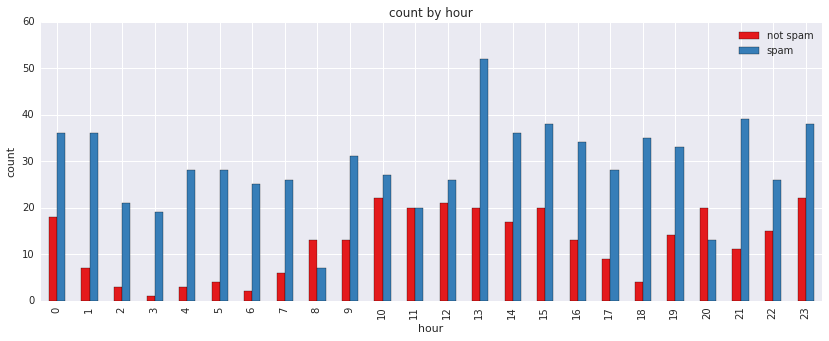

In [17]:
# spark dataframe轉成pandas dataframe
pandas_df = df_hour.toPandas() 
# 轉一下格式方便畫圖
pandas_df = pandas_df.pivot_table(index='hour',columns='spam',values='count') 
pandas_df.set_axis(1,['not spam','spam'])
# 使用pandas畫圖
ax=pandas_df.plot(kind='bar') 
ax.set_title('count by hour')
ax.set_ylabel('count')
ax.set_xlabel('hour')

----

#使用ML Pipeline進行spam預測
步驟：
1. 前處理。  
3. 建立pipeline。
4. 分成訓練和測試資料。
5. 使用訓練資料訓練pipeline。
7. 使用測試資料評估性能。

###前處理 
特徵抽取，加入時間特徵，利用上述dataframe udf加入hour特徵。

In [18]:
# 加入時間特徵
df_ml = df.withColumn('hour',hourOfDay(df['post_at']).astype(DoubleType())) 

###建立 Pipeline
本demo目的為Pipeline的使用，為了簡單起見，本demo只挑選幾個簡單的特徵：
- 時間"hour", 時間特徵使用上述的發文小時時間, 在前處理步驟已經加入。
- 點擊數"hits",
- 留言數量'comment_count'。  

我們使用線性分類器logistic regression，這種分類器只接受數值特徵，類別特徵必須先經過編碼轉換才能通過分類器。留言數和點擊數本身是數值特徵， 小時時間類別是類別特徵需要經過編碼轉成數值特徵。

Pipeline流程圖：
```
發文時間 ---- 類別數值化 ------------\  
                                   \  
點擊數量 -------------------------- 結合 ---> 分類器  
                                   /  
留言數量 --------------------------/  
```

In [19]:
# 發文時間編碼
hour_encoder = OneHotEncoder(inputCol="hour", outputCol="hour_code")  

# 結合所有特徵
assembler = VectorAssembler(inputCols=["hour_code","hits",'comment_count'], outputCol="features")

# 分類器
log_regressor = LogisticRegression(featuresCol="features",labelCol="spam")

#機器學習管線
pipeline = Pipeline(stages=[hour_encoder,assembler,log_regressor])

###把資料分成訓練和測試資料
在比例上，訓練資料佔七成，測試資料佔三成

In [20]:
df_train,df_test=df_ml.randomSplit([7.,3.],123)

###訓練pipeline
pipeline是Estimator所以有fit方法。

In [21]:
model = pipeline.fit(df_train)

###評估pipeline
1. 用訓練好的pipeline進行預測操是資料集。
3. 使用DataFrame計算預測精準度。
3. 利用dataframe觀察資料以利檢討模型。

In [22]:
# 用訓練好的pipeline進行預測測試資料集。
# 訓練好的pipeline是Transformer所以有transform方法。
df_pred = model.transform(df_test)

In [23]:
# 觀察transofrm對dataframe做了什麼事，所有pipeline設定的特徵和預測都加入dataframe了。
df_pred.printSchema()

root
 |-- category: string (nullable = true)
 |-- comment_count: long (nullable = true)
 |-- comment_ids: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- hits: long (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title: string (nullable = true)
 |-- spam: double (nullable = true)
 |-- post_at: long (nullable = true)
 |-- hour: double (nullable = true)
 |-- hour_code: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [24]:
pred_label = df_pred.select("prediction", "spam")
# 建立accuracy function，使用內建dataframe functions達成UDAF
accuracy = avg((pred_label.prediction==pred_label['spam']).astype(IntegerType())).alias("accuracy") 
# 需要groupBy才能使用此function, 所以就group所有data吧
pred_label.groupBy().agg(accuracy).show()

+------------------+
|          accuracy|
+------------------+
|0.7128378378378378|
+------------------+



In [25]:
# 檢討模型效能，觀察什麼樣的特徵導致錯誤預測。
df_pred.filter(df_pred['spam']!=df_pred['prediction'])\
        .select('hour','hits','comment_count','spam','prediction')\
        .show(10)

+----+----+-------------+----+----------+
|hour|hits|comment_count|spam|prediction|
+----+----+-------------+----+----------+
|13.0| 189|            0| 0.0|       1.0|
|12.0|  34|            0| 0.0|       1.0|
|20.0|   0|            0| 1.0|       0.0|
|20.0|   0|            0| 1.0|       0.0|
|20.0|   0|            0| 1.0|       0.0|
|20.0|   0|            0| 1.0|       0.0|
|15.0|   0|            0| 0.0|       1.0|
|10.0|2012|            0| 0.0|       1.0|
|15.0|3652|            4| 0.0|       1.0|
|13.0|   0|            0| 0.0|       1.0|
+----+----+-------------+----+----------+



#=====使用完請隨手關燈sc.stop(),感謝您======

In [7]:
sc.stop()